## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


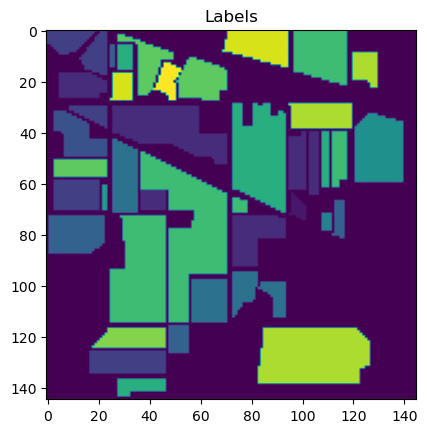

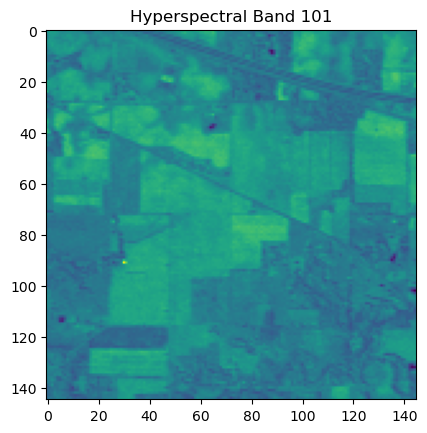

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(160, 5, 5, 200)
(80, 5, 5, 200)
(10009, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0791, PSNR: 10.4794


Epoch [1/50] Training Loss: 0.0650, PSNR: 11.4559
	[Val]   Batch [1/33] Loss: 0.0496, PSNR: 12.7115
	[Val]   Batch [10/33] Loss: 0.0490, PSNR: 12.3675
	[Val]   Batch [20/33] Loss: 0.0486, PSNR: 11.9637
	[Val]   Batch [30/33] Loss: 0.0471, PSNR: 12.3479
Epoch [1/50] Validation Loss: 0.0492, PSNR: 12.5351

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0503, PSNR: 12.7614


Epoch [2/50] Training Loss: 0.0399, PSNR: 13.5806
	[Val]   Batch [1/33] Loss: 0.0294, PSNR: 14.9756
	[Val]   Batch [10/33] Loss: 0.0289, PSNR: 14.6602
	[Val]   Batch [20/33] Loss: 0.0286, PSNR: 14.2671
	[Val]   Batch [30/33] Loss: 0.0278, PSNR: 14.6271
Epoch [2/50] Validation Loss: 0.0293, PSNR: 14.7923

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0286, PSNR: 14.8020


Epoch [3/50] Training Loss: 0.0235, PSNR: 15.8575
	[Val]   Batch [1/33] Loss: 0.0179, PSNR: 17.1246
	[Val]   Batch [10/33] Loss: 0.0175, PSNR: 16.8460
	[Val]   Batch [20/33] Loss: 0.0172, PSNR: 16.4807
	[Val]   Batch [30/33] Loss: 0.0167, PSNR: 16.8550
Epoch [3/50] Validation Loss: 0.0179, PSNR: 16.9407

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0166, PSNR: 17.2650


Epoch [4/50] Training Loss: 0.0144, PSNR: 17.9754
	[Val]   Batch [1/33] Loss: 0.0117, PSNR: 18.9959
	[Val]   Batch [10/33] Loss: 0.0112, PSNR: 18.7714
	[Val]   Batch [20/33] Loss: 0.0109, PSNR: 18.4462
	[Val]   Batch [30/33] Loss: 0.0106, PSNR: 18.8372
Epoch [4/50] Validation Loss: 0.0116, PSNR: 18.8146

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0124, PSNR: 18.8522


Epoch [5/50] Training Loss: 0.0097, PSNR: 19.7072
	[Val]   Batch [1/33] Loss: 0.0084, PSNR: 20.4300
	[Val]   Batch [10/33] Loss: 0.0079, PSNR: 20.2758
	[Val]   Batch [20/33] Loss: 0.0076, PSNR: 19.9953
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.3906
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2558

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0088, PSNR: 19.8561


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0305
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6308
	[Val]   Batch [10/33] Loss: 0.0059, PSNR: 21.5528
	[Val]   Batch [20/33] Loss: 0.0056, PSNR: 21.3198
	[Val]   Batch [30/33] Loss: 0.0054, PSNR: 21.7227
Epoch [6/50] Validation Loss: 0.0063, PSNR: 21.4648

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0058, PSNR: 22.1491


Epoch [7/50] Training Loss: 0.0056, PSNR: 22.0574
	[Val]   Batch [1/33] Loss: 0.0053, PSNR: 22.4509
	[Val]   Batch [10/33] Loss: 0.0048, PSNR: 22.4398
	[Val]   Batch [20/33] Loss: 0.0046, PSNR: 22.2442
	[Val]   Batch [30/33] Loss: 0.0044, PSNR: 22.6616
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.2943

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0060, PSNR: 21.6974


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8670
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2428
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.3141
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1612
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.5858
Epoch [8/50] Validation Loss: 0.0044, PSNR: 23.1062

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 23.6758


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5487
	[Val]   Batch [1/33] Loss: 0.0038, PSNR: 23.9019
	[Val]   Batch [10/33] Loss: 0.0033, PSNR: 24.0560
	[Val]   Batch [20/33] Loss: 0.0031, PSNR: 23.9355
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.3776
Epoch [9/50] Validation Loss: 0.0037, PSNR: 23.7931

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0032, PSNR: 24.5714


Epoch [10/50] Training Loss: 0.0035, PSNR: 24.1479
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.5045
	[Val]   Batch [10/33] Loss: 0.0028, PSNR: 24.7504
	[Val]   Batch [20/33] Loss: 0.0026, PSNR: 24.6643
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.1480
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.4455

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0035, PSNR: 23.8903


Epoch [11/50] Training Loss: 0.0031, PSNR: 24.6927
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.0075
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.3360
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.2772
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.8144
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.0040

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0044, PSNR: 22.5843


Epoch [12/50] Training Loss: 0.0028, PSNR: 25.1808
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5142
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.9231
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.8962
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4375
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5508

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.3760


Epoch [13/50] Training Loss: 0.0025, PSNR: 25.6596
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 25.9555
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.3978
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3849
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9422
Epoch [13/50] Validation Loss: 0.0023, PSNR: 26.0079

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.2850


Epoch [14/50] Training Loss: 0.0023, PSNR: 26.0438
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.2440
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6779
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.6666
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2457
Epoch [14/50] Validation Loss: 0.0021, PSNR: 26.3040

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.5433


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.3691
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6634
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.1263
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.1579
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.7513
Epoch [15/50] Validation Loss: 0.0019, PSNR: 26.7429

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.3557


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.7539
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9443
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.3184
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.3295
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.8903
Epoch [16/50] Validation Loss: 0.0018, PSNR: 26.9768

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.1346


Epoch [17/50] Training Loss: 0.0018, PSNR: 27.0912
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.6529
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0419
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0958
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6333
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.6786

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.8377


Epoch [18/50] Training Loss: 0.0017, PSNR: 27.4048
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.1259
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.4832
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.5307
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.1181
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.1375

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.8075


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.7444
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.4682
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7666
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8137
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4158
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.4671

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.4226


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.0533
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.8356
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1040
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.1612
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.7930
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.8225

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.4448


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.3236
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.2402
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.5071
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.5901
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2561
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.2377

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.6190


Epoch [22/50] Training Loss: 0.0013, PSNR: 28.5241
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.4561
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6913
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7967
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5042
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.4594

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.9834


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.7763
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7282
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9407
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0705
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7623
Epoch [23/50] Validation Loss: 0.0010, PSNR: 29.7308

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.6739


Epoch [24/50] Training Loss: 0.0012, PSNR: 28.9387
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8493
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0719
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2214
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9193
Epoch [24/50] Validation Loss: 0.0009, PSNR: 29.8613

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.4710


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.1057
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1348
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3216
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4908
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1761
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.1374

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.6673


Epoch [26/50] Training Loss: 0.0011, PSNR: 29.2728
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1546
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3749
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5721
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3565
Epoch [26/50] Validation Loss: 0.0009, PSNR: 30.2049
Early stopping triggered at epoch 26. No improvement for 3 epochs.


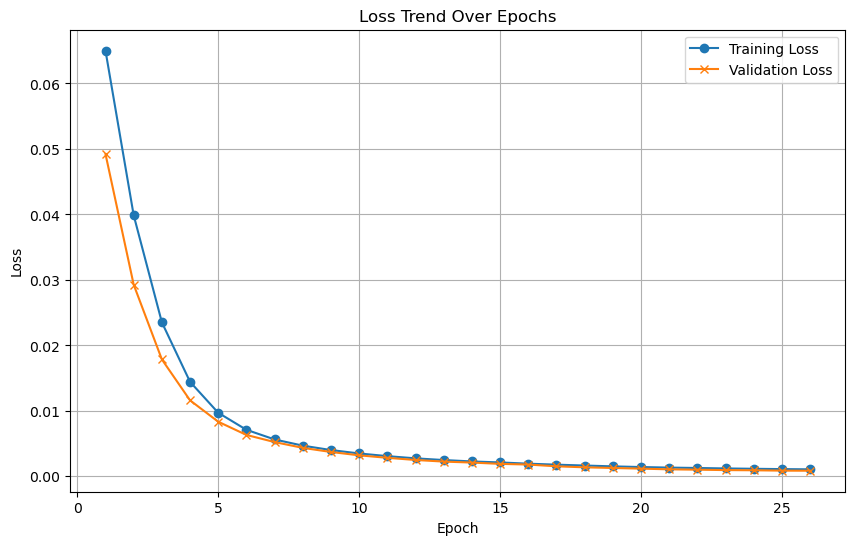

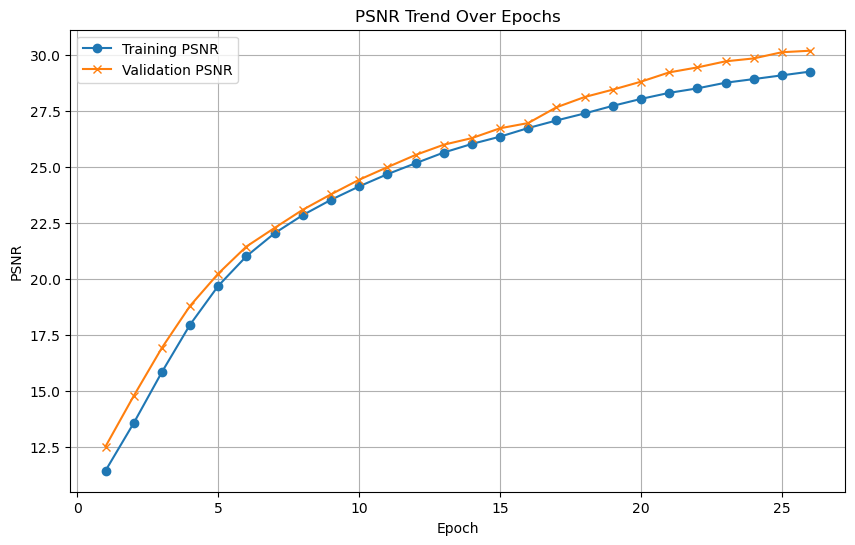

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7957
    Validation Batch [1/1], Loss: 2.7811
Validation Loss: 2.7811, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7811. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7613
    Validation Batch [1/1], Loss: 2.7811
Validation Loss: 2.7811, Validation Accuracy: 6.25%
Validation loss improved from 2.7811 to 2.7811. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7585
    Validation Batch [1/1], Loss: 2.7811
Validation Loss: 2.7811, Validation Accuracy: 6.25%
Validation loss improved from 2.7811 to 2.7811. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7408
    Validation Batch [1/1], Loss: 2.7810
Validation Loss: 2.7810, Validation Accuracy: 6.25%
Validation loss improved from 2.7811 to 2.7810. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.7806
Validation Loss: 2.7806, Validation Accuracy: 6.25%
Validation loss improved from 2.7807 to 2.7806. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.7000
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss improved from 2.7806 to 2.7805. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6983
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss improved from 2.7805 to 2.7805. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6824
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss improved from 2.7805 to 2.7804. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6691
    Validation B

Epoch [19/1000] completed, Average Training Loss: 2.6231
    Validation Batch [1/1], Loss: 2.7798
Validation Loss: 2.7798, Validation Accuracy: 6.25%
Validation loss improved from 2.7801 to 2.7798. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.6144
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss improved from 2.7798 to 2.7795. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5999
    Validation Batch [1/1], Loss: 2.7792
Validation Loss: 2.7792, Validation Accuracy: 6.25%
Validation loss improved from 2.7795 to 2.7792. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.5986
    Validation Batch [1/1], Loss: 2.7790
Validation Loss: 2.7790, Validation Accuracy: 6.25%
Validation loss improved from 2.7792 to 2.7790. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/10

Epoch [34/1000] completed, Average Training Loss: 2.5280
    Validation Batch [1/1], Loss: 2.7621
Validation Loss: 2.7621, Validation Accuracy: 6.25%
Validation loss improved from 2.7656 to 2.7621. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.5052
    Validation Batch [1/1], Loss: 2.7572
Validation Loss: 2.7572, Validation Accuracy: 6.25%
Validation loss improved from 2.7621 to 2.7572. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.5143
    Validation Batch [1/1], Loss: 2.7525
Validation Loss: 2.7525, Validation Accuracy: 6.25%
Validation loss improved from 2.7572 to 2.7525. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.5048
    Validation Batch [1/1], Loss: 2.7487
Validation Loss: 2.7487, Validation Accuracy: 6.25%
Validation loss improved from 2.7525 to 2.7487. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/10

Epoch [45/1000] completed, Average Training Loss: 2.4514
    Validation Batch [1/1], Loss: 2.7011
Validation Loss: 2.7011, Validation Accuracy: 11.25%
Validation loss improved from 2.7069 to 2.7011. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.4426
    Validation Batch [1/1], Loss: 2.6936
Validation Loss: 2.6936, Validation Accuracy: 15.00%
Validation loss improved from 2.7011 to 2.6936. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.4257
    Validation Batch [1/1], Loss: 2.6844
Validation Loss: 2.6844, Validation Accuracy: 16.25%
Validation loss improved from 2.6936 to 2.6844. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.4119
    Validation Batch [1/1], Loss: 2.6753
Validation Loss: 2.6753, Validation Accuracy: 17.50%
Validation loss improved from 2.6844 to 2.6753. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 2.5801
Validation Loss: 2.5801, Validation Accuracy: 23.75%
Validation loss improved from 2.5886 to 2.5801. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.3205
    Validation Batch [1/1], Loss: 2.5610
Validation Loss: 2.5610, Validation Accuracy: 23.75%
Validation loss improved from 2.5801 to 2.5610. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.3215
    Validation Batch [1/1], Loss: 2.5489
Validation Loss: 2.5489, Validation Accuracy: 27.50%
Validation loss improved from 2.5610 to 2.5489. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.3159
    Validation Batch [1/1], Loss: 2.5506
Validation Loss: 2.5506, Validation Accuracy: 26.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.3052
    Validation Batch [1

    Validation Batch [1/1], Loss: 2.4814
Validation Loss: 2.4814, Validation Accuracy: 37.50%
Validation loss improved from 2.5047 to 2.4814. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.2388
    Validation Batch [1/1], Loss: 2.4748
Validation Loss: 2.4748, Validation Accuracy: 38.75%
Validation loss improved from 2.4814 to 2.4748. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.2154
    Validation Batch [1/1], Loss: 2.4889
Validation Loss: 2.4889, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.2104
    Validation Batch [1/1], Loss: 2.5097
Validation Loss: 2.5097, Validation Accuracy: 28.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.2338
    Validation Batch [1/1], Loss: 2.49

Epoch [85/1000] completed, Average Training Loss: 2.1648
    Validation Batch [1/1], Loss: 2.4172
Validation Loss: 2.4172, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.1214
    Validation Batch [1/1], Loss: 2.3929
Validation Loss: 2.3929, Validation Accuracy: 42.50%
Validation loss improved from 2.4019 to 2.3929. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0954
    Validation Batch [1/1], Loss: 2.3899
Validation Loss: 2.3899, Validation Accuracy: 40.00%
Validation loss improved from 2.3929 to 2.3899. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 2.1074
    Validation Batch [1/1], Loss: 2.4020
Validation Loss: 2.4020, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Tra

Epoch [98/1000] completed, Average Training Loss: 2.0030
    Validation Batch [1/1], Loss: 2.3636
Validation Loss: 2.3636, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 2.0302
    Validation Batch [1/1], Loss: 2.3299
Validation Loss: 2.3299, Validation Accuracy: 40.00%
Validation loss improved from 2.3428 to 2.3299. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.9910
    Validation Batch [1/1], Loss: 2.3317
Validation Loss: 2.3317, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 2.0095
    Validation Batch [1/1], Loss: 2.3357
Validation Loss: 2.3357, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Los

Epoch [112/1000] completed, Average Training Loss: 1.9109
    Validation Batch [1/1], Loss: 2.2671
Validation Loss: 2.2671, Validation Accuracy: 42.50%
Validation loss improved from 2.2700 to 2.2671. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.8710
    Validation Batch [1/1], Loss: 2.2498
Validation Loss: 2.2498, Validation Accuracy: 43.75%
Validation loss improved from 2.2671 to 2.2498. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.8446
    Validation Batch [1/1], Loss: 2.2421
Validation Loss: 2.2421, Validation Accuracy: 46.25%
Validation loss improved from 2.2498 to 2.2421. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.8329
    Validation Batch [1/1], Loss: 2.2305
Validation Loss: 2.2305, Validation Accuracy: 48.75%
Validation loss improved from 2.2421 to 2.2305. Saving model...

LOG: Epoch [116/1000] - Training


Epoch [126/1000] completed, Average Training Loss: 1.7601
    Validation Batch [1/1], Loss: 2.1826
Validation Loss: 2.1826, Validation Accuracy: 51.25%
Validation loss improved from 2.1830 to 2.1826. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.7403
    Validation Batch [1/1], Loss: 2.1708
Validation Loss: 2.1708, Validation Accuracy: 53.75%
Validation loss improved from 2.1826 to 2.1708. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.7515
    Validation Batch [1/1], Loss: 2.1816
Validation Loss: 2.1816, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.7406
    Validation Batch [1/1], Loss: 2.1849
Validation Loss: 2.1849, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Av

Epoch [137/1000] completed, Average Training Loss: 1.6895
    Validation Batch [1/1], Loss: 2.1595
Validation Loss: 2.1595, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.6222
    Validation Batch [1/1], Loss: 2.1601
Validation Loss: 2.1601, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.6725
    Validation Batch [1/1], Loss: 2.1501
Validation Loss: 2.1501, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.6354
    Validation Batch [1/1], Loss: 2.1560
Validation Loss: 2.1560, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.6139
  

Epoch [152/1000] completed, Average Training Loss: 1.5794
    Validation Batch [1/1], Loss: 2.0695
Validation Loss: 2.0695, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.4966
    Validation Batch [1/1], Loss: 2.0929
Validation Loss: 2.0929, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.5047
    Validation Batch [1/1], Loss: 2.0129
Validation Loss: 2.0129, Validation Accuracy: 56.25%
Validation loss improved from 2.0322 to 2.0129. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.4662
    Validation Batch [1/1], Loss: 2.0019
Validation Loss: 2.0019, Validation Accuracy: 56.25%
Validation loss improved from 2.0129 to 2.0019. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Av

Epoch [164/1000] completed, Average Training Loss: 1.4413
    Validation Batch [1/1], Loss: 1.9916
Validation Loss: 1.9916, Validation Accuracy: 52.50%
Validation loss improved from 1.9928 to 1.9916. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.3678
    Validation Batch [1/1], Loss: 1.9928
Validation Loss: 1.9928, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.4101
    Validation Batch [1/1], Loss: 1.9891
Validation Loss: 1.9891, Validation Accuracy: 55.00%
Validation loss improved from 1.9916 to 1.9891. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.4050
    Validation Batch [1/1], Loss: 1.9978
Validation Loss: 1.9978, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Av

Epoch [180/1000] completed, Average Training Loss: 1.3122
    Validation Batch [1/1], Loss: 1.9152
Validation Loss: 1.9152, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.2490
    Validation Batch [1/1], Loss: 1.8830
Validation Loss: 1.8830, Validation Accuracy: 55.00%
Validation loss improved from 1.8928 to 1.8830. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.2331
    Validation Batch [1/1], Loss: 1.8432
Validation Loss: 1.8432, Validation Accuracy: 56.25%
Validation loss improved from 1.8830 to 1.8432. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.2465
    Validation Batch [1/1], Loss: 1.8631
Validation Loss: 1.8631, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Av

Epoch [189/1000] completed, Average Training Loss: 1.2183
    Validation Batch [1/1], Loss: 1.8424
Validation Loss: 1.8424, Validation Accuracy: 60.00%
Validation loss improved from 1.8432 to 1.8424. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.1775
    Validation Batch [1/1], Loss: 1.8189
Validation Loss: 1.8189, Validation Accuracy: 58.75%
Validation loss improved from 1.8424 to 1.8189. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.1619
    Validation Batch [1/1], Loss: 1.8330
Validation Loss: 1.8330, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.2012
    Validation Batch [1/1], Loss: 1.8840
Validation Loss: 1.8840, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Av

    Validation Batch [1/1], Loss: 1.7354
Validation Loss: 1.7354, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0250
    Validation Batch [1/1], Loss: 1.7734
Validation Loss: 1.7734, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0671
    Validation Batch [1/1], Loss: 1.7449
Validation Loss: 1.7449, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.9896
    Validation Batch [1/1], Loss: 1.7227
Validation Loss: 1.7227, Validation Accuracy: 57.50%
Validation loss improved from 1.7294 to 1.7227. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.9941
    Validation Batch [1/1], Loss: 1.7318
Vali

    Validation Batch [1/1], Loss: 1.7381
Validation Loss: 1.7381, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.9830
    Validation Batch [1/1], Loss: 1.7315
Validation Loss: 1.7315, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 1.0002
    Validation Batch [1/1], Loss: 1.7265
Validation Loss: 1.7265, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.9361
    Validation Batch [1/1], Loss: 1.7450
Validation Loss: 1.7450, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.9690
    Validation Batch [1/1], Loss: 1.7093
Validation Loss: 1.

Epoch [234/1000] completed, Average Training Loss: 0.8113
    Validation Batch [1/1], Loss: 1.6386
Validation Loss: 1.6386, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.8522
    Validation Batch [1/1], Loss: 1.6669
Validation Loss: 1.6669, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.8402
    Validation Batch [1/1], Loss: 1.6067
Validation Loss: 1.6067, Validation Accuracy: 57.50%
Validation loss improved from 1.6126 to 1.6067. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.8337
    Validation Batch [1/1], Loss: 1.6077
Validation Loss: 1.6077, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.5673
Validation Loss: 1.5673, Validation Accuracy: 66.25%
Validation loss improved from 1.5765 to 1.5673. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.8175
    Validation Batch [1/1], Loss: 1.5830
Validation Loss: 1.5830, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.7991
    Validation Batch [1/1], Loss: 1.5867
Validation Loss: 1.5867, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.7514
    Validation Batch [1/1], Loss: 1.5376
Validation Loss: 1.5376, Validation Accuracy: 66.25%
Validation loss improved from 1.5673 to 1.5376. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.7499
    Validation Batch [1/1], Lo

Epoch [260/1000] completed, Average Training Loss: 0.6428
    Validation Batch [1/1], Loss: 1.4888
Validation Loss: 1.4888, Validation Accuracy: 68.75%
Validation loss improved from 1.5051 to 1.4888. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6466
    Validation Batch [1/1], Loss: 1.5374
Validation Loss: 1.5374, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.6557
    Validation Batch [1/1], Loss: 1.4832
Validation Loss: 1.4832, Validation Accuracy: 65.00%
Validation loss improved from 1.4888 to 1.4832. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.6994
    Validation Batch [1/1], Loss: 1.4799
Validation Loss: 1.4799, Validation Accuracy: 66.25%
Validation loss improved from 1.4832 to 1.4799. Saving model...

LOG: Epoch [264/1000] - Training
Epoch [264/1000

Epoch [267/1000] completed, Average Training Loss: 0.5993
    Validation Batch [1/1], Loss: 1.4982
Validation Loss: 1.4982, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.6200
    Validation Batch [1/1], Loss: 1.5067
Validation Loss: 1.5067, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.6133
    Validation Batch [1/1], Loss: 1.4520
Validation Loss: 1.4520, Validation Accuracy: 63.75%
Validation loss improved from 1.4639 to 1.4520. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.6265
    Validation Batch [1/1], Loss: 1.4733
Validation Loss: 1.4733, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training 

Epoch [286/1000] completed, Average Training Loss: 0.5281
    Validation Batch [1/1], Loss: 1.4756
Validation Loss: 1.4756, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.5479
    Validation Batch [1/1], Loss: 1.4924
Validation Loss: 1.4924, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.5249
    Validation Batch [1/1], Loss: 1.4625
Validation Loss: 1.4625, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.5250
    Validation Batch [1/1], Loss: 1.3614
Validation Loss: 1.3614, Validation Accuracy: 63.75%
Validation loss improved from 1.4165 to 1.3614. Saving model...

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3857
Validation Loss: 1.3857, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4959
    Validation Batch [1/1], Loss: 1.3774
Validation Loss: 1.3774, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.5247
    Validation Batch [1/1], Loss: 1.3891
Validation Loss: 1.3891, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4998
    Validation Batch [1/1], Loss: 1.4239
Validation Loss: 1.4239, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.4402
    Validation Batch [1/1], Loss: 1.3805
Validation Loss: 1.

Epoch [313/1000] completed, Average Training Loss: 0.4181
    Validation Batch [1/1], Loss: 1.3465
Validation Loss: 1.3465, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.4356
    Validation Batch [1/1], Loss: 1.3391
Validation Loss: 1.3391, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4348
    Validation Batch [1/1], Loss: 1.3171
Validation Loss: 1.3171, Validation Accuracy: 68.75%
Validation loss improved from 1.3303 to 1.3171. Saving model...

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.4456
    Validation Batch [1/1], Loss: 1.3513
Validation Loss: 1.3513, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training 

Epoch [321/1000] completed, Average Training Loss: 0.4163
    Validation Batch [1/1], Loss: 1.3004
Validation Loss: 1.3004, Validation Accuracy: 68.75%
Validation loss improved from 1.3125 to 1.3004. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3863
    Validation Batch [1/1], Loss: 1.2944
Validation Loss: 1.2944, Validation Accuracy: 67.50%
Validation loss improved from 1.3004 to 1.2944. Saving model...

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3651
    Validation Batch [1/1], Loss: 1.3148
Validation Loss: 1.3148, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.3861
    Validation Batch [1/1], Loss: 1.3291
Validation Loss: 1.3291, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Av

Epoch [338/1000] completed, Average Training Loss: 0.3265
    Validation Batch [1/1], Loss: 1.3024
Validation Loss: 1.3024, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3484
    Validation Batch [1/1], Loss: 1.2575
Validation Loss: 1.2575, Validation Accuracy: 66.25%
Validation loss improved from 1.2594 to 1.2575. Saving model...

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.3215
    Validation Batch [1/1], Loss: 1.2920
Validation Loss: 1.2920, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3225
    Validation Batch [1/1], Loss: 1.2955
Validation Loss: 1.2955, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training 

Validation Loss: 1.3861, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.3394
    Validation Batch [1/1], Loss: 1.3132
Validation Loss: 1.3132, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.3127
    Validation Batch [1/1], Loss: 1.3709
Validation Loss: 1.3709, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.3050
    Validation Batch [1/1], Loss: 1.3011
Validation Loss: 1.3011, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.3148
    Validation Batch [1/1], Loss: 1.2721
Validation Loss: 1.2721, Validation Accuracy: 65.00%
Validat

Epoch [365/1000] completed, Average Training Loss: 0.2631
    Validation Batch [1/1], Loss: 1.2495
Validation Loss: 1.2495, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2671
    Validation Batch [1/1], Loss: 1.2487
Validation Loss: 1.2487, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2434
    Validation Batch [1/1], Loss: 1.2550
Validation Loss: 1.2550, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2707
    Validation Batch [1/1], Loss: 1.2477
Validation Loss: 1.2477, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2659
  

    Validation Batch [1/1], Loss: 1.2767
Validation Loss: 1.2767, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2571
    Validation Batch [1/1], Loss: 1.2446
Validation Loss: 1.2446, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2572
    Validation Batch [1/1], Loss: 1.2135
Validation Loss: 1.2135, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2383
    Validation Batch [1/1], Loss: 1.2189
Validation Loss: 1.2189, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2607
    Validation Batch [1/1], Loss: 1.1814
Validation Loss: 1.

Epoch [392/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 1.2405
Validation Loss: 1.2405, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.2252
    Validation Batch [1/1], Loss: 1.2126
Validation Loss: 1.2126, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2067
    Validation Batch [1/1], Loss: 1.2644
Validation Loss: 1.2644, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2319
    Validation Batch [1/1], Loss: 1.2698
Validation Loss: 1.2698, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.212

Epoch [402/1000] completed, Average Training Loss: 0.2037
    Validation Batch [1/1], Loss: 1.2189
Validation Loss: 1.2189, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2086
    Validation Batch [1/1], Loss: 1.1899
Validation Loss: 1.1899, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.2022
    Validation Batch [1/1], Loss: 1.1453
Validation Loss: 1.1453, Validation Accuracy: 71.25%
Validation loss improved from 1.1814 to 1.1453. Saving model...

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.2172
    Validation Batch [1/1], Loss: 1.1581
Validation Loss: 1.1581, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 1.2401
Validation Loss: 1.2401, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1633
    Validation Batch [1/1], Loss: 1.1941
Validation Loss: 1.1941, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.2039
    Validation Batch [1/1], Loss: 1.1913
Validation Loss: 1.1913, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1807
    Validation Batch [1/1], Loss: 1.1721
Validation Loss: 1.1721, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1687
    Validation Batch [1/1], Loss: 1.2641
Validation Loss

    Validation Batch [1/1], Loss: 1.1574
Validation Loss: 1.1574, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.2040
    Validation Batch [1/1], Loss: 1.2240
Validation Loss: 1.2240, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.2016
    Validation Batch [1/1], Loss: 1.1041
Validation Loss: 1.1041, Validation Accuracy: 70.00%
Validation loss improved from 1.1453 to 1.1041. Saving model...

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1764
    Validation Batch [1/1], Loss: 1.2227
Validation Loss: 1.2227, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1949
    Validation Batch [1/1], Loss: 1.2254
Va

Epoch [446/1000] completed, Average Training Loss: 0.1681
    Validation Batch [1/1], Loss: 1.1425
Validation Loss: 1.1425, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1391
    Validation Batch [1/1], Loss: 1.1565
Validation Loss: 1.1565, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1487
    Validation Batch [1/1], Loss: 1.1689
Validation Loss: 1.1689, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1711
    Validation Batch [1/1], Loss: 1.1528
Validation Loss: 1.1528, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.145

Epoch [459/1000] completed, Average Training Loss: 0.1409
    Validation Batch [1/1], Loss: 1.2267
Validation Loss: 1.2267, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1380
    Validation Batch [1/1], Loss: 1.1704
Validation Loss: 1.1704, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1392
    Validation Batch [1/1], Loss: 1.1231
Validation Loss: 1.1231, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1268
    Validation Batch [1/1], Loss: 1.1058
Validation Loss: 1.1058, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.138

Epoch [472/1000] completed, Average Training Loss: 0.1352
    Validation Batch [1/1], Loss: 1.1232
Validation Loss: 1.1232, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1159
    Validation Batch [1/1], Loss: 1.1841
Validation Loss: 1.1841, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1222
    Validation Batch [1/1], Loss: 1.1607
Validation Loss: 1.1607, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1256
    Validation Batch [1/1], Loss: 1.1348
Validation Loss: 1.1348, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1401
  

Epoch [488/1000] completed, Average Training Loss: 0.1245
    Validation Batch [1/1], Loss: 1.0966
Validation Loss: 1.0966, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.1075
    Validation Batch [1/1], Loss: 1.1207
Validation Loss: 1.1207, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.1199
    Validation Batch [1/1], Loss: 1.1427
Validation Loss: 1.1427, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1518
    Validation Batch [1/1], Loss: 1.1402
Validation Loss: 1.1402, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.129

Epoch [500/1000] completed, Average Training Loss: 0.1379
    Validation Batch [1/1], Loss: 1.1706
Validation Loss: 1.1706, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0977
    Validation Batch [1/1], Loss: 1.3176
Validation Loss: 1.3176, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1136
    Validation Batch [1/1], Loss: 1.3142
Validation Loss: 1.3142, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0973
    Validation Batch [1/1], Loss: 1.2602
Validation Loss: 1.2602, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.103

Validation Loss: 1.2126, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 1.1774
Validation Loss: 1.1774, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.1217
    Validation Batch [1/1], Loss: 1.1860
Validation Loss: 1.1860, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0987
    Validation Batch [1/1], Loss: 1.1580
Validation Loss: 1.1580, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.1032
    Validation Batch [1/1], Loss: 1.1464
Validation Loss: 1.1464, Validation Accuracy: 68.75%
Val

Epoch [527/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 1.2716
Validation Loss: 1.2716, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.1054
    Validation Batch [1/1], Loss: 1.1820
Validation Loss: 1.1820, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 1.0749
Validation Loss: 1.0749, Validation Accuracy: 70.00%
Validation loss improved from 1.0859 to 1.0749. Saving model...

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.1061
    Validation Batch [1/1], Loss: 1.0900
Validation Loss: 1.0900, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Trainin

Epoch [541/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 1.1355
Validation Loss: 1.1355, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0914
    Validation Batch [1/1], Loss: 1.0926
Validation Loss: 1.0926, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.1158
    Validation Batch [1/1], Loss: 1.1230
Validation Loss: 1.1230, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 1.1623
Validation Loss: 1.1623, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0904

Epoch [553/1000] completed, Average Training Loss: 0.0899
    Validation Batch [1/1], Loss: 1.2488
Validation Loss: 1.2488, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0847
    Validation Batch [1/1], Loss: 1.2893
Validation Loss: 1.2893, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0761
    Validation Batch [1/1], Loss: 1.2497
Validation Loss: 1.2497, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0857
    Validation Batch [1/1], Loss: 1.2065
Validation Loss: 1.2065, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.086

Epoch [569/1000] completed, Average Training Loss: 0.0806
    Validation Batch [1/1], Loss: 1.1751
Validation Loss: 1.1751, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 1.1550
Validation Loss: 1.1550, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 1.1301
Validation Loss: 1.1301, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0854
    Validation Batch [1/1], Loss: 1.1246
Validation Loss: 1.1246, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.086

Epoch [580/1000] completed, Average Training Loss: 0.0857
    Validation Batch [1/1], Loss: 1.1350
Validation Loss: 1.1350, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0854
    Validation Batch [1/1], Loss: 1.1251
Validation Loss: 1.1251, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0610
    Validation Batch [1/1], Loss: 1.1007
Validation Loss: 1.1007, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 1.0777
Validation Loss: 1.0777, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.070

Epoch [597/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 1.1941
Validation Loss: 1.1941, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0817
    Validation Batch [1/1], Loss: 1.1852
Validation Loss: 1.1852, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 1.1474
Validation Loss: 1.1474, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 1.1171
Validation Loss: 1.1171, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.067

Epoch [606/1000] completed, Average Training Loss: 0.0724
    Validation Batch [1/1], Loss: 1.1661
Validation Loss: 1.1661, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0973
    Validation Batch [1/1], Loss: 1.1351
Validation Loss: 1.1351, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 1.0893
Validation Loss: 1.0893, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 1.0853
Validation Loss: 1.0853, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.074

Epoch [625/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 1.1202
Validation Loss: 1.1202, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0664
    Validation Batch [1/1], Loss: 1.1238
Validation Loss: 1.1238, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0635
    Validation Batch [1/1], Loss: 1.1800
Validation Loss: 1.1800, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 1.1845
Validation Loss: 1.1845, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.057

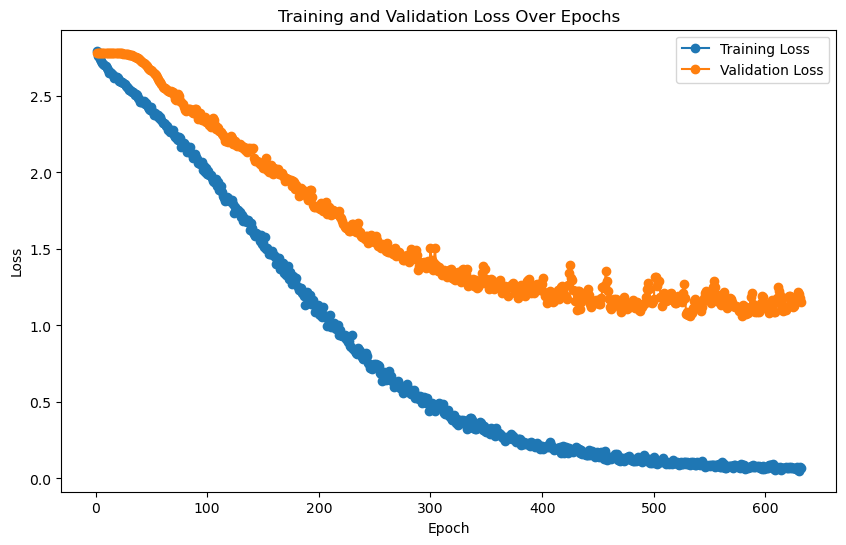

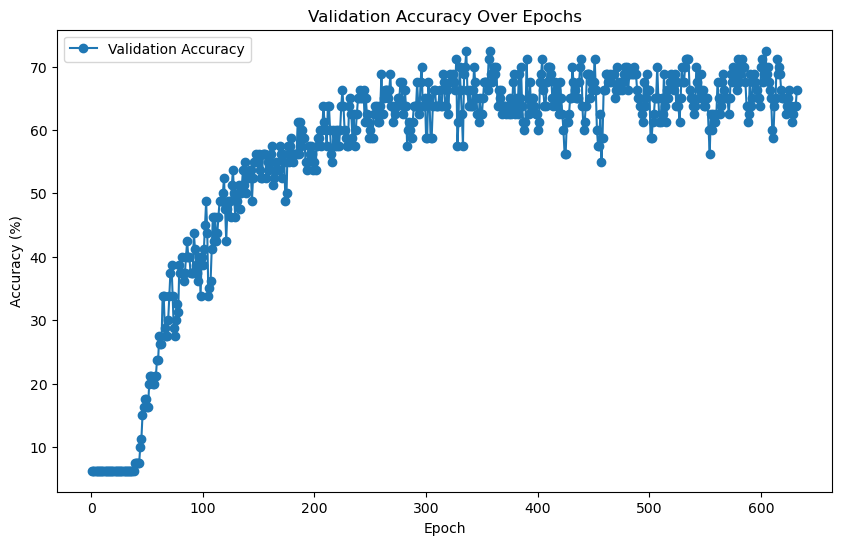


Evaluating on the test set...
    Test Batch [1/40], Loss: 3.2086

Final Test Loss: 1.8534, Test Accuracy: 52.33%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10009, 64), Test labels shape: (10009,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 51.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.00      0.00      0.00         5
           2       0.50      0.60      0.55         5
           3       1.00      0.20      0.33         5
           4       0.50      0.40      0.44         5
           5       0.60      0.60      0.60         5
           6       1.00      0.60      0.75         5
           7       0.38      0.60      0.46         5
           8       0.83      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10009, 64)
Test labels shape: (10009,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8279  |  Val Loss: 2.7534
Validation loss improved from inf to 2.7534.
[Epoch 2/1000] Train Loss: 2.7285  |  Val Loss: 2.7024
Validation loss improved from 2.7534 to 2.7024.
[Epoch 3/1000] Train Loss: 2.6744  |  Val Loss: 2.6676
Validation loss improved from 2.7024 to 2.6676.
[Epoch 4/1000] Train Loss: 2.6320  |  Val Loss: 2.6324
Validation loss improved from 2.6676 to 2.6324.
[Epoch 5/1000] Train Loss: 2.5879  |  Val Loss: 2.5941
Validation loss improved from 2.6324 to 2.5941.
[Epoch 6/1000] Train Loss: 2.5405  |  Val Loss: 2.5564
Validation loss improved from 2.5941 to 2.5564.
[Epoch 7/1000] Train Loss: 2.4941  |  Val Loss: 2.5169
Validation loss improved from 2.5564 to 2.5169.
[Epoch 8/1000] Train Loss: 2.4468  |  Val Loss: 2.4761
Validation loss improved from 2.5169 to 2.4761.
[Epoch 9/1000] Train Loss: 2.3932  |  Val Loss: 2.4338
Validation loss improved from 2.4761 to 2.4338.
[Epoch 10/1000] Train Loss: 2.3471  |  Val Loss: 2.3895
Validation loss impr

[Epoch 11/1000] Train Loss: 2.2958  |  Val Loss: 2.3489
Validation loss improved from 2.3895 to 2.3489.
[Epoch 12/1000] Train Loss: 2.2491  |  Val Loss: 2.3132
Validation loss improved from 2.3489 to 2.3132.
[Epoch 13/1000] Train Loss: 2.2017  |  Val Loss: 2.2757
Validation loss improved from 2.3132 to 2.2757.
[Epoch 14/1000] Train Loss: 2.1535  |  Val Loss: 2.2402
Validation loss improved from 2.2757 to 2.2402.
[Epoch 15/1000] Train Loss: 2.1036  |  Val Loss: 2.2146
Validation loss improved from 2.2402 to 2.2146.
[Epoch 16/1000] Train Loss: 2.0619  |  Val Loss: 2.1826
Validation loss improved from 2.2146 to 2.1826.
[Epoch 17/1000] Train Loss: 2.0155  |  Val Loss: 2.1430
Validation loss improved from 2.1826 to 2.1430.
[Epoch 18/1000] Train Loss: 1.9653  |  Val Loss: 2.1077
Validation loss improved from 2.1430 to 2.1077.
[Epoch 19/1000] Train Loss: 1.9171  |  Val Loss: 2.0786
Validation loss improved from 2.1077 to 2.0786.
[Epoch 20/1000] Train Loss: 1.8724  |  Val Loss: 2.0453
Validati

[Epoch 26/1000] Train Loss: 1.6043  |  Val Loss: 1.8825
Validation loss improved from 1.8933 to 1.8825.
[Epoch 27/1000] Train Loss: 1.5605  |  Val Loss: 1.8519
Validation loss improved from 1.8825 to 1.8519.
[Epoch 28/1000] Train Loss: 1.5215  |  Val Loss: 1.8268
Validation loss improved from 1.8519 to 1.8268.
[Epoch 29/1000] Train Loss: 1.4928  |  Val Loss: 1.8138
Validation loss improved from 1.8268 to 1.8138.
[Epoch 30/1000] Train Loss: 1.4504  |  Val Loss: 1.8022
Validation loss improved from 1.8138 to 1.8022.
[Epoch 31/1000] Train Loss: 1.4231  |  Val Loss: 1.7832
Validation loss improved from 1.8022 to 1.7832.


[Epoch 32/1000] Train Loss: 1.3888  |  Val Loss: 1.7594
Validation loss improved from 1.7832 to 1.7594.
[Epoch 33/1000] Train Loss: 1.3553  |  Val Loss: 1.7513
Validation loss improved from 1.7594 to 1.7513.
[Epoch 34/1000] Train Loss: 1.3265  |  Val Loss: 1.7530
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 1.2999  |  Val Loss: 1.7393
Validation loss improved from 1.7513 to 1.7393.
[Epoch 36/1000] Train Loss: 1.2682  |  Val Loss: 1.7285
Validation loss improved from 1.7393 to 1.7285.


[Epoch 37/1000] Train Loss: 1.2484  |  Val Loss: 1.7251
Validation loss improved from 1.7285 to 1.7251.
[Epoch 38/1000] Train Loss: 1.2191  |  Val Loss: 1.7139
Validation loss improved from 1.7251 to 1.7139.
[Epoch 39/1000] Train Loss: 1.1998  |  Val Loss: 1.7026
Validation loss improved from 1.7139 to 1.7026.
[Epoch 40/1000] Train Loss: 1.1712  |  Val Loss: 1.6899
Validation loss improved from 1.7026 to 1.6899.
[Epoch 41/1000] Train Loss: 1.1538  |  Val Loss: 1.6977
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 1.1376  |  Val Loss: 1.6981
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 1.1093  |  Val Loss: 1.6948
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 1.0904  |  Val Loss: 1.6872
Validation loss improved from 1.6899 to 1.6872.
[Epoch 45/1000] Train Loss: 1.0731  |  Val Loss: 1.6778
Validation loss improved from 1.6872 to 1.6778.
[Epoch 46/1000] Train Loss: 1.0497  |  Val Los

[Epoch 54/1000] Train Loss: 0.9228  |  Val Loss: 1.7005
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 55/1000] Train Loss: 0.9127  |  Val Loss: 1.7167
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 56/1000] Train Loss: 0.8998  |  Val Loss: 1.7036
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 57/1000] Train Loss: 0.8859  |  Val Loss: 1.6866
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 58/1000] Train Loss: 0.8761  |  Val Loss: 1.6929
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 59/1000] Train Loss: 0.8610  |  Val Loss: 1.7045
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 60/1000] Train Loss: 0.8499  |  Val Loss: 1.7067
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 61/1000] Train Loss: 0.8328  |  Val Loss: 1.6951
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 62/1000] Train Loss: 0.8253  |  Val Loss: 1.6955
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 63/1000] Train Loss: 0.8077  |  Val Loss: 1.6942
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 64/1000] Train Loss: 0.8017  |  Val Loss: 1.7001
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 65/1000] Train Loss: 0.7939  |  Val Loss: 1.6986
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 66/1000] Train Loss: 0.7807  |  Val Loss: 1.7058
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 67/1000] Train Loss: 0.7667  |  Val Loss: 1.7070
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 68/1000] Train Loss: 0.7644  |  Val Loss: 1.7062
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 69/1000] Train Loss: 0.7556  |  Val Loss: 1.7051
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 70/1000] Train Loss: 0.7460  |  Val Loss: 1.7067
!! Validation loss did NOT improve !! Patience: 25/100
[

[Epoch 84/1000] Train Loss: 0.6301  |  Val Loss: 1.7501
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 85/1000] Train Loss: 0.6323  |  Val Loss: 1.7579
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 86/1000] Train Loss: 0.6365  |  Val Loss: 1.7349
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 87/1000] Train Loss: 0.6191  |  Val Loss: 1.7394
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 88/1000] Train Loss: 0.6260  |  Val Loss: 1.7267
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 89/1000] Train Loss: 0.6080  |  Val Loss: 1.7592
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 90/1000] Train Loss: 0.6127  |  Val Loss: 1.7670
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 91/1000] Train Loss: 0.5989  |  Val Loss: 1.7651
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 92/1000] Train Loss: 0.5913  |  Val Loss: 1.7597
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 93/1000] Train Loss: 0.5873  |  Val Loss: 1.7712
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 94/1000] Train Loss: 0.5767  |  Val Loss: 1.7793
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 95/1000] Train Loss: 0.5757  |  Val Loss: 1.7880
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 96/1000] Train Loss: 0.5653  |  Val Loss: 1.8063
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 97/1000] Train Loss: 0.5608  |  Val Loss: 1.8090
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 98/1000] Train Loss: 0.5585  |  Val Loss: 1.7985
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 99/1000] Train Loss: 0.5484  |  Val Loss: 1.7776
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 100/1000] Train Loss: 0.5440  |  Val Loss: 1.7943
!! Validation loss did NOT improve !! Patience: 55/100


[Epoch 112/1000] Train Loss: 0.4799  |  Val Loss: 1.8265
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 113/1000] Train Loss: 0.4719  |  Val Loss: 1.8178
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 114/1000] Train Loss: 0.4684  |  Val Loss: 1.8315
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 115/1000] Train Loss: 0.4608  |  Val Loss: 1.8463
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 116/1000] Train Loss: 0.4562  |  Val Loss: 1.8542
!! Validation loss did NOT improve !! Patience: 71/100


[Epoch 117/1000] Train Loss: 0.4581  |  Val Loss: 1.8406
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 118/1000] Train Loss: 0.4448  |  Val Loss: 1.8510
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 119/1000] Train Loss: 0.4567  |  Val Loss: 1.8405
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 120/1000] Train Loss: 0.4504  |  Val Loss: 1.8882
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 121/1000] Train Loss: 0.4523  |  Val Loss: 1.8789
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 122/1000] Train Loss: 0.4465  |  Val Loss: 1.8875
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 123/1000] Train Loss: 0.4307  |  Val Loss: 1.8721
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 124/1000] Train Loss: 0.4231  |  Val Loss: 1.8702
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 125/1000] Train Loss: 0.4268  |  Val Loss: 1.8687
!! Validation loss did NOT improve !! Patience:

[Epoch 136/1000] Train Loss: 0.3767  |  Val Loss: 1.9104
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 137/1000] Train Loss: 0.3858  |  Val Loss: 1.9209
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 138/1000] Train Loss: 0.3661  |  Val Loss: 1.9196
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 139/1000] Train Loss: 0.3735  |  Val Loss: 1.9367
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 140/1000] Train Loss: 0.3613  |  Val Loss: 1.9213
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 141/1000] Train Loss: 0.3627  |  Val Loss: 1.9195
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 142/1000] Train Loss: 0.3619  |  Val Loss: 1.9264
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 143/1000] Train Loss: 0.3537  |  Val Loss: 1.9415
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 144/1000] Train Loss: 0.3515  |  Val Loss: 1.9435
!! Validation loss did NOT improve !! Patience:

[Epoch 145/1000] Train Loss: 0.3497  |  Val Loss: 1.9235
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 145 !!
No improvement for 100 epochs.


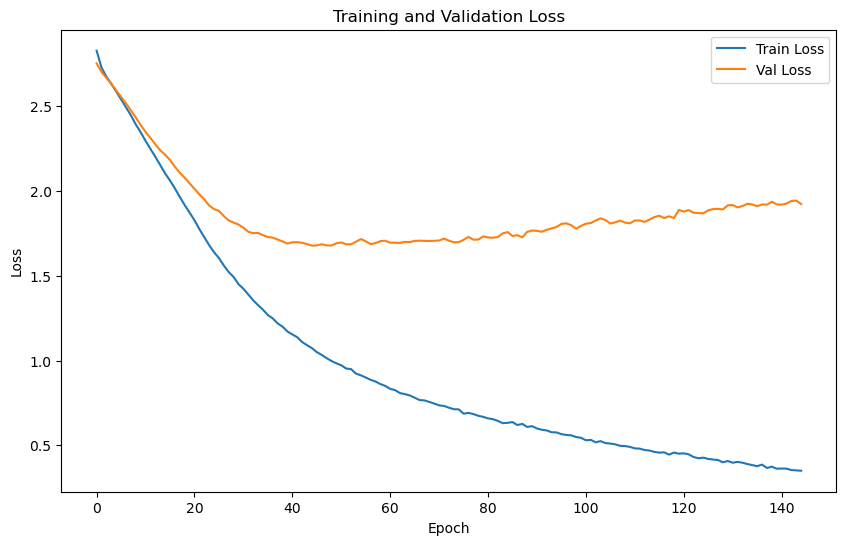

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.0153 | Test Accuracy: 41.53%


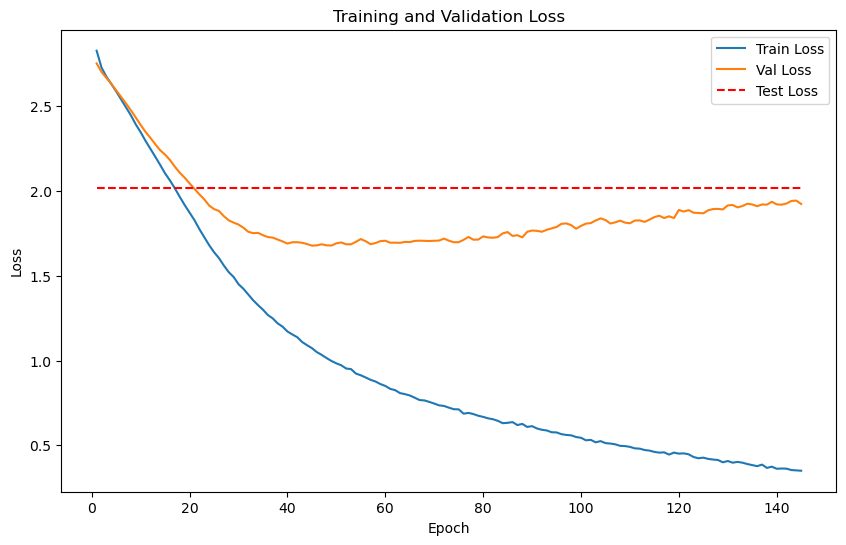

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.3388
Epoch [1/2000], Avg Train Loss: 9.3388
Epoch [1/2000], Avg Val Loss: 5.4757
Validation loss improved from inf to 5.4757. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.0451
Epoch [2/2000], Avg Train Loss: 9.0451
Epoch [2/2000], Avg Val Loss: 5.4183
Validation loss improved from 5.4757 to 5.4183. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.1200
Epoch [3/2000], Avg Train Loss: 9.1200
Epoch [3/2000], Avg Val Loss: 5.3623
Validation loss improved from 5.4183 to 5.3623. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.0989
Epoch [4/2000], Avg Train Loss: 9.0989
Epoch [4/2000], Avg Val Loss: 5.3075
Validation loss improved from 5.3623 to 5.3075. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7256
Epoch [5/2000], Avg Train Loss: 8.7256
Epoch [5/2000], Avg Val Loss: 5.2537
Validation loss improved from 5.3075 to 5.2537. Saving mode

Epoch [15/2000], Avg Val Loss: 4.7727
Validation loss improved from 4.8160 to 4.7727. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.1223
Epoch [16/2000], Avg Train Loss: 8.1223
Epoch [16/2000], Avg Val Loss: 4.7306
Validation loss improved from 4.7727 to 4.7306. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.9320
Epoch [17/2000], Avg Train Loss: 7.9320
Epoch [17/2000], Avg Val Loss: 4.6895
Validation loss improved from 4.7306 to 4.6895. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.8897
Epoch [18/2000], Avg Train Loss: 7.8897
Epoch [18/2000], Avg Val Loss: 4.6495
Validation loss improved from 4.6895 to 4.6495. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.7786
Epoch [19/2000], Avg Train Loss: 7.7786
Epoch [19/2000], Avg Val Loss: 4.6105
Validation loss improved from 4.6495 to 4.6105. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.3510
Epoch [25/2000], Avg Train Loss: 7.3510
Epoch [25/2000], Avg Val Loss: 4.3981
Validation loss improved from 4.4309 to 4.3981. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.3724
Epoch [26/2000], Avg Train Loss: 7.3724
Epoch [26/2000], Avg Val Loss: 4.3663
Validation loss improved from 4.3981 to 4.3663. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.2263
Epoch [27/2000], Avg Train Loss: 7.2263
Epoch [27/2000], Avg Val Loss: 4.3355
Validation loss improved from 4.3663 to 4.3355. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.3221
Epoch [28/2000], Avg Train Loss: 7.3221
Epoch [28/2000], Avg Val Loss: 4.3055
Validation loss improved from 4.3355 to 4.3055. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.3361
Epoch [29/2000], Avg Train Loss: 7.3361
Epoch [29/2000], Avg Val Loss: 4.2765
Validation loss improved from 4.3055 to 4.

    Batch [1/1], Train Loss: 6.3343
Epoch [43/2000], Avg Train Loss: 6.3343
Epoch [43/2000], Avg Val Loss: 3.9609
Validation loss improved from 3.9783 to 3.9609. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.4911
Epoch [44/2000], Avg Train Loss: 6.4911
Epoch [44/2000], Avg Val Loss: 3.9441
Validation loss improved from 3.9609 to 3.9441. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.2876
Epoch [45/2000], Avg Train Loss: 6.2876
Epoch [45/2000], Avg Val Loss: 3.9281
Validation loss improved from 3.9441 to 3.9281. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.3980
Epoch [46/2000], Avg Train Loss: 6.3980
Epoch [46/2000], Avg Val Loss: 3.9127
Validation loss improved from 3.9281 to 3.9127. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2770
Epoch [47/2000], Avg Train Loss: 6.2770
Epoch [47/2000], Avg Val Loss: 3.8980
Validation loss improved from 3.9127 to 3.

    Batch [1/1], Train Loss: 5.7707
Epoch [58/2000], Avg Train Loss: 5.7707
Epoch [58/2000], Avg Val Loss: 3.7716
Validation loss improved from 3.7807 to 3.7716. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.8920
Epoch [59/2000], Avg Train Loss: 5.8920
Epoch [59/2000], Avg Val Loss: 3.7628
Validation loss improved from 3.7716 to 3.7628. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.6927
Epoch [60/2000], Avg Train Loss: 5.6927
Epoch [60/2000], Avg Val Loss: 3.7544
Validation loss improved from 3.7628 to 3.7544. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.8026
Epoch [61/2000], Avg Train Loss: 5.8026
Epoch [61/2000], Avg Val Loss: 3.7464
Validation loss improved from 3.7544 to 3.7464. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6892
Epoch [62/2000], Avg Train Loss: 5.6892
Epoch [62/2000], Avg Val Loss: 3.7387
Validation loss improved from 3.7464 to 3.

    Batch [1/1], Train Loss: 5.5969
Epoch [70/2000], Avg Train Loss: 5.5969
Epoch [70/2000], Avg Val Loss: 3.6885
Validation loss improved from 3.6939 to 3.6885. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.5696
Epoch [71/2000], Avg Train Loss: 5.5696
Epoch [71/2000], Avg Val Loss: 3.6833
Validation loss improved from 3.6885 to 3.6833. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.4808
Epoch [72/2000], Avg Train Loss: 5.4808
Epoch [72/2000], Avg Val Loss: 3.6784
Validation loss improved from 3.6833 to 3.6784. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.5054
Epoch [73/2000], Avg Train Loss: 5.5054
Epoch [73/2000], Avg Val Loss: 3.6737
Validation loss improved from 3.6784 to 3.6737. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.4810
Epoch [74/2000], Avg Train Loss: 5.4810
Epoch [74/2000], Avg Val Loss: 3.6692
Validation loss improved from 3.6737 to 3.

Epoch [88/2000], Avg Val Loss: 3.6236
Validation loss improved from 3.6260 to 3.6236. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.1393
Epoch [89/2000], Avg Train Loss: 5.1393
Epoch [89/2000], Avg Val Loss: 3.6212
Validation loss improved from 3.6236 to 3.6212. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2242
Epoch [90/2000], Avg Train Loss: 5.2242
Epoch [90/2000], Avg Val Loss: 3.6189
Validation loss improved from 3.6212 to 3.6189. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.0563
Epoch [91/2000], Avg Train Loss: 5.0563
Epoch [91/2000], Avg Val Loss: 3.6167
Validation loss improved from 3.6189 to 3.6167. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0955
Epoch [92/2000], Avg Train Loss: 5.0955
Epoch [92/2000], Avg Val Loss: 3.6145
Validation loss improved from 3.6167 to 3.6145. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Trai

Epoch [98/2000], Avg Val Loss: 3.6030
Validation loss improved from 3.6048 to 3.6030. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.0189
Epoch [99/2000], Avg Train Loss: 5.0189
Epoch [99/2000], Avg Val Loss: 3.6014
Validation loss improved from 3.6030 to 3.6014. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 5.0770
Epoch [100/2000], Avg Train Loss: 5.0770
Epoch [100/2000], Avg Val Loss: 3.5997
Validation loss improved from 3.6014 to 3.5997. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 5.0553
Epoch [101/2000], Avg Train Loss: 5.0553
Epoch [101/2000], Avg Val Loss: 3.5981
Validation loss improved from 3.5997 to 3.5981. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.9974
Epoch [102/2000], Avg Train Loss: 4.9974
Epoch [102/2000], Avg Val Loss: 3.5966
Validation loss improved from 3.5981 to 3.5966. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [

    Batch [1/1], Train Loss: 4.9443
Epoch [111/2000], Avg Train Loss: 4.9443
Epoch [111/2000], Avg Val Loss: 3.5848
Validation loss improved from 3.5860 to 3.5848. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.9462
Epoch [112/2000], Avg Train Loss: 4.9462
Epoch [112/2000], Avg Val Loss: 3.5837
Validation loss improved from 3.5848 to 3.5837. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.9837
Epoch [113/2000], Avg Train Loss: 4.9837
Epoch [113/2000], Avg Val Loss: 3.5825
Validation loss improved from 3.5837 to 3.5825. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.9060
Epoch [114/2000], Avg Train Loss: 4.9060
Epoch [114/2000], Avg Val Loss: 3.5814
Validation loss improved from 3.5825 to 3.5814. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.8878
Epoch [115/2000], Avg Train Loss: 4.8878
Epoch [115/2000], Avg Val Loss: 3.5803
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8737
Epoch [128/2000], Avg Train Loss: 4.8737
Epoch [128/2000], Avg Val Loss: 3.5657
Validation loss improved from 3.5668 to 3.5657. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.8019
Epoch [129/2000], Avg Train Loss: 4.8019
Epoch [129/2000], Avg Val Loss: 3.5646
Validation loss improved from 3.5657 to 3.5646. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.8186
Epoch [130/2000], Avg Train Loss: 4.8186
Epoch [130/2000], Avg Val Loss: 3.5634
Validation loss improved from 3.5646 to 3.5634. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.8077
Epoch [131/2000], Avg Train Loss: 4.8077
Epoch [131/2000], Avg Val Loss: 3.5623
Validation loss improved from 3.5634 to 3.5623. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.8086
Epoch [132/2000], Avg Train Loss: 4.8086
Epoch [132/2000], Avg Val Loss: 3.5612
Validation loss improved fro

Epoch [141/2000], Avg Val Loss: 3.5516
Validation loss improved from 3.5527 to 3.5516. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.7175
Epoch [142/2000], Avg Train Loss: 4.7175
Epoch [142/2000], Avg Val Loss: 3.5506
Validation loss improved from 3.5516 to 3.5506. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.7480
Epoch [143/2000], Avg Train Loss: 4.7480
Epoch [143/2000], Avg Val Loss: 3.5496
Validation loss improved from 3.5506 to 3.5496. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.7297
Epoch [144/2000], Avg Train Loss: 4.7297
Epoch [144/2000], Avg Val Loss: 3.5485
Validation loss improved from 3.5496 to 3.5485. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.7466
Epoch [145/2000], Avg Train Loss: 4.7466
Epoch [145/2000], Avg Val Loss: 3.5475
Validation loss improved from 3.5485 to 3.5475. Saving model...

LOG: Epoch [146/2000] - Training
    Bat

Epoch [154/2000], Avg Val Loss: 3.5384
Validation loss improved from 3.5394 to 3.5384. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.6823
Epoch [155/2000], Avg Train Loss: 4.6823
Epoch [155/2000], Avg Val Loss: 3.5373
Validation loss improved from 3.5384 to 3.5373. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.6924
Epoch [156/2000], Avg Train Loss: 4.6924
Epoch [156/2000], Avg Val Loss: 3.5363
Validation loss improved from 3.5373 to 3.5363. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.6655
Epoch [157/2000], Avg Train Loss: 4.6655
Epoch [157/2000], Avg Val Loss: 3.5352
Validation loss improved from 3.5363 to 3.5352. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.7783
Epoch [158/2000], Avg Train Loss: 4.7783
Epoch [158/2000], Avg Val Loss: 3.5342
Validation loss improved from 3.5352 to 3.5342. Saving model...

LOG: Epoch [159/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6057
Epoch [175/2000], Avg Train Loss: 4.6057
Epoch [175/2000], Avg Val Loss: 3.5167
Validation loss improved from 3.5177 to 3.5167. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.6080
Epoch [176/2000], Avg Train Loss: 4.6080
Epoch [176/2000], Avg Val Loss: 3.5157
Validation loss improved from 3.5167 to 3.5157. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.6296
Epoch [177/2000], Avg Train Loss: 4.6296
Epoch [177/2000], Avg Val Loss: 3.5148
Validation loss improved from 3.5157 to 3.5148. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.6471
Epoch [178/2000], Avg Train Loss: 4.6471
Epoch [178/2000], Avg Val Loss: 3.5138
Validation loss improved from 3.5148 to 3.5138. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.5961
Epoch [179/2000], Avg Train Loss: 4.5961
Epoch [179/2000], Avg Val Loss: 3.5128
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5701
Epoch [186/2000], Avg Train Loss: 4.5701
Epoch [186/2000], Avg Val Loss: 3.5058
Validation loss improved from 3.5068 to 3.5058. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.5713
Epoch [187/2000], Avg Train Loss: 4.5713
Epoch [187/2000], Avg Val Loss: 3.5048
Validation loss improved from 3.5058 to 3.5048. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.6127
Epoch [188/2000], Avg Train Loss: 4.6127
Epoch [188/2000], Avg Val Loss: 3.5037
Validation loss improved from 3.5048 to 3.5037. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.6022
Epoch [189/2000], Avg Train Loss: 4.6022
Epoch [189/2000], Avg Val Loss: 3.5027
Validation loss improved from 3.5037 to 3.5027. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.5680
Epoch [190/2000], Avg Train Loss: 4.5680
Epoch [190/2000], Avg Val Loss: 3.5017
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5884
Epoch [200/2000], Avg Train Loss: 4.5884
Epoch [200/2000], Avg Val Loss: 3.4918
Validation loss improved from 3.4928 to 3.4918. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.6017
Epoch [201/2000], Avg Train Loss: 4.6017
Epoch [201/2000], Avg Val Loss: 3.4908
Validation loss improved from 3.4918 to 3.4908. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.5895
Epoch [202/2000], Avg Train Loss: 4.5895
Epoch [202/2000], Avg Val Loss: 3.4899
Validation loss improved from 3.4908 to 3.4899. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.5984
Epoch [203/2000], Avg Train Loss: 4.5984
Epoch [203/2000], Avg Val Loss: 3.4889
Validation loss improved from 3.4899 to 3.4889. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.5213
Epoch [204/2000], Avg Train Loss: 4.5213
Epoch [204/2000], Avg Val Loss: 3.4880
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5369
Epoch [217/2000], Avg Train Loss: 4.5369
Epoch [217/2000], Avg Val Loss: 3.4753
Validation loss improved from 3.4763 to 3.4753. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.4844
Epoch [218/2000], Avg Train Loss: 4.4844
Epoch [218/2000], Avg Val Loss: 3.4743
Validation loss improved from 3.4753 to 3.4743. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.5273
Epoch [219/2000], Avg Train Loss: 4.5273
Epoch [219/2000], Avg Val Loss: 3.4734
Validation loss improved from 3.4743 to 3.4734. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.4955
Epoch [220/2000], Avg Train Loss: 4.4955
Epoch [220/2000], Avg Val Loss: 3.4724
Validation loss improved from 3.4734 to 3.4724. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.5647
Epoch [221/2000], Avg Train Loss: 4.5647
Epoch [221/2000], Avg Val Loss: 3.4714
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4637
Epoch [230/2000], Avg Train Loss: 4.4637
Epoch [230/2000], Avg Val Loss: 3.4631
Validation loss improved from 3.4640 to 3.4631. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.5514
Epoch [231/2000], Avg Train Loss: 4.5514
Epoch [231/2000], Avg Val Loss: 3.4622
Validation loss improved from 3.4631 to 3.4622. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.5261
Epoch [232/2000], Avg Train Loss: 4.5261
Epoch [232/2000], Avg Val Loss: 3.4613
Validation loss improved from 3.4622 to 3.4613. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.4789
Epoch [233/2000], Avg Train Loss: 4.4789
Epoch [233/2000], Avg Val Loss: 3.4604
Validation loss improved from 3.4613 to 3.4604. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.5093
Epoch [234/2000], Avg Train Loss: 4.5093
Epoch [234/2000], Avg Val Loss: 3.4595
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4666
Epoch [244/2000], Avg Train Loss: 4.4666
Epoch [244/2000], Avg Val Loss: 3.4506
Validation loss improved from 3.4515 to 3.4506. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.4366
Epoch [245/2000], Avg Train Loss: 4.4366
Epoch [245/2000], Avg Val Loss: 3.4498
Validation loss improved from 3.4506 to 3.4498. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.4546
Epoch [246/2000], Avg Train Loss: 4.4546
Epoch [246/2000], Avg Val Loss: 3.4490
Validation loss improved from 3.4498 to 3.4490. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.4192
Epoch [247/2000], Avg Train Loss: 4.4192
Epoch [247/2000], Avg Val Loss: 3.4481
Validation loss improved from 3.4490 to 3.4481. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.4769
Epoch [248/2000], Avg Train Loss: 4.4769
Epoch [248/2000], Avg Val Loss: 3.4473
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4759
Epoch [257/2000], Avg Train Loss: 4.4759
Epoch [257/2000], Avg Val Loss: 3.4398
Validation loss improved from 3.4406 to 3.4398. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 4.4893
Epoch [258/2000], Avg Train Loss: 4.4893
Epoch [258/2000], Avg Val Loss: 3.4390
Validation loss improved from 3.4398 to 3.4390. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.4475
Epoch [259/2000], Avg Train Loss: 4.4475
Epoch [259/2000], Avg Val Loss: 3.4382
Validation loss improved from 3.4390 to 3.4382. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.4251
Epoch [260/2000], Avg Train Loss: 4.4251
Epoch [260/2000], Avg Val Loss: 3.4374
Validation loss improved from 3.4382 to 3.4374. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.4188
Epoch [261/2000], Avg Train Loss: 4.4188
Epoch [261/2000], Avg Val Loss: 3.4366
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4454
Epoch [268/2000], Avg Train Loss: 4.4454
Epoch [268/2000], Avg Val Loss: 3.4307
Validation loss improved from 3.4316 to 3.4307. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.4330
Epoch [269/2000], Avg Train Loss: 4.4330
Epoch [269/2000], Avg Val Loss: 3.4299
Validation loss improved from 3.4307 to 3.4299. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.3572
Epoch [270/2000], Avg Train Loss: 4.3572
Epoch [270/2000], Avg Val Loss: 3.4290
Validation loss improved from 3.4299 to 3.4290. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.4250
Epoch [271/2000], Avg Train Loss: 4.4250
Epoch [271/2000], Avg Val Loss: 3.4282
Validation loss improved from 3.4290 to 3.4282. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.3774
Epoch [272/2000], Avg Train Loss: 4.3774
Epoch [272/2000], Avg Val Loss: 3.4274
Validation loss improved fro

Epoch [283/2000], Avg Val Loss: 3.4186
Validation loss improved from 3.4194 to 3.4186. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.3448
Epoch [284/2000], Avg Train Loss: 4.3448
Epoch [284/2000], Avg Val Loss: 3.4178
Validation loss improved from 3.4186 to 3.4178. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.4412
Epoch [285/2000], Avg Train Loss: 4.4412
Epoch [285/2000], Avg Val Loss: 3.4170
Validation loss improved from 3.4178 to 3.4170. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.3719
Epoch [286/2000], Avg Train Loss: 4.3719
Epoch [286/2000], Avg Val Loss: 3.4162
Validation loss improved from 3.4170 to 3.4162. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.4294
Epoch [287/2000], Avg Train Loss: 4.4294
Epoch [287/2000], Avg Val Loss: 3.4155
Validation loss improved from 3.4162 to 3.4155. Saving model...

LOG: Epoch [288/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3651
Epoch [297/2000], Avg Train Loss: 4.3651
Epoch [297/2000], Avg Val Loss: 3.4083
Validation loss improved from 3.4090 to 3.4083. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.3695
Epoch [298/2000], Avg Train Loss: 4.3695
Epoch [298/2000], Avg Val Loss: 3.4076
Validation loss improved from 3.4083 to 3.4076. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.3558
Epoch [299/2000], Avg Train Loss: 4.3558
Epoch [299/2000], Avg Val Loss: 3.4069
Validation loss improved from 3.4076 to 3.4069. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.3478
Epoch [300/2000], Avg Train Loss: 4.3478
Epoch [300/2000], Avg Val Loss: 3.4062
Validation loss improved from 3.4069 to 3.4062. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.3553
Epoch [301/2000], Avg Train Loss: 4.3553
Epoch [301/2000], Avg Val Loss: 3.4055
Validation loss improved fro

Epoch [312/2000], Avg Val Loss: 3.3987
Validation loss improved from 3.3993 to 3.3987. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.3211
Epoch [313/2000], Avg Train Loss: 4.3211
Epoch [313/2000], Avg Val Loss: 3.3981
Validation loss improved from 3.3987 to 3.3981. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.3527
Epoch [314/2000], Avg Train Loss: 4.3527
Epoch [314/2000], Avg Val Loss: 3.3976
Validation loss improved from 3.3981 to 3.3976. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.2783
Epoch [315/2000], Avg Train Loss: 4.2783
Epoch [315/2000], Avg Val Loss: 3.3970
Validation loss improved from 3.3976 to 3.3970. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.3475
Epoch [316/2000], Avg Train Loss: 4.3475
Epoch [316/2000], Avg Val Loss: 3.3964
Validation loss improved from 3.3970 to 3.3964. Saving model...

LOG: Epoch [317/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2856
Epoch [329/2000], Avg Train Loss: 4.2856
Epoch [329/2000], Avg Val Loss: 3.3885
Validation loss improved from 3.3891 to 3.3885. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.3399
Epoch [330/2000], Avg Train Loss: 4.3399
Epoch [330/2000], Avg Val Loss: 3.3879
Validation loss improved from 3.3885 to 3.3879. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.3328
Epoch [331/2000], Avg Train Loss: 4.3328
Epoch [331/2000], Avg Val Loss: 3.3873
Validation loss improved from 3.3879 to 3.3873. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 4.3523
Epoch [332/2000], Avg Train Loss: 4.3523
Epoch [332/2000], Avg Val Loss: 3.3867
Validation loss improved from 3.3873 to 3.3867. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 4.3074
Epoch [333/2000], Avg Train Loss: 4.3074
Epoch [333/2000], Avg Val Loss: 3.3860
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3084
Epoch [340/2000], Avg Train Loss: 4.3084
Epoch [340/2000], Avg Val Loss: 3.3819
Validation loss improved from 3.3825 to 3.3819. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.2839
Epoch [341/2000], Avg Train Loss: 4.2839
Epoch [341/2000], Avg Val Loss: 3.3813
Validation loss improved from 3.3819 to 3.3813. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.2978
Epoch [342/2000], Avg Train Loss: 4.2978
Epoch [342/2000], Avg Val Loss: 3.3807
Validation loss improved from 3.3813 to 3.3807. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 4.2766
Epoch [343/2000], Avg Train Loss: 4.2766
Epoch [343/2000], Avg Val Loss: 3.3802
Validation loss improved from 3.3807 to 3.3802. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.2531
Epoch [344/2000], Avg Train Loss: 4.2531
Epoch [344/2000], Avg Val Loss: 3.3796
Validation loss improved fro

Epoch [354/2000], Avg Val Loss: 3.3741
Validation loss improved from 3.3746 to 3.3741. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.2810
Epoch [355/2000], Avg Train Loss: 4.2810
Epoch [355/2000], Avg Val Loss: 3.3736
Validation loss improved from 3.3741 to 3.3736. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.3163
Epoch [356/2000], Avg Train Loss: 4.3163
Epoch [356/2000], Avg Val Loss: 3.3731
Validation loss improved from 3.3736 to 3.3731. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.2797
Epoch [357/2000], Avg Train Loss: 4.2797
Epoch [357/2000], Avg Val Loss: 3.3726
Validation loss improved from 3.3731 to 3.3726. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.2650
Epoch [358/2000], Avg Train Loss: 4.2650
Epoch [358/2000], Avg Val Loss: 3.3721
Validation loss improved from 3.3726 to 3.3721. Saving model...

LOG: Epoch [359/2000] - Training
    Bat

Epoch [369/2000], Avg Val Loss: 3.3673
Validation loss improved from 3.3677 to 3.3673. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 4.2531
Epoch [370/2000], Avg Train Loss: 4.2531
Epoch [370/2000], Avg Val Loss: 3.3669
Validation loss improved from 3.3673 to 3.3669. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 4.2798
Epoch [371/2000], Avg Train Loss: 4.2798
Epoch [371/2000], Avg Val Loss: 3.3665
Validation loss improved from 3.3669 to 3.3665. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.2450
Epoch [372/2000], Avg Train Loss: 4.2450
Epoch [372/2000], Avg Val Loss: 3.3660
Validation loss improved from 3.3665 to 3.3660. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.2276
Epoch [373/2000], Avg Train Loss: 4.2276
Epoch [373/2000], Avg Val Loss: 3.3657
Validation loss improved from 3.3660 to 3.3657. Saving model...

LOG: Epoch [374/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2182
Epoch [384/2000], Avg Train Loss: 4.2182
Epoch [384/2000], Avg Val Loss: 3.3611
Validation loss improved from 3.3615 to 3.3611. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.2283
Epoch [385/2000], Avg Train Loss: 4.2283
Epoch [385/2000], Avg Val Loss: 3.3608
Validation loss improved from 3.3611 to 3.3608. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.2293
Epoch [386/2000], Avg Train Loss: 4.2293
Epoch [386/2000], Avg Val Loss: 3.3604
Validation loss improved from 3.3608 to 3.3604. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.2279
Epoch [387/2000], Avg Train Loss: 4.2279
Epoch [387/2000], Avg Val Loss: 3.3600
Validation loss improved from 3.3604 to 3.3600. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.2419
Epoch [388/2000], Avg Train Loss: 4.2419
Epoch [388/2000], Avg Val Loss: 3.3597
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2305
Epoch [400/2000], Avg Train Loss: 4.2305
Epoch [400/2000], Avg Val Loss: 3.3549
Validation loss improved from 3.3553 to 3.3549. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.2738
Epoch [401/2000], Avg Train Loss: 4.2738
Epoch [401/2000], Avg Val Loss: 3.3545
Validation loss improved from 3.3549 to 3.3545. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.1864
Epoch [402/2000], Avg Train Loss: 4.1864
Epoch [402/2000], Avg Val Loss: 3.3541
Validation loss improved from 3.3545 to 3.3541. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.2155
Epoch [403/2000], Avg Train Loss: 4.2155
Epoch [403/2000], Avg Val Loss: 3.3538
Validation loss improved from 3.3541 to 3.3538. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.2175
Epoch [404/2000], Avg Train Loss: 4.2175
Epoch [404/2000], Avg Val Loss: 3.3535
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2218
Epoch [413/2000], Avg Train Loss: 4.2218
Epoch [413/2000], Avg Val Loss: 3.3503
Validation loss improved from 3.3507 to 3.3503. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.1926
Epoch [414/2000], Avg Train Loss: 4.1926
Epoch [414/2000], Avg Val Loss: 3.3500
Validation loss improved from 3.3503 to 3.3500. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.2062
Epoch [415/2000], Avg Train Loss: 4.2062
Epoch [415/2000], Avg Val Loss: 3.3497
Validation loss improved from 3.3500 to 3.3497. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.1342
Epoch [416/2000], Avg Train Loss: 4.1342
Epoch [416/2000], Avg Val Loss: 3.3494
Validation loss improved from 3.3497 to 3.3494. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.1950
Epoch [417/2000], Avg Train Loss: 4.1950
Epoch [417/2000], Avg Val Loss: 3.3490
Validation loss improved fro

Epoch [427/2000], Avg Val Loss: 3.3462
Validation loss improved from 3.3464 to 3.3462. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.1690
Epoch [428/2000], Avg Train Loss: 4.1690
Epoch [428/2000], Avg Val Loss: 3.3459
Validation loss improved from 3.3462 to 3.3459. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.2376
Epoch [429/2000], Avg Train Loss: 4.2376
Epoch [429/2000], Avg Val Loss: 3.3456
Validation loss improved from 3.3459 to 3.3456. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.2177
Epoch [430/2000], Avg Train Loss: 4.2177
Epoch [430/2000], Avg Val Loss: 3.3453
Validation loss improved from 3.3456 to 3.3453. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.2051
Epoch [431/2000], Avg Train Loss: 4.2051
Epoch [431/2000], Avg Val Loss: 3.3450
Validation loss improved from 3.3453 to 3.3450. Saving model...

LOG: Epoch [432/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1680
Epoch [443/2000], Avg Train Loss: 4.1680
Epoch [443/2000], Avg Val Loss: 3.3412
Validation loss improved from 3.3415 to 3.3412. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.1383
Epoch [444/2000], Avg Train Loss: 4.1383
Epoch [444/2000], Avg Val Loss: 3.3409
Validation loss improved from 3.3412 to 3.3409. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.1831
Epoch [445/2000], Avg Train Loss: 4.1831
Epoch [445/2000], Avg Val Loss: 3.3406
Validation loss improved from 3.3409 to 3.3406. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.2093
Epoch [446/2000], Avg Train Loss: 4.2093
Epoch [446/2000], Avg Val Loss: 3.3404
Validation loss improved from 3.3406 to 3.3404. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.1593
Epoch [447/2000], Avg Train Loss: 4.1593
Epoch [447/2000], Avg Val Loss: 3.3402
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1811
Epoch [458/2000], Avg Train Loss: 4.1811
Epoch [458/2000], Avg Val Loss: 3.3377
Validation loss improved from 3.3380 to 3.3377. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.1988
Epoch [459/2000], Avg Train Loss: 4.1988
Epoch [459/2000], Avg Val Loss: 3.3375
Validation loss improved from 3.3377 to 3.3375. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.2207
Epoch [460/2000], Avg Train Loss: 4.2207
Epoch [460/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3375 to 3.3373. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.1663
Epoch [461/2000], Avg Train Loss: 4.1663
Epoch [461/2000], Avg Val Loss: 3.3370
Validation loss improved from 3.3373 to 3.3370. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.1353
Epoch [462/2000], Avg Train Loss: 4.1353
Epoch [462/2000], Avg Val Loss: 3.3368
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1507
Epoch [470/2000], Avg Train Loss: 4.1507
Epoch [470/2000], Avg Val Loss: 3.3344
Validation loss improved from 3.3347 to 3.3344. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.1709
Epoch [471/2000], Avg Train Loss: 4.1709
Epoch [471/2000], Avg Val Loss: 3.3341
Validation loss improved from 3.3344 to 3.3341. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.1058
Epoch [472/2000], Avg Train Loss: 4.1058
Epoch [472/2000], Avg Val Loss: 3.3338
Validation loss improved from 3.3341 to 3.3338. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.1712
Epoch [473/2000], Avg Train Loss: 4.1712
Epoch [473/2000], Avg Val Loss: 3.3335
Validation loss improved from 3.3338 to 3.3335. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.1707
Epoch [474/2000], Avg Train Loss: 4.1707
Epoch [474/2000], Avg Val Loss: 3.3331
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0994
Epoch [480/2000], Avg Train Loss: 4.0994
Epoch [480/2000], Avg Val Loss: 3.3312
Validation loss improved from 3.3315 to 3.3312. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.1415
Epoch [481/2000], Avg Train Loss: 4.1415
Epoch [481/2000], Avg Val Loss: 3.3309
Validation loss improved from 3.3312 to 3.3309. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.1474
Epoch [482/2000], Avg Train Loss: 4.1474
Epoch [482/2000], Avg Val Loss: 3.3307
Validation loss improved from 3.3309 to 3.3307. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.1463
Epoch [483/2000], Avg Train Loss: 4.1463
Epoch [483/2000], Avg Val Loss: 3.3305
Validation loss improved from 3.3307 to 3.3305. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 4.0729
Epoch [484/2000], Avg Train Loss: 4.0729
Epoch [484/2000], Avg Val Loss: 3.3302
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1354
Epoch [493/2000], Avg Train Loss: 4.1354
Epoch [493/2000], Avg Val Loss: 3.3283
Validation loss improved from 3.3285 to 3.3283. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.0938
Epoch [494/2000], Avg Train Loss: 4.0938
Epoch [494/2000], Avg Val Loss: 3.3281
Validation loss improved from 3.3283 to 3.3281. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.1087
Epoch [495/2000], Avg Train Loss: 4.1087
Epoch [495/2000], Avg Val Loss: 3.3279
Validation loss improved from 3.3281 to 3.3279. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.1151
Epoch [496/2000], Avg Train Loss: 4.1151
Epoch [496/2000], Avg Val Loss: 3.3277
Validation loss improved from 3.3279 to 3.3277. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.0887
Epoch [497/2000], Avg Train Loss: 4.0887
Epoch [497/2000], Avg Val Loss: 3.3274
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0765
Epoch [508/2000], Avg Train Loss: 4.0765
Epoch [508/2000], Avg Val Loss: 3.3249
Validation loss improved from 3.3252 to 3.3249. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.1200
Epoch [509/2000], Avg Train Loss: 4.1200
Epoch [509/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3249 to 3.3247. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 4.1338
Epoch [510/2000], Avg Train Loss: 4.1338
Epoch [510/2000], Avg Val Loss: 3.3244
Validation loss improved from 3.3247 to 3.3244. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.0942
Epoch [511/2000], Avg Train Loss: 4.0942
Epoch [511/2000], Avg Val Loss: 3.3242
Validation loss improved from 3.3244 to 3.3242. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.0956
Epoch [512/2000], Avg Train Loss: 4.0956
Epoch [512/2000], Avg Val Loss: 3.3239
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1006
Epoch [520/2000], Avg Train Loss: 4.1006
Epoch [520/2000], Avg Val Loss: 3.3225
Validation loss improved from 3.3226 to 3.3225. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.0924
Epoch [521/2000], Avg Train Loss: 4.0924
Epoch [521/2000], Avg Val Loss: 3.3224
Validation loss improved from 3.3225 to 3.3224. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.0780
Epoch [522/2000], Avg Train Loss: 4.0780
Epoch [522/2000], Avg Val Loss: 3.3223
Validation loss improved from 3.3224 to 3.3223. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.0807
Epoch [523/2000], Avg Train Loss: 4.0807
Epoch [523/2000], Avg Val Loss: 3.3222
Validation loss improved from 3.3223 to 3.3222. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.0902
Epoch [524/2000], Avg Train Loss: 4.0902
Epoch [524/2000], Avg Val Loss: 3.3221
Validation loss improved fro

Epoch [537/2000], Avg Val Loss: 3.3212
Validation loss improved from 3.3212 to 3.3212. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.0704
Epoch [538/2000], Avg Train Loss: 4.0704
Epoch [538/2000], Avg Val Loss: 3.3211
Validation loss improved from 3.3212 to 3.3211. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.0666
Epoch [539/2000], Avg Train Loss: 4.0666
Epoch [539/2000], Avg Val Loss: 3.3211
Validation loss improved from 3.3211 to 3.3211. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.1048
Epoch [540/2000], Avg Train Loss: 4.1048
Epoch [540/2000], Avg Val Loss: 3.3210
Validation loss improved from 3.3211 to 3.3210. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 4.1338
Epoch [541/2000], Avg Train Loss: 4.1338
Epoch [541/2000], Avg Val Loss: 3.3210
Validation loss improved from 3.3210 to 3.3210. Saving model...

LOG: Epoch [542/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0350
Epoch [548/2000], Avg Train Loss: 4.0350
Epoch [548/2000], Avg Val Loss: 3.3212
Validation loss did not improve. Patience: 7/100

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.1029
Epoch [549/2000], Avg Train Loss: 4.1029
Epoch [549/2000], Avg Val Loss: 3.3211
Validation loss did not improve. Patience: 8/100

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.0829
Epoch [550/2000], Avg Train Loss: 4.0829
Epoch [550/2000], Avg Val Loss: 3.3211
Validation loss did not improve. Patience: 9/100

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.0929
Epoch [551/2000], Avg Train Loss: 4.0929
Epoch [551/2000], Avg Val Loss: 3.3211
Validation loss did not improve. Patience: 10/100

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.0999
Epoch [552/2000], Avg Train Loss: 4.0999
Epoch [552/2000], Avg Val Loss: 3.3210
Validation loss improved from 3.3210 to 3.3210. Saving model...

LOG: Epoch [553/2000] 

Epoch [560/2000], Avg Val Loss: 3.3200
Validation loss improved from 3.3201 to 3.3200. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.0475
Epoch [561/2000], Avg Train Loss: 4.0475
Epoch [561/2000], Avg Val Loss: 3.3198
Validation loss improved from 3.3200 to 3.3198. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.0808
Epoch [562/2000], Avg Train Loss: 4.0808
Epoch [562/2000], Avg Val Loss: 3.3197
Validation loss improved from 3.3198 to 3.3197. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.0628
Epoch [563/2000], Avg Train Loss: 4.0628
Epoch [563/2000], Avg Val Loss: 3.3196
Validation loss improved from 3.3197 to 3.3196. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.0486
Epoch [564/2000], Avg Train Loss: 4.0486
Epoch [564/2000], Avg Val Loss: 3.3194
Validation loss improved from 3.3196 to 3.3194. Saving model...

LOG: Epoch [565/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0396
Epoch [579/2000], Avg Train Loss: 4.0396
Epoch [579/2000], Avg Val Loss: 3.3165
Validation loss improved from 3.3167 to 3.3165. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.0338
Epoch [580/2000], Avg Train Loss: 4.0338
Epoch [580/2000], Avg Val Loss: 3.3163
Validation loss improved from 3.3165 to 3.3163. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.0499
Epoch [581/2000], Avg Train Loss: 4.0499
Epoch [581/2000], Avg Val Loss: 3.3161
Validation loss improved from 3.3163 to 3.3161. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.0235
Epoch [582/2000], Avg Train Loss: 4.0235
Epoch [582/2000], Avg Val Loss: 3.3159
Validation loss improved from 3.3161 to 3.3159. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.0321
Epoch [583/2000], Avg Train Loss: 4.0321
Epoch [583/2000], Avg Val Loss: 3.3157
Validation loss improved fro

Epoch [588/2000], Avg Val Loss: 3.3147
Validation loss improved from 3.3149 to 3.3147. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.0391
Epoch [589/2000], Avg Train Loss: 4.0391
Epoch [589/2000], Avg Val Loss: 3.3146
Validation loss improved from 3.3147 to 3.3146. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.0546
Epoch [590/2000], Avg Train Loss: 4.0546
Epoch [590/2000], Avg Val Loss: 3.3145
Validation loss improved from 3.3146 to 3.3145. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.0128
Epoch [591/2000], Avg Train Loss: 4.0128
Epoch [591/2000], Avg Val Loss: 3.3144
Validation loss improved from 3.3145 to 3.3144. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.0546
Epoch [592/2000], Avg Train Loss: 4.0546
Epoch [592/2000], Avg Val Loss: 3.3143
Validation loss improved from 3.3144 to 3.3143. Saving model...

LOG: Epoch [593/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0562
Epoch [602/2000], Avg Train Loss: 4.0562
Epoch [602/2000], Avg Val Loss: 3.3127
Validation loss improved from 3.3129 to 3.3127. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.0248
Epoch [603/2000], Avg Train Loss: 4.0248
Epoch [603/2000], Avg Val Loss: 3.3125
Validation loss improved from 3.3127 to 3.3125. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.0496
Epoch [604/2000], Avg Train Loss: 4.0496
Epoch [604/2000], Avg Val Loss: 3.3124
Validation loss improved from 3.3125 to 3.3124. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.0138
Epoch [605/2000], Avg Train Loss: 4.0138
Epoch [605/2000], Avg Val Loss: 3.3123
Validation loss improved from 3.3124 to 3.3123. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.0056
Epoch [606/2000], Avg Train Loss: 4.0056
Epoch [606/2000], Avg Val Loss: 3.3122
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0077
Epoch [624/2000], Avg Train Loss: 4.0077
Epoch [624/2000], Avg Val Loss: 3.3103
Validation loss improved from 3.3103 to 3.3103. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.0492
Epoch [625/2000], Avg Train Loss: 4.0492
Epoch [625/2000], Avg Val Loss: 3.3102
Validation loss improved from 3.3103 to 3.3102. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.9948
Epoch [626/2000], Avg Train Loss: 3.9948
Epoch [626/2000], Avg Val Loss: 3.3100
Validation loss improved from 3.3102 to 3.3100. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.0300
Epoch [627/2000], Avg Train Loss: 4.0300
Epoch [627/2000], Avg Val Loss: 3.3099
Validation loss improved from 3.3100 to 3.3099. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.9795
Epoch [628/2000], Avg Train Loss: 3.9795
Epoch [628/2000], Avg Val Loss: 3.3098
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9816
Epoch [633/2000], Avg Train Loss: 3.9816
Epoch [633/2000], Avg Val Loss: 3.3088
Validation loss improved from 3.3090 to 3.3088. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.9877
Epoch [634/2000], Avg Train Loss: 3.9877
Epoch [634/2000], Avg Val Loss: 3.3087
Validation loss improved from 3.3088 to 3.3087. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.0467
Epoch [635/2000], Avg Train Loss: 4.0467
Epoch [635/2000], Avg Val Loss: 3.3086
Validation loss improved from 3.3087 to 3.3086. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.0302
Epoch [636/2000], Avg Train Loss: 4.0302
Epoch [636/2000], Avg Val Loss: 3.3085
Validation loss improved from 3.3086 to 3.3085. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 4.0594
Epoch [637/2000], Avg Train Loss: 4.0594
Epoch [637/2000], Avg Val Loss: 3.3085
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9641
Epoch [645/2000], Avg Train Loss: 3.9641
Epoch [645/2000], Avg Val Loss: 3.3084
Validation loss did not improve. Patience: 5/100

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 3.9724
Epoch [646/2000], Avg Train Loss: 3.9724
Epoch [646/2000], Avg Val Loss: 3.3085
Validation loss did not improve. Patience: 6/100

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.0098
Epoch [647/2000], Avg Train Loss: 4.0098
Epoch [647/2000], Avg Val Loss: 3.3085
Validation loss did not improve. Patience: 7/100

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 4.0099
Epoch [648/2000], Avg Train Loss: 4.0099
Epoch [648/2000], Avg Val Loss: 3.3086
Validation loss did not improve. Patience: 8/100

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.9876
Epoch [649/2000], Avg Train Loss: 3.9876
Epoch [649/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 9/100

LOG: Epoch [650/2000] - Training
    B

    Batch [1/1], Train Loss: 3.9734
Epoch [663/2000], Avg Train Loss: 3.9734
Epoch [663/2000], Avg Val Loss: 3.3088
Validation loss did not improve. Patience: 23/100

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.9891
Epoch [664/2000], Avg Train Loss: 3.9891
Epoch [664/2000], Avg Val Loss: 3.3088
Validation loss did not improve. Patience: 24/100

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.9953
Epoch [665/2000], Avg Train Loss: 3.9953
Epoch [665/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 25/100

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.9967
Epoch [666/2000], Avg Train Loss: 3.9967
Epoch [666/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 26/100

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.9607
Epoch [667/2000], Avg Train Loss: 3.9607
Epoch [667/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 27/100

LOG: Epoch [668/2000] - Training


Epoch [673/2000], Avg Val Loss: 3.3084
Validation loss did not improve. Patience: 33/100

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.9475
Epoch [674/2000], Avg Train Loss: 3.9475
Epoch [674/2000], Avg Val Loss: 3.3083
Validation loss did not improve. Patience: 34/100

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.9744
Epoch [675/2000], Avg Train Loss: 3.9744
Epoch [675/2000], Avg Val Loss: 3.3083
Validation loss improved from 3.3083 to 3.3083. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.9819
Epoch [676/2000], Avg Train Loss: 3.9819
Epoch [676/2000], Avg Val Loss: 3.3082
Validation loss improved from 3.3083 to 3.3082. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.9660
Epoch [677/2000], Avg Train Loss: 3.9660
Epoch [677/2000], Avg Val Loss: 3.3081
Validation loss improved from 3.3082 to 3.3081. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.9291

    Batch [1/1], Train Loss: 3.9282
Epoch [681/2000], Avg Train Loss: 3.9282
Epoch [681/2000], Avg Val Loss: 3.3075
Validation loss improved from 3.3077 to 3.3075. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 4.0191
Epoch [682/2000], Avg Train Loss: 4.0191
Epoch [682/2000], Avg Val Loss: 3.3073
Validation loss improved from 3.3075 to 3.3073. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.9936
Epoch [683/2000], Avg Train Loss: 3.9936
Epoch [683/2000], Avg Val Loss: 3.3071
Validation loss improved from 3.3073 to 3.3071. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.9677
Epoch [684/2000], Avg Train Loss: 3.9677
Epoch [684/2000], Avg Val Loss: 3.3069
Validation loss improved from 3.3071 to 3.3069. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.0272
Epoch [685/2000], Avg Train Loss: 4.0272
Epoch [685/2000], Avg Val Loss: 3.3067
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9817
Epoch [701/2000], Avg Train Loss: 3.9817
Epoch [701/2000], Avg Val Loss: 3.3051
Validation loss improved from 3.3051 to 3.3051. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.9195
Epoch [702/2000], Avg Train Loss: 3.9195
Epoch [702/2000], Avg Val Loss: 3.3050
Validation loss improved from 3.3051 to 3.3050. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.0052
Epoch [703/2000], Avg Train Loss: 4.0052
Epoch [703/2000], Avg Val Loss: 3.3050
Validation loss improved from 3.3050 to 3.3050. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.9763
Epoch [704/2000], Avg Train Loss: 3.9763
Epoch [704/2000], Avg Val Loss: 3.3050
Validation loss improved from 3.3050 to 3.3050. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.9543
Epoch [705/2000], Avg Train Loss: 3.9543
Epoch [705/2000], Avg Val Loss: 3.3049
Validation loss improved fro

Epoch [712/2000], Avg Val Loss: 3.3045
Validation loss improved from 3.3045 to 3.3045. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 4.0034
Epoch [713/2000], Avg Train Loss: 4.0034
Epoch [713/2000], Avg Val Loss: 3.3044
Validation loss improved from 3.3045 to 3.3044. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.9743
Epoch [714/2000], Avg Train Loss: 3.9743
Epoch [714/2000], Avg Val Loss: 3.3044
Validation loss improved from 3.3044 to 3.3044. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.9477
Epoch [715/2000], Avg Train Loss: 3.9477
Epoch [715/2000], Avg Val Loss: 3.3044
Validation loss did not improve. Patience: 1/100

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.9459
Epoch [716/2000], Avg Train Loss: 3.9459
Epoch [716/2000], Avg Val Loss: 3.3043
Validation loss improved from 3.3044 to 3.3043. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 3.9444
Epoch [721/2000], Avg Train Loss: 3.9444
Epoch [721/2000], Avg Val Loss: 3.3042
Validation loss improved from 3.3042 to 3.3042. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.9539
Epoch [722/2000], Avg Train Loss: 3.9539
Epoch [722/2000], Avg Val Loss: 3.3041
Validation loss improved from 3.3042 to 3.3041. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.9295
Epoch [723/2000], Avg Train Loss: 3.9295
Epoch [723/2000], Avg Val Loss: 3.3040
Validation loss improved from 3.3041 to 3.3040. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.9673
Epoch [724/2000], Avg Train Loss: 3.9673
Epoch [724/2000], Avg Val Loss: 3.3038
Validation loss improved from 3.3040 to 3.3038. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.9060
Epoch [725/2000], Avg Train Loss: 3.9060
Epoch [725/2000], Avg Val Loss: 3.3036
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9462
Epoch [743/2000], Avg Train Loss: 3.9462
Epoch [743/2000], Avg Val Loss: 3.3014
Validation loss improved from 3.3014 to 3.3014. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.9386
Epoch [744/2000], Avg Train Loss: 3.9386
Epoch [744/2000], Avg Val Loss: 3.3014
Validation loss did not improve. Patience: 1/100

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.8567
Epoch [745/2000], Avg Train Loss: 3.8567
Epoch [745/2000], Avg Val Loss: 3.3015
Validation loss did not improve. Patience: 2/100

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.9344
Epoch [746/2000], Avg Train Loss: 3.9344
Epoch [746/2000], Avg Val Loss: 3.3015
Validation loss did not improve. Patience: 3/100

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.9665
Epoch [747/2000], Avg Train Loss: 3.9665
Epoch [747/2000], Avg Val Loss: 3.3016
Validation loss did not improve. Patience: 4/100

LOG: Epoch [748/2000] -

Epoch [754/2000], Avg Val Loss: 3.3017
Validation loss did not improve. Patience: 11/100

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.9004
Epoch [755/2000], Avg Train Loss: 3.9004
Epoch [755/2000], Avg Val Loss: 3.3018
Validation loss did not improve. Patience: 12/100

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.9039
Epoch [756/2000], Avg Train Loss: 3.9039
Epoch [756/2000], Avg Val Loss: 3.3018
Validation loss did not improve. Patience: 13/100

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.9232
Epoch [757/2000], Avg Train Loss: 3.9232
Epoch [757/2000], Avg Val Loss: 3.3017
Validation loss did not improve. Patience: 14/100

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.9116
Epoch [758/2000], Avg Train Loss: 3.9116
Epoch [758/2000], Avg Val Loss: 3.3017
Validation loss did not improve. Patience: 15/100

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.9260
Epoch [759/2000], Avg Train Loss: 3.9260


    Batch [1/1], Train Loss: 3.9018
Epoch [763/2000], Avg Train Loss: 3.9018
Epoch [763/2000], Avg Val Loss: 3.3019
Validation loss did not improve. Patience: 20/100

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.9592
Epoch [764/2000], Avg Train Loss: 3.9592
Epoch [764/2000], Avg Val Loss: 3.3019
Validation loss did not improve. Patience: 21/100

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.9250
Epoch [765/2000], Avg Train Loss: 3.9250
Epoch [765/2000], Avg Val Loss: 3.3020
Validation loss did not improve. Patience: 22/100

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 3.9336
Epoch [766/2000], Avg Train Loss: 3.9336
Epoch [766/2000], Avg Val Loss: 3.3019
Validation loss did not improve. Patience: 23/100

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.9120
Epoch [767/2000], Avg Train Loss: 3.9120
Epoch [767/2000], Avg Val Loss: 3.3020
Validation loss did not improve. Patience: 24/100

LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 3.9411
Epoch [788/2000], Avg Train Loss: 3.9411
Epoch [788/2000], Avg Val Loss: 3.3009
Validation loss did not improve. Patience: 4/100

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.8848
Epoch [789/2000], Avg Train Loss: 3.8848
Epoch [789/2000], Avg Val Loss: 3.3010
Validation loss did not improve. Patience: 5/100

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.9410
Epoch [790/2000], Avg Train Loss: 3.9410
Epoch [790/2000], Avg Val Loss: 3.3011
Validation loss did not improve. Patience: 6/100

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.9176
Epoch [791/2000], Avg Train Loss: 3.9176
Epoch [791/2000], Avg Val Loss: 3.3012
Validation loss did not improve. Patience: 7/100

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.8733
Epoch [792/2000], Avg Train Loss: 3.8733
Epoch [792/2000], Avg Val Loss: 3.3013
Validation loss did not improve. Patience: 8/100

LOG: Epoch [793/2000] - Training
    B

    Batch [1/1], Train Loss: 3.8870
Epoch [801/2000], Avg Train Loss: 3.8870
Epoch [801/2000], Avg Val Loss: 3.3016
Validation loss did not improve. Patience: 17/100

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.8929
Epoch [802/2000], Avg Train Loss: 3.8929
Epoch [802/2000], Avg Val Loss: 3.3015
Validation loss did not improve. Patience: 18/100

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.8586
Epoch [803/2000], Avg Train Loss: 3.8586
Epoch [803/2000], Avg Val Loss: 3.3014
Validation loss did not improve. Patience: 19/100

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.9095
Epoch [804/2000], Avg Train Loss: 3.9095
Epoch [804/2000], Avg Val Loss: 3.3013
Validation loss did not improve. Patience: 20/100

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.8748
Epoch [805/2000], Avg Train Loss: 3.8748
Epoch [805/2000], Avg Val Loss: 3.3013
Validation loss did not improve. Patience: 21/100

LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 3.8606
Epoch [831/2000], Avg Train Loss: 3.8606
Epoch [831/2000], Avg Val Loss: 3.3020
Validation loss did not improve. Patience: 47/100

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.8697
Epoch [832/2000], Avg Train Loss: 3.8697
Epoch [832/2000], Avg Val Loss: 3.3020
Validation loss did not improve. Patience: 48/100

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.8318
Epoch [833/2000], Avg Train Loss: 3.8318
Epoch [833/2000], Avg Val Loss: 3.3020
Validation loss did not improve. Patience: 49/100

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.8563
Epoch [834/2000], Avg Train Loss: 3.8563
Epoch [834/2000], Avg Val Loss: 3.3019
Validation loss did not improve. Patience: 50/100

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.8503
Epoch [835/2000], Avg Train Loss: 3.8503
Epoch [835/2000], Avg Val Loss: 3.3018
Validation loss did not improve. Patience: 51/100

LOG: Epoch [836/2000] - Training


Epoch [842/2000], Avg Val Loss: 3.3011
Validation loss did not improve. Patience: 58/100

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [843/2000], Avg Train Loss: 3.8294
Epoch [843/2000], Avg Val Loss: 3.3010
Validation loss did not improve. Patience: 59/100

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.8549
Epoch [844/2000], Avg Train Loss: 3.8549
Epoch [844/2000], Avg Val Loss: 3.3009
Validation loss did not improve. Patience: 60/100

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 3.8708
Epoch [845/2000], Avg Train Loss: 3.8708
Epoch [845/2000], Avg Val Loss: 3.3008
Validation loss did not improve. Patience: 61/100

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 3.8580
Epoch [846/2000], Avg Train Loss: 3.8580
Epoch [846/2000], Avg Val Loss: 3.3007
Validation loss did not improve. Patience: 62/100

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.8624
Epoch [847/2000], Avg Train Loss: 3.8624


Epoch [871/2000], Avg Val Loss: 3.2978
Validation loss improved from 3.2979 to 3.2978. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.8614
Epoch [872/2000], Avg Train Loss: 3.8614
Epoch [872/2000], Avg Val Loss: 3.2976
Validation loss improved from 3.2978 to 3.2976. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.8281
Epoch [873/2000], Avg Train Loss: 3.8281
Epoch [873/2000], Avg Val Loss: 3.2974
Validation loss improved from 3.2976 to 3.2974. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.8504
Epoch [874/2000], Avg Train Loss: 3.8504
Epoch [874/2000], Avg Val Loss: 3.2973
Validation loss improved from 3.2974 to 3.2973. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.8321
Epoch [875/2000], Avg Train Loss: 3.8321
Epoch [875/2000], Avg Val Loss: 3.2972
Validation loss improved from 3.2973 to 3.2972. Saving model...

LOG: Epoch [876/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7943
Epoch [883/2000], Avg Train Loss: 3.7943
Epoch [883/2000], Avg Val Loss: 3.2969
Validation loss did not improve. Patience: 3/100

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.8101
Epoch [884/2000], Avg Train Loss: 3.8101
Epoch [884/2000], Avg Val Loss: 3.2968
Validation loss improved from 3.2969 to 3.2968. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.8205
Epoch [885/2000], Avg Train Loss: 3.8205
Epoch [885/2000], Avg Val Loss: 3.2967
Validation loss improved from 3.2968 to 3.2967. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.8059
Epoch [886/2000], Avg Train Loss: 3.8059
Epoch [886/2000], Avg Val Loss: 3.2966
Validation loss improved from 3.2967 to 3.2966. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.8204
Epoch [887/2000], Avg Train Loss: 3.8204
Epoch [887/2000], Avg Val Loss: 3.2964
Validation loss improved from 3.2966 to 3.2

    Batch [1/1], Train Loss: 3.8028
Epoch [916/2000], Avg Train Loss: 3.8028
Epoch [916/2000], Avg Val Loss: 3.2969
Validation loss did not improve. Patience: 24/100

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.8262
Epoch [917/2000], Avg Train Loss: 3.8262
Epoch [917/2000], Avg Val Loss: 3.2970
Validation loss did not improve. Patience: 25/100

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 3.8557
Epoch [918/2000], Avg Train Loss: 3.8557
Epoch [918/2000], Avg Val Loss: 3.2970
Validation loss did not improve. Patience: 26/100

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 3.8120
Epoch [919/2000], Avg Train Loss: 3.8120
Epoch [919/2000], Avg Val Loss: 3.2970
Validation loss did not improve. Patience: 27/100

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 3.8292
Epoch [920/2000], Avg Train Loss: 3.8292
Epoch [920/2000], Avg Val Loss: 3.2971
Validation loss did not improve. Patience: 28/100

LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 3.8057
Epoch [931/2000], Avg Train Loss: 3.8057
Epoch [931/2000], Avg Val Loss: 3.2957
Validation loss improved from 3.2958 to 3.2957. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 3.7978
Epoch [932/2000], Avg Train Loss: 3.7978
Epoch [932/2000], Avg Val Loss: 3.2956
Validation loss improved from 3.2957 to 3.2956. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.8632
Epoch [933/2000], Avg Train Loss: 3.8632
Epoch [933/2000], Avg Val Loss: 3.2956
Validation loss improved from 3.2956 to 3.2956. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.8023
Epoch [934/2000], Avg Train Loss: 3.8023
Epoch [934/2000], Avg Val Loss: 3.2956
Validation loss did not improve. Patience: 1/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.7966
Epoch [935/2000], Avg Train Loss: 3.7966
Epoch [935/2000], Avg Val Loss: 3.2956
Validation loss improved from 3.2956 to 3.2

Epoch [953/2000], Avg Val Loss: 3.2926
Validation loss improved from 3.2928 to 3.2926. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 3.7811
Epoch [954/2000], Avg Train Loss: 3.7811
Epoch [954/2000], Avg Val Loss: 3.2923
Validation loss improved from 3.2926 to 3.2923. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 3.7727
Epoch [955/2000], Avg Train Loss: 3.7727
Epoch [955/2000], Avg Val Loss: 3.2922
Validation loss improved from 3.2923 to 3.2922. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 3.8164
Epoch [956/2000], Avg Train Loss: 3.8164
Epoch [956/2000], Avg Val Loss: 3.2921
Validation loss improved from 3.2922 to 3.2921. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.7509
Epoch [957/2000], Avg Train Loss: 3.7509
Epoch [957/2000], Avg Val Loss: 3.2920
Validation loss improved from 3.2921 to 3.2920. Saving model...

LOG: Epoch [958/2000] - Training
    Bat

Epoch [975/2000], Avg Val Loss: 3.2888
Validation loss improved from 3.2890 to 3.2888. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.7689
Epoch [976/2000], Avg Train Loss: 3.7689
Epoch [976/2000], Avg Val Loss: 3.2887
Validation loss improved from 3.2888 to 3.2887. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.7238
Epoch [977/2000], Avg Train Loss: 3.7238
Epoch [977/2000], Avg Val Loss: 3.2886
Validation loss improved from 3.2887 to 3.2886. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.8314
Epoch [978/2000], Avg Train Loss: 3.8314
Epoch [978/2000], Avg Val Loss: 3.2885
Validation loss improved from 3.2886 to 3.2885. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.7426
Epoch [979/2000], Avg Train Loss: 3.7426
Epoch [979/2000], Avg Val Loss: 3.2884
Validation loss improved from 3.2885 to 3.2884. Saving model...

LOG: Epoch [980/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7981
Epoch [999/2000], Avg Train Loss: 3.7981
Epoch [999/2000], Avg Val Loss: 3.2872
Validation loss improved from 3.2873 to 3.2872. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 3.7479
Epoch [1000/2000], Avg Train Loss: 3.7479
Epoch [1000/2000], Avg Val Loss: 3.2870
Validation loss improved from 3.2872 to 3.2870. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 3.8029
Epoch [1001/2000], Avg Train Loss: 3.8029
Epoch [1001/2000], Avg Val Loss: 3.2868
Validation loss improved from 3.2870 to 3.2868. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 3.7664
Epoch [1002/2000], Avg Train Loss: 3.7664
Epoch [1002/2000], Avg Val Loss: 3.2867
Validation loss improved from 3.2868 to 3.2867. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.7664
Epoch [1003/2000], Avg Train Loss: 3.7664
Epoch [1003/2000], Avg Val Loss: 3.2866
Validation loss 

    Batch [1/1], Train Loss: 3.7696
Epoch [1018/2000], Avg Train Loss: 3.7696
Epoch [1018/2000], Avg Val Loss: 3.2867
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.7589
Epoch [1019/2000], Avg Train Loss: 3.7589
Epoch [1019/2000], Avg Val Loss: 3.2866
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.7852
Epoch [1020/2000], Avg Train Loss: 3.7852
Epoch [1020/2000], Avg Val Loss: 3.2866
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 3.7479
Epoch [1021/2000], Avg Train Loss: 3.7479
Epoch [1021/2000], Avg Val Loss: 3.2866
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 3.7799
Epoch [1022/2000], Avg Train Loss: 3.7799
Epoch [1022/2000], Avg Val Loss: 3.2865
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1023/2000] 

    Batch [1/1], Train Loss: 3.7142
Epoch [1043/2000], Avg Train Loss: 3.7142
Epoch [1043/2000], Avg Val Loss: 3.2860
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 3.7484
Epoch [1044/2000], Avg Train Loss: 3.7484
Epoch [1044/2000], Avg Val Loss: 3.2861
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 3.6994
Epoch [1045/2000], Avg Train Loss: 3.6994
Epoch [1045/2000], Avg Val Loss: 3.2861
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 3.7209
Epoch [1046/2000], Avg Train Loss: 3.7209
Epoch [1046/2000], Avg Val Loss: 3.2860
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 3.7160
Epoch [1047/2000], Avg Train Loss: 3.7160
Epoch [1047/2000], Avg Val Loss: 3.2860
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1048/2000

    Batch [1/1], Train Loss: 3.7120
Epoch [1058/2000], Avg Train Loss: 3.7120
Epoch [1058/2000], Avg Val Loss: 3.2867
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.7125
Epoch [1059/2000], Avg Train Loss: 3.7125
Epoch [1059/2000], Avg Val Loss: 3.2869
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.7588
Epoch [1060/2000], Avg Train Loss: 3.7588
Epoch [1060/2000], Avg Val Loss: 3.2871
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.6970
Epoch [1061/2000], Avg Train Loss: 3.6970
Epoch [1061/2000], Avg Val Loss: 3.2872
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.7260
Epoch [1062/2000], Avg Train Loss: 3.7260
Epoch [1062/2000], Avg Val Loss: 3.2874
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1063/20

    Batch [1/1], Train Loss: 3.6935
Epoch [1088/2000], Avg Train Loss: 3.6935
Epoch [1088/2000], Avg Val Loss: 3.2865
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 3.7035
Epoch [1089/2000], Avg Train Loss: 3.7035
Epoch [1089/2000], Avg Val Loss: 3.2865
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 3.6953
Epoch [1090/2000], Avg Train Loss: 3.6953
Epoch [1090/2000], Avg Val Loss: 3.2865
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 3.7377
Epoch [1091/2000], Avg Train Loss: 3.7377
Epoch [1091/2000], Avg Val Loss: 3.2865
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 3.7475
Epoch [1092/2000], Avg Train Loss: 3.7475
Epoch [1092/2000], Avg Val Loss: 3.2864
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1093/20

    Batch [1/1], Train Loss: 3.6657
Epoch [1099/2000], Avg Train Loss: 3.6657
Epoch [1099/2000], Avg Val Loss: 3.2867
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 3.7096
Epoch [1100/2000], Avg Train Loss: 3.7096
Epoch [1100/2000], Avg Val Loss: 3.2869
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 3.6902
Epoch [1101/2000], Avg Train Loss: 3.6902
Epoch [1101/2000], Avg Val Loss: 3.2871
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.6800
Epoch [1102/2000], Avg Train Loss: 3.6800
Epoch [1102/2000], Avg Val Loss: 3.2873
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.7081
Epoch [1103/2000], Avg Train Loss: 3.7081
Epoch [1103/2000], Avg Val Loss: 3.2875
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1104/20

    Batch [1/1], Train Loss: 3.6812
Epoch [1128/2000], Avg Train Loss: 3.6812
Epoch [1128/2000], Avg Val Loss: 3.2843
Validation loss improved from 3.2844 to 3.2843. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 3.7142
Epoch [1129/2000], Avg Train Loss: 3.7142
Epoch [1129/2000], Avg Val Loss: 3.2844
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 3.7151
Epoch [1130/2000], Avg Train Loss: 3.7151
Epoch [1130/2000], Avg Val Loss: 3.2845
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 3.6830
Epoch [1131/2000], Avg Train Loss: 3.6830
Epoch [1131/2000], Avg Val Loss: 3.2845
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.6878
Epoch [1132/2000], Avg Train Loss: 3.6878
Epoch [1132/2000], Avg Val Loss: 3.2843
Validation loss improved from 3.2843 to 3.2843. Saving mode

Epoch [1140/2000], Avg Val Loss: 3.2829
Validation loss improved from 3.2831 to 3.2829. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 3.7052
Epoch [1141/2000], Avg Train Loss: 3.7052
Epoch [1141/2000], Avg Val Loss: 3.2826
Validation loss improved from 3.2829 to 3.2826. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 3.7025
Epoch [1142/2000], Avg Train Loss: 3.7025
Epoch [1142/2000], Avg Val Loss: 3.2823
Validation loss improved from 3.2826 to 3.2823. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 3.6972
Epoch [1143/2000], Avg Train Loss: 3.6972
Epoch [1143/2000], Avg Val Loss: 3.2821
Validation loss improved from 3.2823 to 3.2821. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 3.6183
Epoch [1144/2000], Avg Train Loss: 3.6183
Epoch [1144/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.2821 to 3.2819. Saving model...

LOG: Epoch [1145/2000] - Tr

    Batch [1/1], Train Loss: 3.6681
Epoch [1171/2000], Avg Train Loss: 3.6681
Epoch [1171/2000], Avg Val Loss: 3.2802
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [1172/2000], Avg Train Loss: 3.6457
Epoch [1172/2000], Avg Val Loss: 3.2801
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 3.6757
Epoch [1173/2000], Avg Train Loss: 3.6757
Epoch [1173/2000], Avg Val Loss: 3.2800
Validation loss improved from 3.2801 to 3.2800. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 3.7025
Epoch [1174/2000], Avg Train Loss: 3.7025
Epoch [1174/2000], Avg Val Loss: 3.2799
Validation loss improved from 3.2800 to 3.2799. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 3.6767
Epoch [1175/2000], Avg Train Loss: 3.6767
Epoch [1175/2000], Avg Val Loss: 3.2797
Validation loss improved from 3.2799 to 3.

Epoch [1180/2000], Avg Val Loss: 3.2796
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.6478
Epoch [1181/2000], Avg Train Loss: 3.6478
Epoch [1181/2000], Avg Val Loss: 3.2798
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.6906
Epoch [1182/2000], Avg Train Loss: 3.6906
Epoch [1182/2000], Avg Val Loss: 3.2799
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [1183/2000], Avg Train Loss: 3.6549
Epoch [1183/2000], Avg Val Loss: 3.2801
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.6774
Epoch [1184/2000], Avg Train Loss: 3.6774
Epoch [1184/2000], Avg Val Loss: 3.2803
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 3.6682
Epoch [1185/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.6648
Epoch [1213/2000], Avg Train Loss: 3.6648
Epoch [1213/2000], Avg Val Loss: 3.2817
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 3.5949
Epoch [1214/2000], Avg Train Loss: 3.5949
Epoch [1214/2000], Avg Val Loss: 3.2816
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [1215/2000], Avg Train Loss: 3.6457
Epoch [1215/2000], Avg Val Loss: 3.2816
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.6327
Epoch [1216/2000], Avg Train Loss: 3.6327
Epoch [1216/2000], Avg Val Loss: 3.2814
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.6722
Epoch [1217/2000], Avg Train Loss: 3.6722
Epoch [1217/2000], Avg Val Loss: 3.2813
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1218/20

    Batch [1/1], Train Loss: 3.6345
Epoch [1223/2000], Avg Train Loss: 3.6345
Epoch [1223/2000], Avg Val Loss: 3.2804
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.6636
Epoch [1224/2000], Avg Train Loss: 3.6636
Epoch [1224/2000], Avg Val Loss: 3.2801
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 3.6239
Epoch [1225/2000], Avg Train Loss: 3.6239
Epoch [1225/2000], Avg Val Loss: 3.2799
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 3.6328
Epoch [1226/2000], Avg Train Loss: 3.6328
Epoch [1226/2000], Avg Val Loss: 3.2797
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.5760
Epoch [1227/2000], Avg Train Loss: 3.5760
Epoch [1227/2000], Avg Val Loss: 3.2796
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1228/20

    Batch [1/1], Train Loss: 3.6012
Epoch [1254/2000], Avg Train Loss: 3.6012
Epoch [1254/2000], Avg Val Loss: 3.2777
Validation loss improved from 3.2777 to 3.2777. Saving model...

LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 3.6372
Epoch [1255/2000], Avg Train Loss: 3.6372
Epoch [1255/2000], Avg Val Loss: 3.2778
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 3.6144
Epoch [1256/2000], Avg Train Loss: 3.6144
Epoch [1256/2000], Avg Val Loss: 3.2779
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 3.6513
Epoch [1257/2000], Avg Train Loss: 3.6513
Epoch [1257/2000], Avg Val Loss: 3.2779
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 3.6274
Epoch [1258/2000], Avg Train Loss: 3.6274
Epoch [1258/2000], Avg Val Loss: 3.2777
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 3.6447
Epoch [1265/2000], Avg Train Loss: 3.6447
Epoch [1265/2000], Avg Val Loss: 3.2762
Validation loss improved from 3.2766 to 3.2762. Saving model...

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 3.5873
Epoch [1266/2000], Avg Train Loss: 3.5873
Epoch [1266/2000], Avg Val Loss: 3.2758
Validation loss improved from 3.2762 to 3.2758. Saving model...

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 3.6133
Epoch [1267/2000], Avg Train Loss: 3.6133
Epoch [1267/2000], Avg Val Loss: 3.2754
Validation loss improved from 3.2758 to 3.2754. Saving model...

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 3.6502
Epoch [1268/2000], Avg Train Loss: 3.6502
Epoch [1268/2000], Avg Val Loss: 3.2750
Validation loss improved from 3.2754 to 3.2750. Saving model...

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 3.6532
Epoch [1269/2000], Avg Train Loss: 3.6532
Epoch [1269/2000], Avg Val Loss: 3.2745
Validation los

    Batch [1/1], Train Loss: 3.6199
Epoch [1294/2000], Avg Train Loss: 3.6199
Epoch [1294/2000], Avg Val Loss: 3.2733
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 3.6005
Epoch [1295/2000], Avg Train Loss: 3.6005
Epoch [1295/2000], Avg Val Loss: 3.2736
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 3.6173
Epoch [1296/2000], Avg Train Loss: 3.6173
Epoch [1296/2000], Avg Val Loss: 3.2741
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 3.6190
Epoch [1297/2000], Avg Train Loss: 3.6190
Epoch [1297/2000], Avg Val Loss: 3.2746
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 3.6335
Epoch [1298/2000], Avg Train Loss: 3.6335
Epoch [1298/2000], Avg Val Loss: 3.2751
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1299/20

    Batch [1/1], Train Loss: 3.6049
Epoch [1304/2000], Avg Train Loss: 3.6049
Epoch [1304/2000], Avg Val Loss: 3.2780
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 3.6200
Epoch [1305/2000], Avg Train Loss: 3.6200
Epoch [1305/2000], Avg Val Loss: 3.2784
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 3.5677
Epoch [1306/2000], Avg Train Loss: 3.5677
Epoch [1306/2000], Avg Val Loss: 3.2787
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 3.6028
Epoch [1307/2000], Avg Train Loss: 3.6028
Epoch [1307/2000], Avg Val Loss: 3.2792
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 3.6107
Epoch [1308/2000], Avg Train Loss: 3.6107
Epoch [1308/2000], Avg Val Loss: 3.2794
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1309/20

Epoch [1334/2000], Avg Val Loss: 3.2809
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 3.6304
Epoch [1335/2000], Avg Train Loss: 3.6304
Epoch [1335/2000], Avg Val Loss: 3.2808
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 3.6198
Epoch [1336/2000], Avg Train Loss: 3.6198
Epoch [1336/2000], Avg Val Loss: 3.2807
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 3.5460
Epoch [1337/2000], Avg Train Loss: 3.5460
Epoch [1337/2000], Avg Val Loss: 3.2805
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 3.5910
Epoch [1338/2000], Avg Train Loss: 3.5910
Epoch [1338/2000], Avg Val Loss: 3.2805
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 3.6261
Epoch [1339/2000], Avg Trai

Epoch [1347/2000], Avg Train Loss: 3.5910
Epoch [1347/2000], Avg Val Loss: 3.2814
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 3.6239
Epoch [1348/2000], Avg Train Loss: 3.6239
Epoch [1348/2000], Avg Val Loss: 3.2816
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 3.5689
Epoch [1349/2000], Avg Train Loss: 3.5689
Epoch [1349/2000], Avg Val Loss: 3.2817
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 3.6186
Epoch [1350/2000], Avg Train Loss: 3.6186
Epoch [1350/2000], Avg Val Loss: 3.2817
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 3.5865
Epoch [1351/2000], Avg Train Loss: 3.5865
Epoch [1351/2000], Avg Val Loss: 3.2816
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 3.6016
Epoch [1379/2000], Avg Train Loss: 3.6016
Epoch [1379/2000], Avg Val Loss: 3.2782
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 3.5663
Epoch [1380/2000], Avg Train Loss: 3.5663
Epoch [1380/2000], Avg Val Loss: 3.2782
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 3.5542
Epoch [1381/2000], Avg Train Loss: 3.5542
Epoch [1381/2000], Avg Val Loss: 3.2781
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1381. No improvement for 100 epochs.


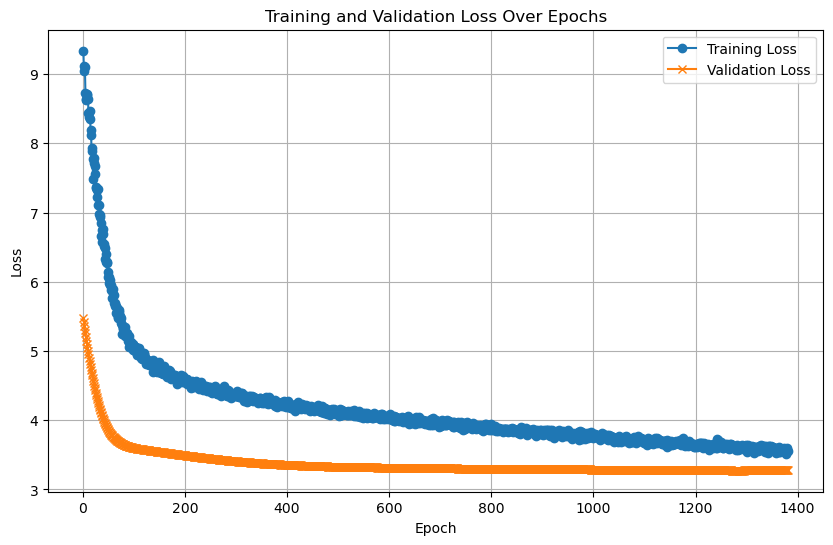

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.9437
Test Batch [20/40], Loss: 4.5706
Test Batch [30/40], Loss: 4.4902
Test Batch [40/40], Loss: 4.9626

Test Loss: 4.8985


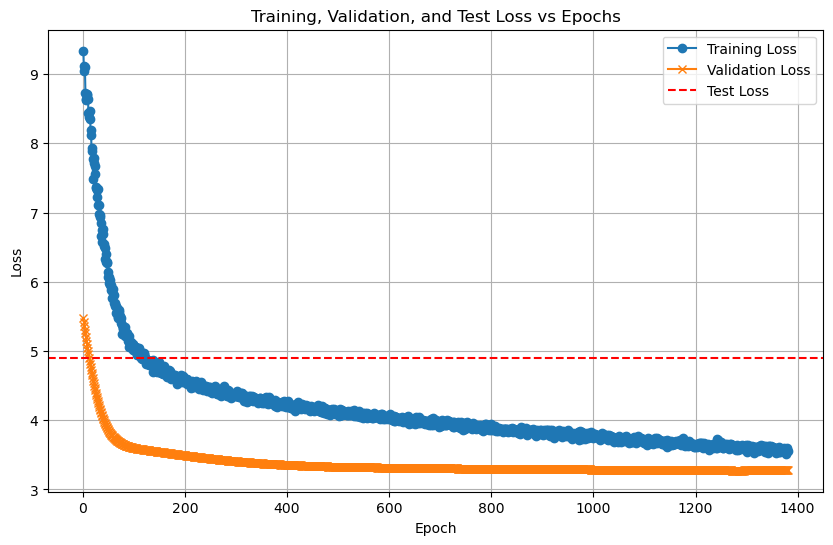

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.33      0.20      0.25         5
           2       0.43      0.60      0.50         5
           3       0.50      0.20      0.29         5
           4       0.67      0.40      0.50         5
           5       0.60      0.60      0.60         5
           6       0.71      1.00      0.83         5
           7       0.80      0.80      0.80         5
           8       0.83      1.00      0.91         5
           9       0.36      0.80      0.50         5
          10       0.50      0.20      0.29         5
          11       0.33      0.20      0.25         5
          12       0.75      0.60      0.67         5
          13       0.5

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8714  |  Val Loss: 2.8558
Validation loss improved from inf to 2.8558.
[Epoch 2/1000] Train Loss: 2.8438  |  Val Loss: 2.8317
Validation loss improved from 2.8558 to 2.8317.
[Epoch 3/1000] Train Loss: 2.8186  |  Val Loss: 2.8084
Validation loss improved from 2.8317 to 2.8084.
[Epoch 4/1000] Train Loss: 2.7914  |  Val Loss: 2.7861
Validation loss improved from 2.8084 to 2.7861.
[Epoch 5/1000] Train Loss: 2.7673  |  Val Loss: 2.7653
Validation loss improved from 2.7861 to 2.7653.


[Epoch 6/1000] Train Loss: 2.7445  |  Val Loss: 2.7455
Validation loss improved from 2.7653 to 2.7455.
[Epoch 7/1000] Train Loss: 2.7222  |  Val Loss: 2.7271
Validation loss improved from 2.7455 to 2.7271.
[Epoch 8/1000] Train Loss: 2.7017  |  Val Loss: 2.7107
Validation loss improved from 2.7271 to 2.7107.
[Epoch 9/1000] Train Loss: 2.6819  |  Val Loss: 2.6957
Validation loss improved from 2.7107 to 2.6957.
[Epoch 10/1000] Train Loss: 2.6640  |  Val Loss: 2.6816
Validation loss improved from 2.6957 to 2.6816.
[Epoch 11/1000] Train Loss: 2.6470  |  Val Loss: 2.6682
Validation loss improved from 2.6816 to 2.6682.
[Epoch 12/1000] Train Loss: 2.6326  |  Val Loss: 2.6553
Validation loss improved from 2.6682 to 2.6553.
[Epoch 13/1000] Train Loss: 2.6170  |  Val Loss: 2.6434
Validation loss improved from 2.6553 to 2.6434.
[Epoch 14/1000] Train Loss: 2.6030  |  Val Loss: 2.6323
Validation loss improved from 2.6434 to 2.6323.
[Epoch 15/1000] Train Loss: 2.5898  |  Val Loss: 2.6214
Validation l

[Epoch 26/1000] Train Loss: 2.4758  |  Val Loss: 2.5193
Validation loss improved from 2.5276 to 2.5193.
[Epoch 27/1000] Train Loss: 2.4669  |  Val Loss: 2.5110
Validation loss improved from 2.5193 to 2.5110.
[Epoch 28/1000] Train Loss: 2.4580  |  Val Loss: 2.5028
Validation loss improved from 2.5110 to 2.5028.
[Epoch 29/1000] Train Loss: 2.4490  |  Val Loss: 2.4944
Validation loss improved from 2.5028 to 2.4944.
[Epoch 30/1000] Train Loss: 2.4403  |  Val Loss: 2.4860
Validation loss improved from 2.4944 to 2.4860.
[Epoch 31/1000] Train Loss: 2.4317  |  Val Loss: 2.4777
Validation loss improved from 2.4860 to 2.4777.
[Epoch 32/1000] Train Loss: 2.4229  |  Val Loss: 2.4700
Validation loss improved from 2.4777 to 2.4700.
[Epoch 33/1000] Train Loss: 2.4144  |  Val Loss: 2.4624
Validation loss improved from 2.4700 to 2.4624.
[Epoch 34/1000] Train Loss: 2.4058  |  Val Loss: 2.4555
Validation loss improved from 2.4624 to 2.4555.
[Epoch 35/1000] Train Loss: 2.3972  |  Val Loss: 2.4486
Validati

[Epoch 37/1000] Train Loss: 2.3800  |  Val Loss: 2.4342
Validation loss improved from 2.4415 to 2.4342.
[Epoch 38/1000] Train Loss: 2.3713  |  Val Loss: 2.4267
Validation loss improved from 2.4342 to 2.4267.
[Epoch 39/1000] Train Loss: 2.3625  |  Val Loss: 2.4190
Validation loss improved from 2.4267 to 2.4190.
[Epoch 40/1000] Train Loss: 2.3541  |  Val Loss: 2.4116
Validation loss improved from 2.4190 to 2.4116.
[Epoch 41/1000] Train Loss: 2.3453  |  Val Loss: 2.4041
Validation loss improved from 2.4116 to 2.4041.
[Epoch 42/1000] Train Loss: 2.3368  |  Val Loss: 2.3961
Validation loss improved from 2.4041 to 2.3961.
[Epoch 43/1000] Train Loss: 2.3281  |  Val Loss: 2.3887
Validation loss improved from 2.3961 to 2.3887.
[Epoch 44/1000] Train Loss: 2.3191  |  Val Loss: 2.3808
Validation loss improved from 2.3887 to 2.3808.
[Epoch 45/1000] Train Loss: 2.3108  |  Val Loss: 2.3735
Validation loss improved from 2.3808 to 2.3735.
[Epoch 46/1000] Train Loss: 2.3020  |  Val Loss: 2.3659
Validati

[Epoch 54/1000] Train Loss: 2.2332  |  Val Loss: 2.3019
Validation loss improved from 2.3099 to 2.3019.
[Epoch 55/1000] Train Loss: 2.2244  |  Val Loss: 2.2940
Validation loss improved from 2.3019 to 2.2940.
[Epoch 56/1000] Train Loss: 2.2154  |  Val Loss: 2.2861
Validation loss improved from 2.2940 to 2.2861.
[Epoch 57/1000] Train Loss: 2.2065  |  Val Loss: 2.2778
Validation loss improved from 2.2861 to 2.2778.
[Epoch 58/1000] Train Loss: 2.1975  |  Val Loss: 2.2691
Validation loss improved from 2.2778 to 2.2691.
[Epoch 59/1000] Train Loss: 2.1884  |  Val Loss: 2.2605
Validation loss improved from 2.2691 to 2.2605.
[Epoch 60/1000] Train Loss: 2.1793  |  Val Loss: 2.2513
Validation loss improved from 2.2605 to 2.2513.
[Epoch 61/1000] Train Loss: 2.1704  |  Val Loss: 2.2423
Validation loss improved from 2.2513 to 2.2423.
[Epoch 62/1000] Train Loss: 2.1613  |  Val Loss: 2.2336
Validation loss improved from 2.2423 to 2.2336.
[Epoch 63/1000] Train Loss: 2.1517  |  Val Loss: 2.2254
Validati

[Epoch 66/1000] Train Loss: 2.1233  |  Val Loss: 2.1985
Validation loss improved from 2.2078 to 2.1985.
[Epoch 67/1000] Train Loss: 2.1139  |  Val Loss: 2.1893
Validation loss improved from 2.1985 to 2.1893.
[Epoch 68/1000] Train Loss: 2.1040  |  Val Loss: 2.1802
Validation loss improved from 2.1893 to 2.1802.
[Epoch 69/1000] Train Loss: 2.0946  |  Val Loss: 2.1713
Validation loss improved from 2.1802 to 2.1713.
[Epoch 70/1000] Train Loss: 2.0848  |  Val Loss: 2.1617
Validation loss improved from 2.1713 to 2.1617.
[Epoch 71/1000] Train Loss: 2.0758  |  Val Loss: 2.1524
Validation loss improved from 2.1617 to 2.1524.
[Epoch 72/1000] Train Loss: 2.0653  |  Val Loss: 2.1433
Validation loss improved from 2.1524 to 2.1433.
[Epoch 73/1000] Train Loss: 2.0558  |  Val Loss: 2.1344
Validation loss improved from 2.1433 to 2.1344.
[Epoch 74/1000] Train Loss: 2.0461  |  Val Loss: 2.1255
Validation loss improved from 2.1344 to 2.1255.
[Epoch 75/1000] Train Loss: 2.0366  |  Val Loss: 2.1164
Validati

[Epoch 83/1000] Train Loss: 1.9607  |  Val Loss: 2.0484
Validation loss improved from 2.0564 to 2.0484.
[Epoch 84/1000] Train Loss: 1.9515  |  Val Loss: 2.0412
Validation loss improved from 2.0484 to 2.0412.
[Epoch 85/1000] Train Loss: 1.9423  |  Val Loss: 2.0337
Validation loss improved from 2.0412 to 2.0337.
[Epoch 86/1000] Train Loss: 1.9333  |  Val Loss: 2.0262
Validation loss improved from 2.0337 to 2.0262.
[Epoch 87/1000] Train Loss: 1.9244  |  Val Loss: 2.0185
Validation loss improved from 2.0262 to 2.0185.
[Epoch 88/1000] Train Loss: 1.9154  |  Val Loss: 2.0108
Validation loss improved from 2.0185 to 2.0108.
[Epoch 89/1000] Train Loss: 1.9066  |  Val Loss: 2.0027
Validation loss improved from 2.0108 to 2.0027.
[Epoch 90/1000] Train Loss: 1.8974  |  Val Loss: 1.9948
Validation loss improved from 2.0027 to 1.9948.
[Epoch 91/1000] Train Loss: 1.8888  |  Val Loss: 1.9871
Validation loss improved from 1.9948 to 1.9871.
[Epoch 92/1000] Train Loss: 1.8799  |  Val Loss: 1.9797
Validati

[Epoch 95/1000] Train Loss: 1.8541  |  Val Loss: 1.9575
Validation loss improved from 1.9650 to 1.9575.
[Epoch 96/1000] Train Loss: 1.8453  |  Val Loss: 1.9497
Validation loss improved from 1.9575 to 1.9497.
[Epoch 97/1000] Train Loss: 1.8368  |  Val Loss: 1.9419
Validation loss improved from 1.9497 to 1.9419.
[Epoch 98/1000] Train Loss: 1.8283  |  Val Loss: 1.9339
Validation loss improved from 1.9419 to 1.9339.
[Epoch 99/1000] Train Loss: 1.8195  |  Val Loss: 1.9266
Validation loss improved from 1.9339 to 1.9266.
[Epoch 100/1000] Train Loss: 1.8109  |  Val Loss: 1.9193
Validation loss improved from 1.9266 to 1.9193.
[Epoch 101/1000] Train Loss: 1.8019  |  Val Loss: 1.9119
Validation loss improved from 1.9193 to 1.9119.
[Epoch 102/1000] Train Loss: 1.7921  |  Val Loss: 1.9038
Validation loss improved from 1.9119 to 1.9038.
[Epoch 103/1000] Train Loss: 1.7826  |  Val Loss: 1.8960
Validation loss improved from 1.9038 to 1.8960.
[Epoch 104/1000] Train Loss: 1.7731  |  Val Loss: 1.8889
Val

[Epoch 112/1000] Train Loss: 1.7047  |  Val Loss: 1.8349
Validation loss improved from 1.8413 to 1.8349.
[Epoch 113/1000] Train Loss: 1.6964  |  Val Loss: 1.8286
Validation loss improved from 1.8349 to 1.8286.
[Epoch 114/1000] Train Loss: 1.6883  |  Val Loss: 1.8227
Validation loss improved from 1.8286 to 1.8227.
[Epoch 115/1000] Train Loss: 1.6805  |  Val Loss: 1.8170
Validation loss improved from 1.8227 to 1.8170.
[Epoch 116/1000] Train Loss: 1.6722  |  Val Loss: 1.8112
Validation loss improved from 1.8170 to 1.8112.
[Epoch 117/1000] Train Loss: 1.6641  |  Val Loss: 1.8057
Validation loss improved from 1.8112 to 1.8057.
[Epoch 118/1000] Train Loss: 1.6565  |  Val Loss: 1.8001
Validation loss improved from 1.8057 to 1.8001.
[Epoch 119/1000] Train Loss: 1.6487  |  Val Loss: 1.7944
Validation loss improved from 1.8001 to 1.7944.
[Epoch 120/1000] Train Loss: 1.6408  |  Val Loss: 1.7888
Validation loss improved from 1.7944 to 1.7888.
[Epoch 121/1000] Train Loss: 1.6333  |  Val Loss: 1.783

[Epoch 126/1000] Train Loss: 1.5963  |  Val Loss: 1.7567
Validation loss improved from 1.7622 to 1.7567.
[Epoch 127/1000] Train Loss: 1.5885  |  Val Loss: 1.7517
Validation loss improved from 1.7567 to 1.7517.
[Epoch 128/1000] Train Loss: 1.5809  |  Val Loss: 1.7471
Validation loss improved from 1.7517 to 1.7471.
[Epoch 129/1000] Train Loss: 1.5744  |  Val Loss: 1.7426
Validation loss improved from 1.7471 to 1.7426.
[Epoch 130/1000] Train Loss: 1.5669  |  Val Loss: 1.7374
Validation loss improved from 1.7426 to 1.7374.
[Epoch 131/1000] Train Loss: 1.5597  |  Val Loss: 1.7316
Validation loss improved from 1.7374 to 1.7316.
[Epoch 132/1000] Train Loss: 1.5533  |  Val Loss: 1.7262
Validation loss improved from 1.7316 to 1.7262.
[Epoch 133/1000] Train Loss: 1.5450  |  Val Loss: 1.7206
Validation loss improved from 1.7262 to 1.7206.
[Epoch 134/1000] Train Loss: 1.5380  |  Val Loss: 1.7151
Validation loss improved from 1.7206 to 1.7151.
[Epoch 135/1000] Train Loss: 1.5308  |  Val Loss: 1.709

[Epoch 144/1000] Train Loss: 1.4694  |  Val Loss: 1.6664
Validation loss improved from 1.6711 to 1.6664.
[Epoch 145/1000] Train Loss: 1.4626  |  Val Loss: 1.6621
Validation loss improved from 1.6664 to 1.6621.
[Epoch 146/1000] Train Loss: 1.4561  |  Val Loss: 1.6578
Validation loss improved from 1.6621 to 1.6578.
[Epoch 147/1000] Train Loss: 1.4499  |  Val Loss: 1.6539
Validation loss improved from 1.6578 to 1.6539.
[Epoch 148/1000] Train Loss: 1.4434  |  Val Loss: 1.6496
Validation loss improved from 1.6539 to 1.6496.
[Epoch 149/1000] Train Loss: 1.4374  |  Val Loss: 1.6454
Validation loss improved from 1.6496 to 1.6454.
[Epoch 150/1000] Train Loss: 1.4309  |  Val Loss: 1.6411
Validation loss improved from 1.6454 to 1.6411.
[Epoch 151/1000] Train Loss: 1.4245  |  Val Loss: 1.6369
Validation loss improved from 1.6411 to 1.6369.
[Epoch 152/1000] Train Loss: 1.4188  |  Val Loss: 1.6328
Validation loss improved from 1.6369 to 1.6328.
[Epoch 153/1000] Train Loss: 1.4125  |  Val Loss: 1.628

[Epoch 157/1000] Train Loss: 1.3882  |  Val Loss: 1.6131
Validation loss improved from 1.6169 to 1.6131.
[Epoch 158/1000] Train Loss: 1.3826  |  Val Loss: 1.6090
Validation loss improved from 1.6131 to 1.6090.
[Epoch 159/1000] Train Loss: 1.3767  |  Val Loss: 1.6048
Validation loss improved from 1.6090 to 1.6048.
[Epoch 160/1000] Train Loss: 1.3710  |  Val Loss: 1.6007
Validation loss improved from 1.6048 to 1.6007.
[Epoch 161/1000] Train Loss: 1.3651  |  Val Loss: 1.5965
Validation loss improved from 1.6007 to 1.5965.
[Epoch 162/1000] Train Loss: 1.3595  |  Val Loss: 1.5923
Validation loss improved from 1.5965 to 1.5923.
[Epoch 163/1000] Train Loss: 1.3538  |  Val Loss: 1.5883
Validation loss improved from 1.5923 to 1.5883.
[Epoch 164/1000] Train Loss: 1.3482  |  Val Loss: 1.5845
Validation loss improved from 1.5883 to 1.5845.
[Epoch 165/1000] Train Loss: 1.3433  |  Val Loss: 1.5807
Validation loss improved from 1.5845 to 1.5807.
[Epoch 166/1000] Train Loss: 1.3366  |  Val Loss: 1.576

[Epoch 172/1000] Train Loss: 1.3046  |  Val Loss: 1.5552
Validation loss improved from 1.5585 to 1.5552.
[Epoch 173/1000] Train Loss: 1.2995  |  Val Loss: 1.5520
Validation loss improved from 1.5552 to 1.5520.
[Epoch 174/1000] Train Loss: 1.2945  |  Val Loss: 1.5490
Validation loss improved from 1.5520 to 1.5490.
[Epoch 175/1000] Train Loss: 1.2900  |  Val Loss: 1.5456
Validation loss improved from 1.5490 to 1.5456.
[Epoch 176/1000] Train Loss: 1.2837  |  Val Loss: 1.5418
Validation loss improved from 1.5456 to 1.5418.
[Epoch 177/1000] Train Loss: 1.2788  |  Val Loss: 1.5382
Validation loss improved from 1.5418 to 1.5382.
[Epoch 178/1000] Train Loss: 1.2735  |  Val Loss: 1.5349
Validation loss improved from 1.5382 to 1.5349.
[Epoch 179/1000] Train Loss: 1.2686  |  Val Loss: 1.5319
Validation loss improved from 1.5349 to 1.5319.
[Epoch 180/1000] Train Loss: 1.2633  |  Val Loss: 1.5288
Validation loss improved from 1.5319 to 1.5288.
[Epoch 181/1000] Train Loss: 1.2585  |  Val Loss: 1.525

[Epoch 185/1000] Train Loss: 1.2384  |  Val Loss: 1.5138
Validation loss improved from 1.5166 to 1.5138.
[Epoch 186/1000] Train Loss: 1.2335  |  Val Loss: 1.5114
Validation loss improved from 1.5138 to 1.5114.
[Epoch 187/1000] Train Loss: 1.2288  |  Val Loss: 1.5088
Validation loss improved from 1.5114 to 1.5088.
[Epoch 188/1000] Train Loss: 1.2235  |  Val Loss: 1.5056
Validation loss improved from 1.5088 to 1.5056.
[Epoch 189/1000] Train Loss: 1.2188  |  Val Loss: 1.5024
Validation loss improved from 1.5056 to 1.5024.
[Epoch 190/1000] Train Loss: 1.2136  |  Val Loss: 1.4996
Validation loss improved from 1.5024 to 1.4996.
[Epoch 191/1000] Train Loss: 1.2088  |  Val Loss: 1.4975
Validation loss improved from 1.4996 to 1.4975.
[Epoch 192/1000] Train Loss: 1.2045  |  Val Loss: 1.4953
Validation loss improved from 1.4975 to 1.4953.
[Epoch 193/1000] Train Loss: 1.1992  |  Val Loss: 1.4929
Validation loss improved from 1.4953 to 1.4929.
[Epoch 194/1000] Train Loss: 1.1951  |  Val Loss: 1.490

[Epoch 199/1000] Train Loss: 1.1722  |  Val Loss: 1.4775
Validation loss improved from 1.4792 to 1.4775.
[Epoch 200/1000] Train Loss: 1.1678  |  Val Loss: 1.4755
Validation loss improved from 1.4775 to 1.4755.
[Epoch 201/1000] Train Loss: 1.1632  |  Val Loss: 1.4718
Validation loss improved from 1.4755 to 1.4718.
[Epoch 202/1000] Train Loss: 1.1588  |  Val Loss: 1.4684
Validation loss improved from 1.4718 to 1.4684.
[Epoch 203/1000] Train Loss: 1.1543  |  Val Loss: 1.4656
Validation loss improved from 1.4684 to 1.4656.
[Epoch 204/1000] Train Loss: 1.1503  |  Val Loss: 1.4634
Validation loss improved from 1.4656 to 1.4634.
[Epoch 205/1000] Train Loss: 1.1455  |  Val Loss: 1.4604
Validation loss improved from 1.4634 to 1.4604.
[Epoch 206/1000] Train Loss: 1.1414  |  Val Loss: 1.4572
Validation loss improved from 1.4604 to 1.4572.
[Epoch 207/1000] Train Loss: 1.1375  |  Val Loss: 1.4550
Validation loss improved from 1.4572 to 1.4550.
[Epoch 208/1000] Train Loss: 1.1337  |  Val Loss: 1.452

[Epoch 213/1000] Train Loss: 1.1116  |  Val Loss: 1.4424
Validation loss improved from 1.4442 to 1.4424.
[Epoch 214/1000] Train Loss: 1.1077  |  Val Loss: 1.4402
Validation loss improved from 1.4424 to 1.4402.
[Epoch 215/1000] Train Loss: 1.1030  |  Val Loss: 1.4384
Validation loss improved from 1.4402 to 1.4384.
[Epoch 216/1000] Train Loss: 1.0996  |  Val Loss: 1.4369
Validation loss improved from 1.4384 to 1.4369.
[Epoch 217/1000] Train Loss: 1.0954  |  Val Loss: 1.4354
Validation loss improved from 1.4369 to 1.4354.
[Epoch 218/1000] Train Loss: 1.0914  |  Val Loss: 1.4338
Validation loss improved from 1.4354 to 1.4338.
[Epoch 219/1000] Train Loss: 1.0871  |  Val Loss: 1.4331
Validation loss improved from 1.4338 to 1.4331.
[Epoch 220/1000] Train Loss: 1.0839  |  Val Loss: 1.4339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 1.0793  |  Val Loss: 1.4323
Validation loss improved from 1.4331 to 1.4323.
[Epoch 222/1000] Train Loss: 1.0754  |  Val Loss:

[Epoch 226/1000] Train Loss: 1.0600  |  Val Loss: 1.4193
Validation loss improved from 1.4206 to 1.4193.
[Epoch 227/1000] Train Loss: 1.0560  |  Val Loss: 1.4176
Validation loss improved from 1.4193 to 1.4176.
[Epoch 228/1000] Train Loss: 1.0525  |  Val Loss: 1.4167
Validation loss improved from 1.4176 to 1.4167.
[Epoch 229/1000] Train Loss: 1.0483  |  Val Loss: 1.4152
Validation loss improved from 1.4167 to 1.4152.
[Epoch 230/1000] Train Loss: 1.0445  |  Val Loss: 1.4146
Validation loss improved from 1.4152 to 1.4146.
[Epoch 231/1000] Train Loss: 1.0416  |  Val Loss: 1.4146
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 1.0371  |  Val Loss: 1.4139
Validation loss improved from 1.4146 to 1.4139.
[Epoch 233/1000] Train Loss: 1.0332  |  Val Loss: 1.4136
Validation loss improved from 1.4139 to 1.4136.
[Epoch 234/1000] Train Loss: 1.0293  |  Val Loss: 1.4135
Validation loss improved from 1.4136 to 1.4135.
[Epoch 235/1000] Train Loss: 1.0256  |  Val Loss:

[Epoch 240/1000] Train Loss: 1.0059  |  Val Loss: 1.4029
Validation loss improved from 1.4045 to 1.4029.
[Epoch 241/1000] Train Loss: 1.0017  |  Val Loss: 1.4020
Validation loss improved from 1.4029 to 1.4020.
[Epoch 242/1000] Train Loss: 0.9975  |  Val Loss: 1.4002
Validation loss improved from 1.4020 to 1.4002.
[Epoch 243/1000] Train Loss: 0.9938  |  Val Loss: 1.3990
Validation loss improved from 1.4002 to 1.3990.
[Epoch 244/1000] Train Loss: 0.9903  |  Val Loss: 1.3978
Validation loss improved from 1.3990 to 1.3978.
[Epoch 245/1000] Train Loss: 0.9868  |  Val Loss: 1.3972
Validation loss improved from 1.3978 to 1.3972.
[Epoch 246/1000] Train Loss: 0.9826  |  Val Loss: 1.3965
Validation loss improved from 1.3972 to 1.3965.
[Epoch 247/1000] Train Loss: 0.9794  |  Val Loss: 1.3972
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.9761  |  Val Loss: 1.3964
Validation loss improved from 1.3965 to 1.3964.
[Epoch 249/1000] Train Loss: 0.9720  |  Val Loss:

[Epoch 255/1000] Train Loss: 0.9525  |  Val Loss: 1.3935
Validation loss improved from 1.3963 to 1.3935.
[Epoch 256/1000] Train Loss: 0.9484  |  Val Loss: 1.3910
Validation loss improved from 1.3935 to 1.3910.
[Epoch 257/1000] Train Loss: 0.9445  |  Val Loss: 1.3888
Validation loss improved from 1.3910 to 1.3888.
[Epoch 258/1000] Train Loss: 0.9423  |  Val Loss: 1.3875
Validation loss improved from 1.3888 to 1.3875.
[Epoch 259/1000] Train Loss: 0.9383  |  Val Loss: 1.3879
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 0.9358  |  Val Loss: 1.3892
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 0.9311  |  Val Loss: 1.3870
Validation loss improved from 1.3875 to 1.3870.
[Epoch 262/1000] Train Loss: 0.9277  |  Val Loss: 1.3842
Validation loss improved from 1.3870 to 1.3842.
[Epoch 263/1000] Train Loss: 0.9251  |  Val Loss: 1.3811
Validation loss improved from 1.3842 to 1.3811.
[Epoch 264/1000] Train Loss: 0.9222  |  Val

[Epoch 270/1000] Train Loss: 0.9030  |  Val Loss: 1.3752
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.9002  |  Val Loss: 1.3743
Validation loss improved from 1.3752 to 1.3743.
[Epoch 272/1000] Train Loss: 0.8964  |  Val Loss: 1.3736
Validation loss improved from 1.3743 to 1.3736.
[Epoch 273/1000] Train Loss: 0.8936  |  Val Loss: 1.3737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.8906  |  Val Loss: 1.3726
Validation loss improved from 1.3736 to 1.3726.
[Epoch 275/1000] Train Loss: 0.8879  |  Val Loss: 1.3716
Validation loss improved from 1.3726 to 1.3716.
[Epoch 276/1000] Train Loss: 0.8851  |  Val Loss: 1.3707
Validation loss improved from 1.3716 to 1.3707.
[Epoch 277/1000] Train Loss: 0.8824  |  Val Loss: 1.3701
Validation loss improved from 1.3707 to 1.3701.
[Epoch 278/1000] Train Loss: 0.8799  |  Val Loss: 1.3691
Validation loss improved from 1.3701 to 1.3691.
[Epoch 279/1000] Train Loss: 0.8759  |  Val

[Epoch 287/1000] Train Loss: 0.8547  |  Val Loss: 1.3665
Validation loss improved from 1.3676 to 1.3665.
[Epoch 288/1000] Train Loss: 0.8519  |  Val Loss: 1.3649
Validation loss improved from 1.3665 to 1.3649.
[Epoch 289/1000] Train Loss: 0.8487  |  Val Loss: 1.3654
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.8464  |  Val Loss: 1.3633
Validation loss improved from 1.3649 to 1.3633.
[Epoch 291/1000] Train Loss: 0.8433  |  Val Loss: 1.3626
Validation loss improved from 1.3633 to 1.3626.
[Epoch 292/1000] Train Loss: 0.8418  |  Val Loss: 1.3608
Validation loss improved from 1.3626 to 1.3608.
[Epoch 293/1000] Train Loss: 0.8384  |  Val Loss: 1.3585
Validation loss improved from 1.3608 to 1.3585.
[Epoch 294/1000] Train Loss: 0.8367  |  Val Loss: 1.3562
Validation loss improved from 1.3585 to 1.3562.
[Epoch 295/1000] Train Loss: 0.8336  |  Val Loss: 1.3558
Validation loss improved from 1.3562 to 1.3558.
[Epoch 296/1000] Train Loss: 0.8318  |  Val Loss:

[Epoch 299/1000] Train Loss: 0.8244  |  Val Loss: 1.3551
Validation loss improved from 1.3552 to 1.3551.
[Epoch 300/1000] Train Loss: 0.8216  |  Val Loss: 1.3535
Validation loss improved from 1.3551 to 1.3535.
[Epoch 301/1000] Train Loss: 0.8185  |  Val Loss: 1.3518
Validation loss improved from 1.3535 to 1.3518.
[Epoch 302/1000] Train Loss: 0.8164  |  Val Loss: 1.3513
Validation loss improved from 1.3518 to 1.3513.
[Epoch 303/1000] Train Loss: 0.8143  |  Val Loss: 1.3491
Validation loss improved from 1.3513 to 1.3491.
[Epoch 304/1000] Train Loss: 0.8115  |  Val Loss: 1.3452
Validation loss improved from 1.3491 to 1.3452.
[Epoch 305/1000] Train Loss: 0.8104  |  Val Loss: 1.3421
Validation loss improved from 1.3452 to 1.3421.
[Epoch 306/1000] Train Loss: 0.8075  |  Val Loss: 1.3428
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 307/1000] Train Loss: 0.8045  |  Val Loss: 1.3428
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 308/1000] Train Loss: 0.8024  |  Val

[Epoch 316/1000] Train Loss: 0.7854  |  Val Loss: 1.3405
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 317/1000] Train Loss: 0.7831  |  Val Loss: 1.3411
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 318/1000] Train Loss: 0.7813  |  Val Loss: 1.3427
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 319/1000] Train Loss: 0.7794  |  Val Loss: 1.3399
Validation loss improved from 1.3405 to 1.3399.
[Epoch 320/1000] Train Loss: 0.7769  |  Val Loss: 1.3399
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 321/1000] Train Loss: 0.7748  |  Val Loss: 1.3390
Validation loss improved from 1.3399 to 1.3390.
[Epoch 322/1000] Train Loss: 0.7726  |  Val Loss: 1.3373
Validation loss improved from 1.3390 to 1.3373.
[Epoch 323/1000] Train Loss: 0.7703  |  Val Loss: 1.3369
Validation loss improved from 1.3373 to 1.3369.
[Epoch 324/1000] Train Loss: 0.7689  |  Val Loss: 1.3358
Validation loss improved from 1.3369 to 1.3358.
[Epoch 325/1000] Train Loss: 0.

[Epoch 330/1000] Train Loss: 0.7581  |  Val Loss: 1.3503
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 331/1000] Train Loss: 0.7556  |  Val Loss: 1.3506
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 332/1000] Train Loss: 0.7540  |  Val Loss: 1.3487
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 333/1000] Train Loss: 0.7515  |  Val Loss: 1.3459
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 334/1000] Train Loss: 0.7487  |  Val Loss: 1.3394
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 335/1000] Train Loss: 0.7470  |  Val Loss: 1.3346
Validation loss improved from 1.3358 to 1.3346.
[Epoch 336/1000] Train Loss: 0.7454  |  Val Loss: 1.3293
Validation loss improved from 1.3346 to 1.3293.
[Epoch 337/1000] Train Loss: 0.7442  |  Val Loss: 1.3262
Validation loss improved from 1.3293 to 1.3262.
[Epoch 338/1000] Train Loss: 0.7424  |  Val Loss: 1.3251
Validation loss improved from 1.3262 to 1.3251.
[Epoch 339/1000] Train L

[Epoch 343/1000] Train Loss: 0.7327  |  Val Loss: 1.3252
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 344/1000] Train Loss: 0.7309  |  Val Loss: 1.3239
Validation loss improved from 1.3247 to 1.3239.
[Epoch 345/1000] Train Loss: 0.7295  |  Val Loss: 1.3240
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 346/1000] Train Loss: 0.7277  |  Val Loss: 1.3257
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 347/1000] Train Loss: 0.7251  |  Val Loss: 1.3266
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 348/1000] Train Loss: 0.7242  |  Val Loss: 1.3270
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 349/1000] Train Loss: 0.7219  |  Val Loss: 1.3270
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 350/1000] Train Loss: 0.7205  |  Val Loss: 1.3265
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 351/1000] Train Loss: 0.7184  |  Val Loss: 1.3271
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 356/1000] Train Loss: 0.7100  |  Val Loss: 1.3297
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 357/1000] Train Loss: 0.7089  |  Val Loss: 1.3285
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 358/1000] Train Loss: 0.7064  |  Val Loss: 1.3273
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 359/1000] Train Loss: 0.7048  |  Val Loss: 1.3270
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 360/1000] Train Loss: 0.7033  |  Val Loss: 1.3270
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 361/1000] Train Loss: 0.7018  |  Val Loss: 1.3254
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 362/1000] Train Loss: 0.7000  |  Val Loss: 1.3238
Validation loss improved from 1.3239 to 1.3238.
[Epoch 363/1000] Train Loss: 0.6984  |  Val Loss: 1.3225
Validation loss improved from 1.3238 to 1.3225.
[Epoch 364/1000] Train Loss: 0.6969  |  Val Loss: 1.3231
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 370/1000] Train Loss: 0.6879  |  Val Loss: 1.3268
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 371/1000] Train Loss: 0.6862  |  Val Loss: 1.3261
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 372/1000] Train Loss: 0.6846  |  Val Loss: 1.3241
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 373/1000] Train Loss: 0.6839  |  Val Loss: 1.3199
Validation loss improved from 1.3225 to 1.3199.
[Epoch 374/1000] Train Loss: 0.6824  |  Val Loss: 1.3196
Validation loss improved from 1.3199 to 1.3196.
[Epoch 375/1000] Train Loss: 0.6811  |  Val Loss: 1.3192
Validation loss improved from 1.3196 to 1.3192.
[Epoch 376/1000] Train Loss: 0.6794  |  Val Loss: 1.3180
Validation loss improved from 1.3192 to 1.3180.
[Epoch 377/1000] Train Loss: 0.6773  |  Val Loss: 1.3167
Validation loss improved from 1.3180 to 1.3167.
[Epoch 378/1000] Train Loss: 0.6765  |  Val Loss: 1.3160
Validation loss improved from 1.3167 to 1.3160.
[Epoch 379/1000] Train Loss: 0.6746  

[Epoch 384/1000] Train Loss: 0.6672  |  Val Loss: 1.3119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 385/1000] Train Loss: 0.6663  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 386/1000] Train Loss: 0.6651  |  Val Loss: 1.3148
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 387/1000] Train Loss: 0.6639  |  Val Loss: 1.3154
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 388/1000] Train Loss: 0.6628  |  Val Loss: 1.3152
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 389/1000] Train Loss: 0.6608  |  Val Loss: 1.3149
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 390/1000] Train Loss: 0.6609  |  Val Loss: 1.3139
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 391/1000] Train Loss: 0.6592  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 392/1000] Train Loss: 0.6568  |  Val Loss: 1.3135
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 402/1000] Train Loss: 0.6429  |  Val Loss: 1.3167
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 403/1000] Train Loss: 0.6421  |  Val Loss: 1.3175
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 404/1000] Train Loss: 0.6422  |  Val Loss: 1.3162
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 405/1000] Train Loss: 0.6402  |  Val Loss: 1.3143
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 406/1000] Train Loss: 0.6396  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 407/1000] Train Loss: 0.6387  |  Val Loss: 1.3130
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 408/1000] Train Loss: 0.6359  |  Val Loss: 1.3148
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 409/1000] Train Loss: 0.6347  |  Val Loss: 1.3169
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 410/1000] Train Loss: 0.6345  |  Val Loss: 1.3189
!! Validation loss did NOT improve !! Patience:

[Epoch 415/1000] Train Loss: 0.6295  |  Val Loss: 1.3224
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 416/1000] Train Loss: 0.6271  |  Val Loss: 1.3226
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 417/1000] Train Loss: 0.6260  |  Val Loss: 1.3239
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 418/1000] Train Loss: 0.6242  |  Val Loss: 1.3227
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 419/1000] Train Loss: 0.6234  |  Val Loss: 1.3210
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 420/1000] Train Loss: 0.6227  |  Val Loss: 1.3206
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 421/1000] Train Loss: 0.6211  |  Val Loss: 1.3215
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 422/1000] Train Loss: 0.6193  |  Val Loss: 1.3232
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 423/1000] Train Loss: 0.6181  |  Val Loss: 1.3235
!! Validation loss did NOT improve !! Patience:

[Epoch 432/1000] Train Loss: 0.6085  |  Val Loss: 1.3199
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 433/1000] Train Loss: 0.6072  |  Val Loss: 1.3205
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 434/1000] Train Loss: 0.6068  |  Val Loss: 1.3224
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 435/1000] Train Loss: 0.6047  |  Val Loss: 1.3220
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 436/1000] Train Loss: 0.6040  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 437/1000] Train Loss: 0.6037  |  Val Loss: 1.3210
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 438/1000] Train Loss: 0.6022  |  Val Loss: 1.3198
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 439/1000] Train Loss: 0.6004  |  Val Loss: 1.3171
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 440/1000] Train Loss: 0.5997  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience:

[Epoch 446/1000] Train Loss: 0.5944  |  Val Loss: 1.3225
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 447/1000] Train Loss: 0.5930  |  Val Loss: 1.3219
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 448/1000] Train Loss: 0.5915  |  Val Loss: 1.3214
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 449/1000] Train Loss: 0.5909  |  Val Loss: 1.3215
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 450/1000] Train Loss: 0.5900  |  Val Loss: 1.3212
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 451/1000] Train Loss: 0.5889  |  Val Loss: 1.3192
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 452/1000] Train Loss: 0.5880  |  Val Loss: 1.3188
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 453/1000] Train Loss: 0.5865  |  Val Loss: 1.3182
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 454/1000] Train Loss: 0.5861  |  Val Loss: 1.3200
!! Validation loss did NOT improve !! Patience:

[Epoch 460/1000] Train Loss: 0.5810  |  Val Loss: 1.3298
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 461/1000] Train Loss: 0.5794  |  Val Loss: 1.3307
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 462/1000] Train Loss: 0.5782  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 463/1000] Train Loss: 0.5770  |  Val Loss: 1.3344
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 464/1000] Train Loss: 0.5770  |  Val Loss: 1.3354
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 465/1000] Train Loss: 0.5761  |  Val Loss: 1.3379
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 466/1000] Train Loss: 0.5749  |  Val Loss: 1.3396
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 467/1000] Train Loss: 0.5731  |  Val Loss: 1.3410
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 468/1000] Train Loss: 0.5726  |  Val Loss: 1.3397
!! Validation loss did NOT improve !! Patience:

[Epoch 474/1000] Train Loss: 0.5669  |  Val Loss: 1.3420
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 475/1000] Train Loss: 0.5659  |  Val Loss: 1.3425
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 476/1000] Train Loss: 0.5652  |  Val Loss: 1.3431
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 477/1000] Train Loss: 0.5642  |  Val Loss: 1.3456
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 478/1000] Train Loss: 0.5642  |  Val Loss: 1.3455
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 479/1000] Train Loss: 0.5624  |  Val Loss: 1.3438
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 480/1000] Train Loss: 0.5614  |  Val Loss: 1.3440
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 481/1000] Train Loss: 0.5605  |  Val Loss: 1.3444
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 482/1000] Train Loss: 0.5604  |  Val Loss: 1.3438
!! Validation loss did NOT improve !! Patience:

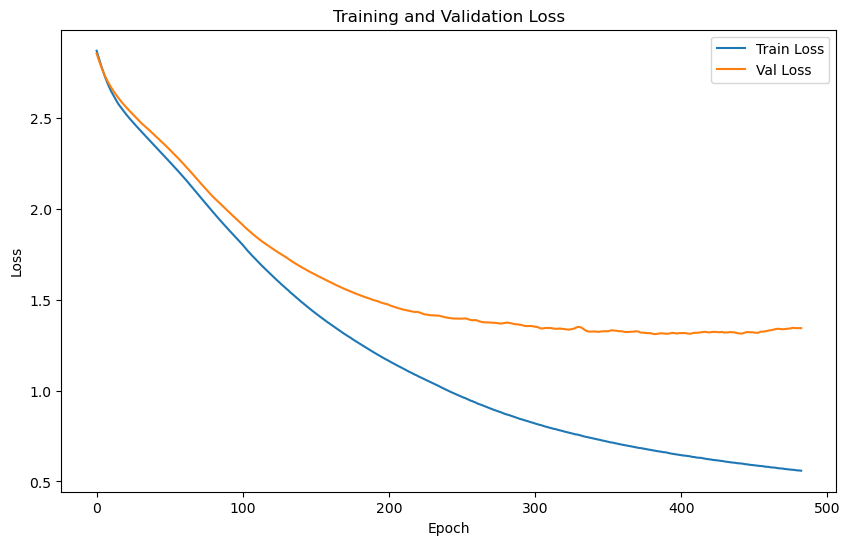

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9639 | Test Accuracy: 44.85%


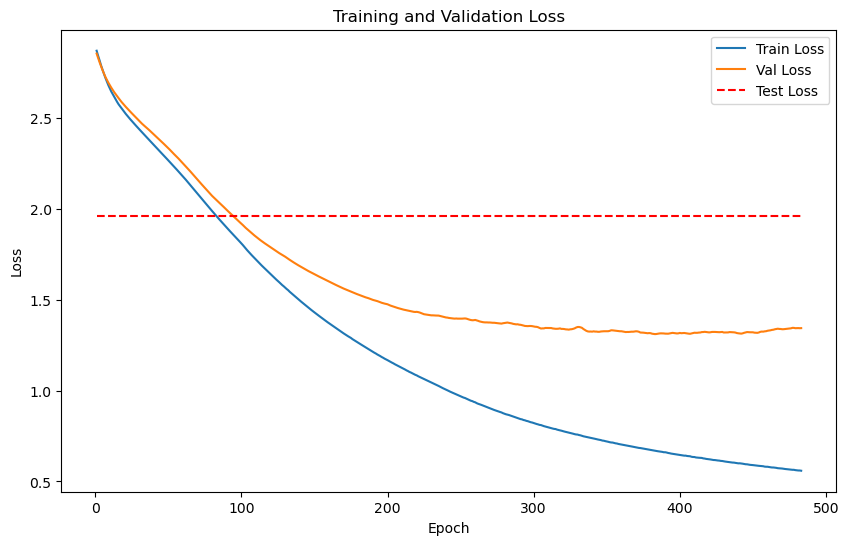

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.3860
Epoch [1/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4513

Validation loss improved from inf to 0.4513. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.3861
Epoch [2/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4509

Validation loss improved from 0.4513 to 0.4509. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.3860
Epoch [3/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.4502

Validation loss improved from 0.4509 to 0.4502. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.3857
Epoch [4/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.4494

Validation loss improved from 0.4502 to 0.4494. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.3859
Epoch [5/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4487

Validation loss improved from 0.4494 to 0.4487. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.3863
Epoch [6/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.4479

Validation loss improved from 0.4487 to 0.4479. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.3865
Epoch [7/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.4470

Validation loss improved from 0.4479 to 0.4470. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3865
Epoch [8/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4461

Validation loss improved from 0.4470 to 0.4461. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.3865
Epoch [9/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4452

Validation loss improved from 0.4461 to 0.4452. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3868
Epoch [10/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4446

Validation loss improved from 0.4452 to 0.4446. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3869
Epoch [11/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4438

Validation loss improved from 0.4446 to 0.4438. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.3868
Epoch [12/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4431

Validation loss improved from 0.4438 to 0.4431. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.3867
Epoch [13/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4423

Validation loss improved from 0.4431 to 0.4423. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.3866
Epoch [14/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4416

Validation loss improved from 0.4423 to 0.4416. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.3865
Epoch [15/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4410

Validation loss improved from 0.4416 to 0.4410. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.3866
Epoch [16/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4406

Validation loss improved from 0.4410 to 0.4406. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.3868
Epoch [17/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4404

Validation loss improved from 0.4406 to 0.4404. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.3872
Epoch [18/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4402

Validation loss improved from 0.4404 to 0.4402. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.3875
Epoch [19/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4401

Validation loss improved from 0.4402 to 0.4401. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.3879
Epoch [20/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4401

Validation loss improved from 0.4401 to 0.4401. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.3881
Epoch [21/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4399

Validation loss improved from 0.4401 to 0.4399. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.3883
Epoch [22/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4398

Validation loss improved from 0.4399 to 0.4398. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.3884
Epoch [23/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4398

Validation loss improved from 0.4398 to 0.4398. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.3885
Epoch [24/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.3886
Epoch [25/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.3887
Epoch [26/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.3888
Epoch [27/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.3889
Epoch [28/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.3889
Epoch [29/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4398

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.3889
Epoch [30/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4397

Validation loss improved from 0.4398 to 0.4397. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.3889
Epoch [31/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4397

Validation loss improved from 0.4397 to 0.4397. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.3889
Epoch [32/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4396

Validation loss improved from 0.4397 to 0.4396. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.3889
Epoch [33/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4396

Validation loss improved from 0.4396 to 0.4396. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.3889
Epoch [34/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4395

Validation loss improved from 0.4396 to 0.4395. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.3889
Epoch [35/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4394

Validation loss improved from 0.4395 to 0.4394. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.3889
Epoch [36/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4394

Validation loss improved from 0.4394 to 0.4394. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.3889
Epoch [37/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4393

Validation loss improved from 0.4394 to 0.4393. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.3888
Epoch [38/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4392

Validation loss improved from 0.4393 to 0.4392. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.3887
Epoch [39/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4390

Validation loss improved from 0.4392 to 0.4390. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.3887
Epoch [40/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4390

Validation loss improved from 0.4390 to 0.4390. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.3887
Epoch [41/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4389

Validation loss improved from 0.4390 to 0.4389. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.3886
Epoch [42/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4388

Validation loss improved from 0.4389 to 0.4388. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.3885
Epoch [43/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4387

Validation loss improved from 0.4388 to 0.4387. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.3884
Epoch [44/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4385

Validation loss improved from 0.4387 to 0.4385. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4886
    Batch [2/2], Val Loss: 0.3883
Epoch [45/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4384

Validation loss improved from 0.4385 to 0.4384. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.3881
Epoch [46/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4383

Validation loss improved from 0.4384 to 0.4383. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.3879
Epoch [47/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4381

Validation loss improved from 0.4383 to 0.4381. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.3876
Epoch [48/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4379

Validation loss improved from 0.4381 to 0.4379. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.3874
Epoch [49/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4377

Validation loss improved from 0.4379 to 0.4377. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.3872
Epoch [50/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4376

Validation loss improved from 0.4377 to 0.4376. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.3870
Epoch [51/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4374

Validation loss improved from 0.4376 to 0.4374. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.3867
Epoch [52/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4372

Validation loss improved from 0.4374 to 0.4372. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.3865
Epoch [53/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4370

Validation loss improved from 0.4372 to 0.4370. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.3863
Epoch [54/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4368

Validation loss improved from 0.4370 to 0.4368. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.3860
Epoch [55/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4366

Validation loss improved from 0.4368 to 0.4366. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3858
Epoch [56/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4365

Validation loss improved from 0.4366 to 0.4365. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.3856
Epoch [57/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4363

Validation loss improved from 0.4365 to 0.4363. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.3853
Epoch [58/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4361

Validation loss improved from 0.4363 to 0.4361. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.3850
Epoch [59/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4359

Validation loss improved from 0.4361 to 0.4359. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3848
Epoch [60/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4357

Validation loss improved from 0.4359 to 0.4357. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.3845
Epoch [61/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4356

Validation loss improved from 0.4357 to 0.4356. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.3842
Epoch [62/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4354

Validation loss improved from 0.4356 to 0.4354. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.3838
Epoch [63/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4352

Validation loss improved from 0.4354 to 0.4352. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3836
Epoch [64/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4350

Validation loss improved from 0.4352 to 0.4350. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3833
Epoch [65/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4348

Validation loss improved from 0.4350 to 0.4348. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.3829
Epoch [66/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4346

Validation loss improved from 0.4348 to 0.4346. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.3826
Epoch [67/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4344

Validation loss improved from 0.4346 to 0.4344. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.3823
Epoch [68/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4343

Validation loss improved from 0.4344 to 0.4343. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.3821
Epoch [69/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4341

Validation loss improved from 0.4343 to 0.4341. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.3818
Epoch [70/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4339

Validation loss improved from 0.4341 to 0.4339. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.3815
Epoch [71/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4337

Validation loss improved from 0.4339 to 0.4337. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.3812
Epoch [72/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4334

Validation loss improved from 0.4337 to 0.4334. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.3810
Epoch [73/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4332

Validation loss improved from 0.4334 to 0.4332. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.3807
Epoch [74/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4330

Validation loss improved from 0.4332 to 0.4330. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.3805
Epoch [75/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4329

Validation loss improved from 0.4330 to 0.4329. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.3803
Epoch [76/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4327

Validation loss improved from 0.4329 to 0.4327. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.3801
Epoch [77/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4325

Validation loss improved from 0.4327 to 0.4325. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.3798
Epoch [78/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4324

Validation loss improved from 0.4325 to 0.4324. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.3796
Epoch [79/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4322

Validation loss improved from 0.4324 to 0.4322. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.3793
Epoch [80/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4320

Validation loss improved from 0.4322 to 0.4320. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.3791
Epoch [81/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4318

Validation loss improved from 0.4320 to 0.4318. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3788
Epoch [82/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4317

Validation loss improved from 0.4318 to 0.4317. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.3785
Epoch [83/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4315

Validation loss improved from 0.4317 to 0.4315. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.3782
Epoch [84/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4313

Validation loss improved from 0.4315 to 0.4313. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.3780
Epoch [85/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4311

Validation loss improved from 0.4313 to 0.4311. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3777
Epoch [86/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4309

Validation loss improved from 0.4311 to 0.4309. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3775
Epoch [87/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4308

Validation loss improved from 0.4309 to 0.4308. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.3772
Epoch [88/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4306

Validation loss improved from 0.4308 to 0.4306. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3768
Epoch [89/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4304

Validation loss improved from 0.4306 to 0.4304. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3766
Epoch [90/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4302

Validation loss improved from 0.4304 to 0.4302. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3763
Epoch [91/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4301

Validation loss improved from 0.4302 to 0.4301. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3760
Epoch [92/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4299

Validation loss improved from 0.4301 to 0.4299. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3757
Epoch [93/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4297

Validation loss improved from 0.4299 to 0.4297. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3754
Epoch [94/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4296

Validation loss improved from 0.4297 to 0.4296. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3750
Epoch [95/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4294

Validation loss improved from 0.4296 to 0.4294. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3747
Epoch [96/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4292

Validation loss improved from 0.4294 to 0.4292. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3744
Epoch [97/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4291

Validation loss improved from 0.4292 to 0.4291. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3741
Epoch [98/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4289

Validation loss improved from 0.4291 to 0.4289. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3737
Epoch [99/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4287

Validation loss improved from 0.4289 to 0.4287. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3734
Epoch [100/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4285

Validation loss improved from 0.4287 to 0.4285. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3731
Epoch [101/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4283

Validation loss improved from 0.4285 to 0.4283. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3727
Epoch [102/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4281

Validation loss improved from 0.4283 to 0.4281. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3723
Epoch [103/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4279

Validation loss improved from 0.4281 to 0.4279. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.3720
Epoch [104/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4277

Validation loss improved from 0.4279 to 0.4277. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.3716
Epoch [105/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4275

Validation loss improved from 0.4277 to 0.4275. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.3712
Epoch [106/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4273

Validation loss improved from 0.4275 to 0.4273. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.3709
Epoch [107/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4271

Validation loss improved from 0.4273 to 0.4271. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.3706
Epoch [108/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4269

Validation loss improved from 0.4271 to 0.4269. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.3702
Epoch [109/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4267

Validation loss improved from 0.4269 to 0.4267. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.3698
Epoch [110/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4265

Validation loss improved from 0.4267 to 0.4265. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3694
Epoch [111/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4262

Validation loss improved from 0.4265 to 0.4262. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.3691
Epoch [112/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4260

Validation loss improved from 0.4262 to 0.4260. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.3688
Epoch [113/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4258

Validation loss improved from 0.4260 to 0.4258. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.3685
Epoch [114/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4256

Validation loss improved from 0.4258 to 0.4256. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.3682
Epoch [115/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4254

Validation loss improved from 0.4256 to 0.4254. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.3680
Epoch [116/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4253

Validation loss improved from 0.4254 to 0.4253. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.3677
Epoch [117/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4251

Validation loss improved from 0.4253 to 0.4251. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.3675
Epoch [118/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4250

Validation loss improved from 0.4251 to 0.4250. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3673
Epoch [119/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4248

Validation loss improved from 0.4250 to 0.4248. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.3670
Epoch [120/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4246

Validation loss improved from 0.4248 to 0.4246. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.3667
Epoch [121/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4244

Validation loss improved from 0.4246 to 0.4244. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.3665
Epoch [122/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4243

Validation loss improved from 0.4244 to 0.4243. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.3663
Epoch [123/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4241

Validation loss improved from 0.4243 to 0.4241. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.3661
Epoch [124/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4239

Validation loss improved from 0.4241 to 0.4239. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.3659
Epoch [125/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4238

Validation loss improved from 0.4239 to 0.4238. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.3657
Epoch [126/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4236

Validation loss improved from 0.4238 to 0.4236. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.3655
Epoch [127/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4235

Validation loss improved from 0.4236 to 0.4235. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3652
Epoch [128/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4233

Validation loss improved from 0.4235 to 0.4233. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.3649
Epoch [129/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4231

Validation loss improved from 0.4233 to 0.4231. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.3646
Epoch [130/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4229

Validation loss improved from 0.4231 to 0.4229. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.3643
Epoch [131/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4227

Validation loss improved from 0.4229 to 0.4227. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.3641
Epoch [132/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4226

Validation loss improved from 0.4227 to 0.4226. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.3638
Epoch [133/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4224

Validation loss improved from 0.4226 to 0.4224. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.3636
Epoch [134/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4223

Validation loss improved from 0.4224 to 0.4223. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.3634
Epoch [135/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4222

Validation loss improved from 0.4223 to 0.4222. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.3632
Epoch [136/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4221

Validation loss improved from 0.4222 to 0.4221. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.3631
Epoch [137/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4220

Validation loss improved from 0.4221 to 0.4220. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.3629
Epoch [138/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4218

Validation loss improved from 0.4220 to 0.4218. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.3627
Epoch [139/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4217

Validation loss improved from 0.4218 to 0.4217. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3625
Epoch [140/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4216

Validation loss improved from 0.4217 to 0.4216. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3623
Epoch [141/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4215

Validation loss improved from 0.4216 to 0.4215. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.3621
Epoch [142/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4213

Validation loss improved from 0.4215 to 0.4213. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.3619
Epoch [143/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4211

Validation loss improved from 0.4213 to 0.4211. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.3617
Epoch [144/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4210

Validation loss improved from 0.4211 to 0.4210. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.3616
Epoch [145/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4208

Validation loss improved from 0.4210 to 0.4208. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.3614
Epoch [146/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4206

Validation loss improved from 0.4208 to 0.4206. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.3613
Epoch [147/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4205

Validation loss improved from 0.4206 to 0.4205. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3612
Epoch [148/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4203

Validation loss improved from 0.4205 to 0.4203. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3611
Epoch [149/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4202

Validation loss improved from 0.4203 to 0.4202. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.3609
Epoch [150/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4200

Validation loss improved from 0.4202 to 0.4200. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.3608
Epoch [151/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4199

Validation loss improved from 0.4200 to 0.4199. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.3606
Epoch [152/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4197

Validation loss improved from 0.4199 to 0.4197. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.3604
Epoch [153/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4196

Validation loss improved from 0.4197 to 0.4196. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3603
Epoch [154/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4194

Validation loss improved from 0.4196 to 0.4194. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3602
Epoch [155/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4193

Validation loss improved from 0.4194 to 0.4193. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3601
Epoch [156/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4192

Validation loss improved from 0.4193 to 0.4192. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3599
Epoch [157/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4191

Validation loss improved from 0.4192 to 0.4191. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3597
Epoch [158/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4189

Validation loss improved from 0.4191 to 0.4189. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.3595
Epoch [159/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4187

Validation loss improved from 0.4189 to 0.4187. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3592
Epoch [160/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4186

Validation loss improved from 0.4187 to 0.4186. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3589
Epoch [161/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4184

Validation loss improved from 0.4186 to 0.4184. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3586
Epoch [162/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4182

Validation loss improved from 0.4184 to 0.4182. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.3583
Epoch [163/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4180

Validation loss improved from 0.4182 to 0.4180. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.3579
Epoch [164/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4178

Validation loss improved from 0.4180 to 0.4178. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.3575
Epoch [165/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4175

Validation loss improved from 0.4178 to 0.4175. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.3572
Epoch [166/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4173

Validation loss improved from 0.4175 to 0.4173. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3569
Epoch [167/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4172

Validation loss improved from 0.4173 to 0.4172. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3566
Epoch [168/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4170

Validation loss improved from 0.4172 to 0.4170. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3563
Epoch [169/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4168

Validation loss improved from 0.4170 to 0.4168. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3560
Epoch [170/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4167

Validation loss improved from 0.4168 to 0.4167. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3558
Epoch [171/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4166

Validation loss improved from 0.4167 to 0.4166. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3556
Epoch [172/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4164

Validation loss improved from 0.4166 to 0.4164. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3554
Epoch [173/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4163

Validation loss improved from 0.4164 to 0.4163. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3551
Epoch [174/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4162

Validation loss improved from 0.4163 to 0.4162. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3549
Epoch [175/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4161

Validation loss improved from 0.4162 to 0.4161. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3547
Epoch [176/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4160

Validation loss improved from 0.4161 to 0.4160. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3546
Epoch [177/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4160

Validation loss improved from 0.4160 to 0.4160. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3544
Epoch [178/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4159

Validation loss improved from 0.4160 to 0.4159. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3543
Epoch [179/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.4158

Validation loss improved from 0.4159 to 0.4158. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3542
Epoch [180/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4157

Validation loss improved from 0.4158 to 0.4157. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3540
Epoch [181/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4157

Validation loss improved from 0.4157 to 0.4157. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3539
Epoch [182/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4156

Validation loss improved from 0.4157 to 0.4156. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3538
Epoch [183/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4156

Validation loss improved from 0.4156 to 0.4156. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3538
Epoch [184/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4155

Validation loss improved from 0.4156 to 0.4155. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3537
Epoch [185/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4154

Validation loss improved from 0.4155 to 0.4154. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.3537
Epoch [186/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4154

Validation loss improved from 0.4154 to 0.4154. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3537
Epoch [187/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4154

Validation loss improved from 0.4154 to 0.4154. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3536
Epoch [188/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4153

Validation loss improved from 0.4154 to 0.4153. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3537
Epoch [189/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.4153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3538
Epoch [190/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3538
Epoch [191/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3538
Epoch [192/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3539
Epoch [193/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3540
Epoch [194/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4155

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3542
Epoch [195/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3543
Epoch [196/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3543
Epoch [197/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3544
Epoch [198/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3544
Epoch [199/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3544
Epoch [200/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4156

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3543
Epoch [201/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3542
Epoch [202/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4153

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3540
Epoch [203/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.4152

Validation loss improved from 0.4153 to 0.4152. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3538
Epoch [204/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.4151

Validation loss improved from 0.4152 to 0.4151. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3537
Epoch [205/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.4150

Validation loss improved from 0.4151 to 0.4150. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3535
Epoch [206/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4149

Validation loss improved from 0.4150 to 0.4149. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3533
Epoch [207/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.4148

Validation loss improved from 0.4149 to 0.4148. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3531
Epoch [208/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4147

Validation loss improved from 0.4148 to 0.4147. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3528
Epoch [209/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.4147

Validation loss improved from 0.4147 to 0.4147. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3526
Epoch [210/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4146

Validation loss improved from 0.4147 to 0.4146. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3523
Epoch [211/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4145

Validation loss improved from 0.4146 to 0.4145. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3520
Epoch [212/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4143

Validation loss improved from 0.4145 to 0.4143. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3516
Epoch [213/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4142

Validation loss improved from 0.4143 to 0.4142. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3514
Epoch [214/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4141

Validation loss improved from 0.4142 to 0.4141. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3510
Epoch [215/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4140

Validation loss improved from 0.4141 to 0.4140. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.3508
Epoch [216/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4139

Validation loss improved from 0.4140 to 0.4139. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3505
Epoch [217/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4138

Validation loss improved from 0.4139 to 0.4138. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3502
Epoch [218/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4137

Validation loss improved from 0.4138 to 0.4137. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3500
Epoch [219/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4136

Validation loss improved from 0.4137 to 0.4136. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3497
Epoch [220/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4135

Validation loss improved from 0.4136 to 0.4135. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3494
Epoch [221/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4134

Validation loss improved from 0.4135 to 0.4134. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3493
Epoch [222/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.4133

Validation loss improved from 0.4134 to 0.4133. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3492
Epoch [223/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4132

Validation loss improved from 0.4133 to 0.4132. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3491
Epoch [224/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.4131

Validation loss improved from 0.4132 to 0.4131. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3491
Epoch [225/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4130

Validation loss improved from 0.4131 to 0.4130. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3491
Epoch [226/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4129

Validation loss improved from 0.4130 to 0.4129. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3491
Epoch [227/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4129

Validation loss improved from 0.4129 to 0.4129. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3491
Epoch [228/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4129

Validation loss improved from 0.4129 to 0.4129. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3491
Epoch [229/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4128

Validation loss improved from 0.4129 to 0.4128. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3490
Epoch [230/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.4127

Validation loss improved from 0.4128 to 0.4127. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.3488
Epoch [231/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4125

Validation loss improved from 0.4127 to 0.4125. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.3486
Epoch [232/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4124

Validation loss improved from 0.4125 to 0.4124. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.3484
Epoch [233/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4122

Validation loss improved from 0.4124 to 0.4122. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.3481
Epoch [234/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.4120

Validation loss improved from 0.4122 to 0.4120. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.3478
Epoch [235/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4118

Validation loss improved from 0.4120 to 0.4118. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.3476
Epoch [236/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4116

Validation loss improved from 0.4118 to 0.4116. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3474
Epoch [237/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.4115

Validation loss improved from 0.4116 to 0.4115. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.3472
Epoch [238/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.4113

Validation loss improved from 0.4115 to 0.4113. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.3470
Epoch [239/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.4112

Validation loss improved from 0.4113 to 0.4112. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.3468
Epoch [240/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.4110

Validation loss improved from 0.4112 to 0.4110. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.3466
Epoch [241/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.4109

Validation loss improved from 0.4110 to 0.4109. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.3464
Epoch [242/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.4107

Validation loss improved from 0.4109 to 0.4107. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.3462
Epoch [243/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.4106

Validation loss improved from 0.4107 to 0.4106. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3460
Epoch [244/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4104

Validation loss improved from 0.4106 to 0.4104. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.3459
Epoch [245/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4103

Validation loss improved from 0.4104 to 0.4103. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3457
Epoch [246/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.4101

Validation loss improved from 0.4103 to 0.4101. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.3455
Epoch [247/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4099

Validation loss improved from 0.4101 to 0.4099. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3452
Epoch [248/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4097

Validation loss improved from 0.4099 to 0.4097. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.3450
Epoch [249/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4095

Validation loss improved from 0.4097 to 0.4095. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.3448
Epoch [250/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.4093

Validation loss improved from 0.4095 to 0.4093. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.3446
Epoch [251/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4091

Validation loss improved from 0.4093 to 0.4091. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.3444
Epoch [252/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.4090

Validation loss improved from 0.4091 to 0.4090. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.3442
Epoch [253/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.4088

Validation loss improved from 0.4090 to 0.4088. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3440
Epoch [254/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.4087

Validation loss improved from 0.4088 to 0.4087. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.3438
Epoch [255/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.4086

Validation loss improved from 0.4087 to 0.4086. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3436
Epoch [256/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4085

Validation loss improved from 0.4086 to 0.4085. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3434
Epoch [257/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4084

Validation loss improved from 0.4085 to 0.4084. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3433
Epoch [258/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4083

Validation loss improved from 0.4084 to 0.4083. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3432
Epoch [259/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.4083

Validation loss improved from 0.4083 to 0.4083. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3431
Epoch [260/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.4083

Validation loss improved from 0.4083 to 0.4083. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3430
Epoch [261/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4082

Validation loss improved from 0.4083 to 0.4082. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3429
Epoch [262/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4081

Validation loss improved from 0.4082 to 0.4081. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.3428
Epoch [263/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4080

Validation loss improved from 0.4081 to 0.4080. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3427
Epoch [264/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4079

Validation loss improved from 0.4080 to 0.4079. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3426
Epoch [265/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.4079

Validation loss improved from 0.4079 to 0.4079. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.3425
Epoch [266/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.4078

Validation loss improved from 0.4079 to 0.4078. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.3423
Epoch [267/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.4077

Validation loss improved from 0.4078 to 0.4077. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3422
Epoch [268/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.4076

Validation loss improved from 0.4077 to 0.4076. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3421
Epoch [269/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4075

Validation loss improved from 0.4076 to 0.4075. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3419
Epoch [270/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.4074

Validation loss improved from 0.4075 to 0.4074. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3417
Epoch [271/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.4073

Validation loss improved from 0.4074 to 0.4073. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3415
Epoch [272/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4072

Validation loss improved from 0.4073 to 0.4072. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3414
Epoch [273/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4071

Validation loss improved from 0.4072 to 0.4071. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3413
Epoch [274/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4071

Validation loss improved from 0.4071 to 0.4071. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3413
Epoch [275/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4071

Validation loss improved from 0.4071 to 0.4071. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3412
Epoch [276/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4070

Validation loss improved from 0.4071 to 0.4070. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3411
Epoch [277/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4069

Validation loss improved from 0.4070 to 0.4069. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3411
Epoch [278/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4069

Validation loss improved from 0.4069 to 0.4069. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3410
Epoch [279/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4068

Validation loss improved from 0.4069 to 0.4068. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.3409
Epoch [280/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4068

Validation loss improved from 0.4068 to 0.4068. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.3409
Epoch [281/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.4067

Validation loss improved from 0.4068 to 0.4067. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3409
Epoch [282/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.4066

Validation loss improved from 0.4067 to 0.4066. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.3409
Epoch [283/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.4065

Validation loss improved from 0.4066 to 0.4065. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.3409
Epoch [284/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.4064

Validation loss improved from 0.4065 to 0.4064. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.3409
Epoch [285/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.4064

Validation loss improved from 0.4064 to 0.4064. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.3409
Epoch [286/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4063

Validation loss improved from 0.4064 to 0.4063. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3409
Epoch [287/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4062

Validation loss improved from 0.4063 to 0.4062. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.3409
Epoch [288/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.4062

Validation loss improved from 0.4062 to 0.4062. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3409
Epoch [289/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.4061

Validation loss improved from 0.4062 to 0.4061. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3408
Epoch [290/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.4061

Validation loss improved from 0.4061 to 0.4061. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3407
Epoch [291/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.4060

Validation loss improved from 0.4061 to 0.4060. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3406
Epoch [292/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4059

Validation loss improved from 0.4060 to 0.4059. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3404
Epoch [293/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.4058

Validation loss improved from 0.4059 to 0.4058. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3402
Epoch [294/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.4057

Validation loss improved from 0.4058 to 0.4057. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3400
Epoch [295/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.4056

Validation loss improved from 0.4057 to 0.4056. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.3399
Epoch [296/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.4055

Validation loss improved from 0.4056 to 0.4055. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3398
Epoch [297/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.4054

Validation loss improved from 0.4055 to 0.4054. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3397
Epoch [298/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.4053

Validation loss improved from 0.4054 to 0.4053. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.3395
Epoch [299/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.4052

Validation loss improved from 0.4053 to 0.4052. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.3394
Epoch [300/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.4051

Validation loss improved from 0.4052 to 0.4051. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3392
Epoch [301/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.4050

Validation loss improved from 0.4051 to 0.4050. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3390
Epoch [302/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.4048

Validation loss improved from 0.4050 to 0.4048. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3389
Epoch [303/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.4047

Validation loss improved from 0.4048 to 0.4047. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.3387
Epoch [304/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.4046

Validation loss improved from 0.4047 to 0.4046. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3386
Epoch [305/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.4044

Validation loss improved from 0.4046 to 0.4044. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.3385
Epoch [306/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.4043

Validation loss improved from 0.4044 to 0.4043. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3384
Epoch [307/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.4042

Validation loss improved from 0.4043 to 0.4042. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3384
Epoch [308/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.4041

Validation loss improved from 0.4042 to 0.4041. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3385
Epoch [309/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.4041

Validation loss improved from 0.4041 to 0.4041. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3386
Epoch [310/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3387
Epoch [311/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3387
Epoch [312/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3388
Epoch [313/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3388
Epoch [314/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.3388
Epoch [315/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.4041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3389
Epoch [316/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.4041

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3390
Epoch [317/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3390
Epoch [318/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3391
Epoch [319/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3391
Epoch [320/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3391
Epoch [321/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3392
Epoch [322/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.3391
Epoch [323/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.4041

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.3390
Epoch [324/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.4040

Validation loss improved from 0.4041 to 0.4040. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.3388
Epoch [325/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.4038

Validation loss improved from 0.4040 to 0.4038. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3386
Epoch [326/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.4037

Validation loss improved from 0.4038 to 0.4037. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3384
Epoch [327/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.4036

Validation loss improved from 0.4037 to 0.4036. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3381
Epoch [328/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3379
Epoch [329/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.4032

Validation loss improved from 0.4034 to 0.4032. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3378
Epoch [330/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.4031

Validation loss improved from 0.4032 to 0.4031. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3376
Epoch [331/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.4030

Validation loss improved from 0.4031 to 0.4030. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3374
Epoch [332/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.4029

Validation loss improved from 0.4030 to 0.4029. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3371
Epoch [333/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3368
Epoch [334/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.4026

Validation loss improved from 0.4027 to 0.4026. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3367
Epoch [335/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.4025

Validation loss improved from 0.4026 to 0.4025. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3365
Epoch [336/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.4024

Validation loss improved from 0.4025 to 0.4024. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3365
Epoch [337/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.4024

Validation loss improved from 0.4024 to 0.4024. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3366
Epoch [338/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.4024

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3366
Epoch [339/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.4024

Validation loss improved from 0.4024 to 0.4024. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3367
Epoch [340/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.4023

Validation loss improved from 0.4024 to 0.4023. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.3367
Epoch [341/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.4023

Validation loss improved from 0.4023 to 0.4023. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.3367
Epoch [342/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.4022

Validation loss improved from 0.4023 to 0.4022. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3368
Epoch [343/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.4022

Validation loss improved from 0.4022 to 0.4022. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3368
Epoch [344/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.4022

Validation loss improved from 0.4022 to 0.4022. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3368
Epoch [345/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.4022

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3367
Epoch [346/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.4022

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.3366
Epoch [347/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.4020

Validation loss improved from 0.4022 to 0.4020. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.3365
Epoch [348/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.4019

Validation loss improved from 0.4020 to 0.4019. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.3364
Epoch [349/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.4018

Validation loss improved from 0.4019 to 0.4018. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3363
Epoch [350/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.4016

Validation loss improved from 0.4018 to 0.4016. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3360
Epoch [351/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.4014

Validation loss improved from 0.4016 to 0.4014. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3359
Epoch [352/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.4012

Validation loss improved from 0.4014 to 0.4012. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3358
Epoch [353/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.4011

Validation loss improved from 0.4012 to 0.4011. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3356
Epoch [354/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.4010

Validation loss improved from 0.4011 to 0.4010. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3355
Epoch [355/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.4009

Validation loss improved from 0.4010 to 0.4009. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3354
Epoch [356/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.4008

Validation loss improved from 0.4009 to 0.4008. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3352
Epoch [357/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.4007

Validation loss improved from 0.4008 to 0.4007. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3350
Epoch [358/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.4006

Validation loss improved from 0.4007 to 0.4006. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3348
Epoch [359/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.4004

Validation loss improved from 0.4006 to 0.4004. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3346
Epoch [360/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.4003

Validation loss improved from 0.4004 to 0.4003. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3343
Epoch [361/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.4002

Validation loss improved from 0.4003 to 0.4002. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3341
Epoch [362/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.4000

Validation loss improved from 0.4002 to 0.4000. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3341
Epoch [363/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.4000

Validation loss improved from 0.4000 to 0.4000. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3340
Epoch [364/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.4000

Validation loss improved from 0.4000 to 0.4000. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3338
Epoch [365/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3999

Validation loss improved from 0.4000 to 0.3999. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3338
Epoch [366/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3999

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3337
Epoch [367/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3999

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3337
Epoch [368/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3999

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3336
Epoch [369/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3337
Epoch [370/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3336
Epoch [371/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3334
Epoch [372/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3334
Epoch [373/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.4001

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3333
Epoch [374/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3332
Epoch [375/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.4000

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3330
Epoch [376/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3999

Validation loss improved from 0.3999 to 0.3999. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3328
Epoch [377/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3997

Validation loss improved from 0.3999 to 0.3997. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3327
Epoch [378/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3996

Validation loss improved from 0.3997 to 0.3996. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3326
Epoch [379/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3995

Validation loss improved from 0.3996 to 0.3995. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3326
Epoch [380/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3994

Validation loss improved from 0.3995 to 0.3994. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3327
Epoch [381/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3994

Validation loss improved from 0.3994 to 0.3994. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3326
Epoch [382/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3993

Validation loss improved from 0.3994 to 0.3993. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3327
Epoch [383/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3993

Validation loss improved from 0.3993 to 0.3993. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3329
Epoch [384/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3994

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3330
Epoch [385/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3995

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3332
Epoch [386/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3996

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3333
Epoch [387/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3998

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3335
Epoch [388/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3999

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3335
Epoch [389/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3999

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3337
Epoch [390/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.4001

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3339
Epoch [391/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.4003

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3341
Epoch [392/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.4004

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3342
Epoch [393/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.4005

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3342
Epoch [394/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.4005

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3344
Epoch [395/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.4005

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3345
Epoch [396/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.4007

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3346
Epoch [397/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.4007

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.3348
Epoch [398/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.4008

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.3348
Epoch [399/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.4009

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3349
Epoch [400/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.4009

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3348
Epoch [401/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.4008

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3345
Epoch [402/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.4006

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3343
Epoch [403/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.4004

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3339
Epoch [404/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.4001

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3336
Epoch [405/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3998

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.3332
Epoch [406/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3995

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.3329
Epoch [407/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3993

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.3327
Epoch [408/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3991

Validation loss improved from 0.3993 to 0.3991. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.3324
Epoch [409/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3988

Validation loss improved from 0.3991 to 0.3988. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.3320
Epoch [410/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3986

Validation loss improved from 0.3988 to 0.3986. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3318
Epoch [411/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3984

Validation loss improved from 0.3986 to 0.3984. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.3317
Epoch [412/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3983

Validation loss improved from 0.3984 to 0.3983. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.3316
Epoch [413/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3982

Validation loss improved from 0.3983 to 0.3982. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.3315
Epoch [414/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3980

Validation loss improved from 0.3982 to 0.3980. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.3314
Epoch [415/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.3314
Epoch [416/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3977

Validation loss improved from 0.3978 to 0.3977. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.3313
Epoch [417/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3977

Validation loss improved from 0.3977 to 0.3977. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3314
Epoch [418/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3315
Epoch [419/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3314
Epoch [420/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3976

Validation loss improved from 0.3977 to 0.3976. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3314
Epoch [421/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3314
Epoch [422/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3976

Validation loss improved from 0.3976 to 0.3976. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3315
Epoch [423/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3314
Epoch [424/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3976

Validation loss improved from 0.3976 to 0.3976. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3315
Epoch [425/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3317
Epoch [426/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3318
Epoch [427/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3318
Epoch [428/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3319
Epoch [429/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3319
Epoch [430/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3320
Epoch [431/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3320
Epoch [432/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3320
Epoch [433/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3319
Epoch [434/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3318
Epoch [435/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3317
Epoch [436/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3316
Epoch [437/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3316
Epoch [438/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3976

Validation loss improved from 0.3976 to 0.3976. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3315
Epoch [439/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3314
Epoch [440/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3314
Epoch [441/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3314
Epoch [442/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3313
Epoch [443/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3313
Epoch [444/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3313
Epoch [445/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.3974

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3315
Epoch [446/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3975

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3316
Epoch [447/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3317
Epoch [448/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3318
Epoch [449/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3319
Epoch [450/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3321
Epoch [451/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3323
Epoch [452/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3326
Epoch [453/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3328
Epoch [454/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3329
Epoch [455/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3331
Epoch [456/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3331
Epoch [457/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3331
Epoch [458/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3330
Epoch [459/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3328
Epoch [460/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3326
Epoch [461/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.3324
Epoch [462/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.3322
Epoch [463/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3977

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.3322
Epoch [464/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3976

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.3320
Epoch [465/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3975

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.3319
Epoch [466/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.3318
Epoch [467/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3972

Validation loss improved from 0.3974 to 0.3972. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.3315
Epoch [468/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.3311
Epoch [469/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3967

Validation loss improved from 0.3971 to 0.3967. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3307
Epoch [470/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3964

Validation loss improved from 0.3967 to 0.3964. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3303
Epoch [471/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3960

Validation loss improved from 0.3964 to 0.3960. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3300
Epoch [472/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3958

Validation loss improved from 0.3960 to 0.3958. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3297
Epoch [473/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3956

Validation loss improved from 0.3958 to 0.3956. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.3294
Epoch [474/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3954

Validation loss improved from 0.3956 to 0.3954. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3291
Epoch [475/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3952

Validation loss improved from 0.3954 to 0.3952. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3289
Epoch [476/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3950

Validation loss improved from 0.3952 to 0.3950. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3286
Epoch [477/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3948

Validation loss improved from 0.3950 to 0.3948. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3283
Epoch [478/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3946

Validation loss improved from 0.3948 to 0.3946. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3280
Epoch [479/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3944

Validation loss improved from 0.3946 to 0.3944. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3277
Epoch [480/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3942

Validation loss improved from 0.3944 to 0.3942. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3275
Epoch [481/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3942

Validation loss improved from 0.3942 to 0.3942. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3273
Epoch [482/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3941

Validation loss improved from 0.3942 to 0.3941. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3271
Epoch [483/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.3939

Validation loss improved from 0.3941 to 0.3939. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3270
Epoch [484/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3939

Validation loss improved from 0.3939 to 0.3939. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3269
Epoch [485/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3939

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3269
Epoch [486/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3940

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.3268
Epoch [487/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3940

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3265
Epoch [488/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3939

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.3262
Epoch [489/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3937

Validation loss improved from 0.3939 to 0.3937. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3258
Epoch [490/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3935

Validation loss improved from 0.3937 to 0.3935. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.3256
Epoch [491/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3933

Validation loss improved from 0.3935 to 0.3933. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3252
Epoch [492/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3931

Validation loss improved from 0.3933 to 0.3931. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3248
Epoch [493/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3928

Validation loss improved from 0.3931 to 0.3928. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3245
Epoch [494/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.3244
Epoch [495/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3243
Epoch [496/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3927

Validation loss improved from 0.3927 to 0.3927. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.3242
Epoch [497/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.3241
Epoch [498/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3240
Epoch [499/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3240
Epoch [500/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3238
Epoch [501/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3236
Epoch [502/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3236
Epoch [503/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3926

Validation loss improved from 0.3926 to 0.3926. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3236
Epoch [504/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3235
Epoch [505/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3234
Epoch [506/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3926

Validation loss improved from 0.3926 to 0.3926. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3234
Epoch [507/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3925

Validation loss improved from 0.3926 to 0.3925. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3234
Epoch [508/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3925

Validation loss improved from 0.3925 to 0.3925. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3233
Epoch [509/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3234
Epoch [510/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3237
Epoch [511/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3239
Epoch [512/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3929

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3241
Epoch [513/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3244
Epoch [514/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3932

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3246
Epoch [515/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3933

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3249
Epoch [516/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3933

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3251
Epoch [517/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3934

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3252
Epoch [518/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3935

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.3253
Epoch [519/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3934

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3252
Epoch [520/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3934

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.3251
Epoch [521/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.3932

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.3248
Epoch [522/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3930

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.3246
Epoch [523/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3245
Epoch [524/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.3244
Epoch [525/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3243
Epoch [526/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3925

Validation loss improved from 0.3925 to 0.3925. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.3241
Epoch [527/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.3237
Epoch [528/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3921

Validation loss improved from 0.3923 to 0.3921. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.3236
Epoch [529/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.3236
Epoch [530/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3918

Validation loss improved from 0.3919 to 0.3918. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.3236
Epoch [531/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3917

Validation loss improved from 0.3918 to 0.3917. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.3237
Epoch [532/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3917

Validation loss improved from 0.3917 to 0.3917. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.3237
Epoch [533/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3916

Validation loss improved from 0.3917 to 0.3916. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.3237
Epoch [534/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3916

Validation loss improved from 0.3916 to 0.3916. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.3236
Epoch [535/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3914

Validation loss improved from 0.3916 to 0.3914. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3235
Epoch [536/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3912

Validation loss improved from 0.3914 to 0.3912. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3233
Epoch [537/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3910

Validation loss improved from 0.3912 to 0.3910. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3231
Epoch [538/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3909

Validation loss improved from 0.3910 to 0.3909. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3230
Epoch [539/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3908

Validation loss improved from 0.3909 to 0.3908. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3230
Epoch [540/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3908

Validation loss improved from 0.3908 to 0.3908. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3230
Epoch [541/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3231
Epoch [542/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3233
Epoch [543/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3910

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3234
Epoch [544/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3911

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3236
Epoch [545/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3912

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3238
Epoch [546/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3912

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3239
Epoch [547/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3913

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3240
Epoch [548/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3914

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3241
Epoch [549/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3914

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3242
Epoch [550/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3915

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3244
Epoch [551/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3916

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3245
Epoch [552/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3917

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3246
Epoch [553/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3918

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3246
Epoch [554/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3918

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3245
Epoch [555/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3917

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3244
Epoch [556/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3916

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3241
Epoch [557/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3914

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3237
Epoch [558/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3912

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3233
Epoch [559/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3910

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3229
Epoch [560/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3908

Validation loss improved from 0.3908 to 0.3908. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3226
Epoch [561/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.3224
Epoch [562/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3906

Validation loss improved from 0.3906 to 0.3906. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3225
Epoch [563/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3906

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.3225
Epoch [564/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.3225
Epoch [565/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.3225
Epoch [566/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.3225
Epoch [567/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3909

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.3226
Epoch [568/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3910

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.3227
Epoch [569/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3910

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.3229
Epoch [570/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3910

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3231
Epoch [571/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3909

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.3233
Epoch [572/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3909

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3233
Epoch [573/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3234
Epoch [574/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3908

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.3231
Epoch [575/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3906

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3227
Epoch [576/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3904

Validation loss improved from 0.3906 to 0.3904. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3225
Epoch [577/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3903

Validation loss improved from 0.3904 to 0.3903. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3222
Epoch [578/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3901

Validation loss improved from 0.3903 to 0.3901. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3219
Epoch [579/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.3899

Validation loss improved from 0.3901 to 0.3899. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3217
Epoch [580/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3215
Epoch [581/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3896

Validation loss improved from 0.3898 to 0.3896. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.3215
Epoch [582/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3894

Validation loss improved from 0.3896 to 0.3894. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3214
Epoch [583/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3894

Validation loss improved from 0.3894 to 0.3894. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3214
Epoch [584/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3213
Epoch [585/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3893

Validation loss improved from 0.3893 to 0.3893. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3212
Epoch [586/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.3893

Validation loss improved from 0.3893 to 0.3893. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.3213
Epoch [587/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3213
Epoch [588/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.3214
Epoch [589/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3214
Epoch [590/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3213
Epoch [591/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3212
Epoch [592/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3213
Epoch [593/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3211
Epoch [594/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3210
Epoch [595/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3210
Epoch [596/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3209
Epoch [597/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3208
Epoch [598/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3206
Epoch [599/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3205
Epoch [600/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3203
Epoch [601/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3889

Validation loss improved from 0.3890 to 0.3889. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.3201
Epoch [602/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3887

Validation loss improved from 0.3889 to 0.3887. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3199
Epoch [603/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3887

Validation loss improved from 0.3887 to 0.3887. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3198
Epoch [604/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3887

Validation loss improved from 0.3887 to 0.3887. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3198
Epoch [605/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3198
Epoch [606/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3198
Epoch [607/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3200
Epoch [608/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3200
Epoch [609/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3202
Epoch [610/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3203
Epoch [611/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3205
Epoch [612/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3205
Epoch [613/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3205
Epoch [614/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3206
Epoch [615/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3207
Epoch [616/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3209
Epoch [617/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3209
Epoch [618/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.3208
Epoch [619/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.3207
Epoch [620/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3207
Epoch [621/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.3207
Epoch [622/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3205
Epoch [623/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3205
Epoch [624/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.3205
Epoch [625/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3204
Epoch [626/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.3206
Epoch [627/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.3210
Epoch [628/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.3213
Epoch [629/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3218
Epoch [630/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3218
Epoch [631/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.3218
Epoch [632/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.3217
Epoch [633/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.3217
Epoch [634/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3217
Epoch [635/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3217
Epoch [636/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.3217
Epoch [637/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.3217
Epoch [638/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.3217
Epoch [639/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3891

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3217
Epoch [640/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3217
Epoch [641/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3216
Epoch [642/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3216
Epoch [643/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3216
Epoch [644/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [645/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [646/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [647/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [648/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [649/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [650/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [651/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [652/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [653/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [654/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [655/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [656/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [657/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [658/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [659/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [660/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [661/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [662/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [663/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [664/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.3215
Epoch [665/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [666/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [667/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [668/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [669/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [670/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [671/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [672/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [673/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [674/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [675/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [676/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [677/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [678/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [679/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [680/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [681/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [682/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [683/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [684/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [685/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [686/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [687/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [688/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [689/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [690/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [691/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [692/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [693/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [694/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [695/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [696/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [697/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [698/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [699/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [700/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [701/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [702/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [703/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3215
Epoch [704/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3889

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 704!!
No improvement for 100 epochs


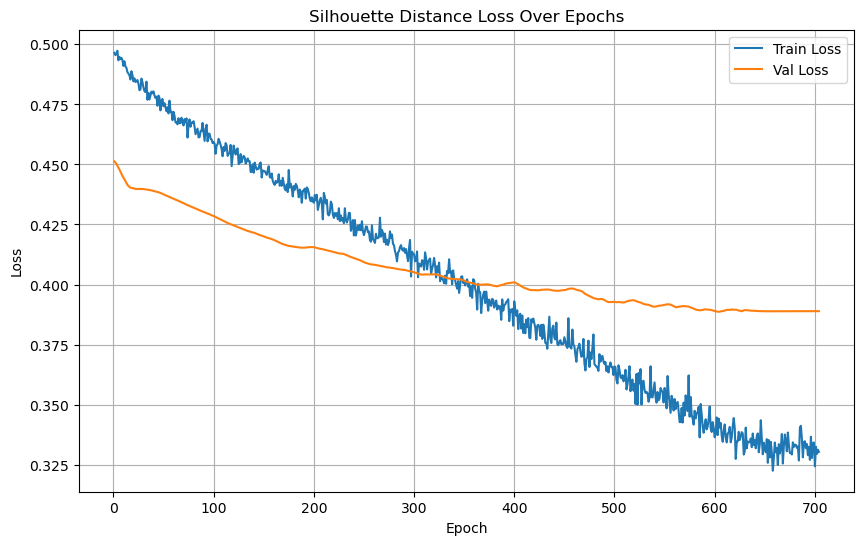

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/157], Loss: 0.3755


Test Batch [20/157], Loss: 0.3161
Test Batch [30/157], Loss: 0.3795
Test Batch [40/157], Loss: 0.3747


Test Batch [50/157], Loss: 0.4499
Test Batch [60/157], Loss: 0.4378


Test Batch [70/157], Loss: 0.2142
Test Batch [80/157], Loss: 0.2719
Test Batch [90/157], Loss: 0.2872
Test Batch [100/157], Loss: 0.2779
Test Batch [110/157], Loss: 0.1918


Test Batch [120/157], Loss: 0.1986
Test Batch [130/157], Loss: 0.1536
Test Batch [140/157], Loss: 0.3990
Test Batch [150/157], Loss: 0.3685



Test Loss: 0.3326


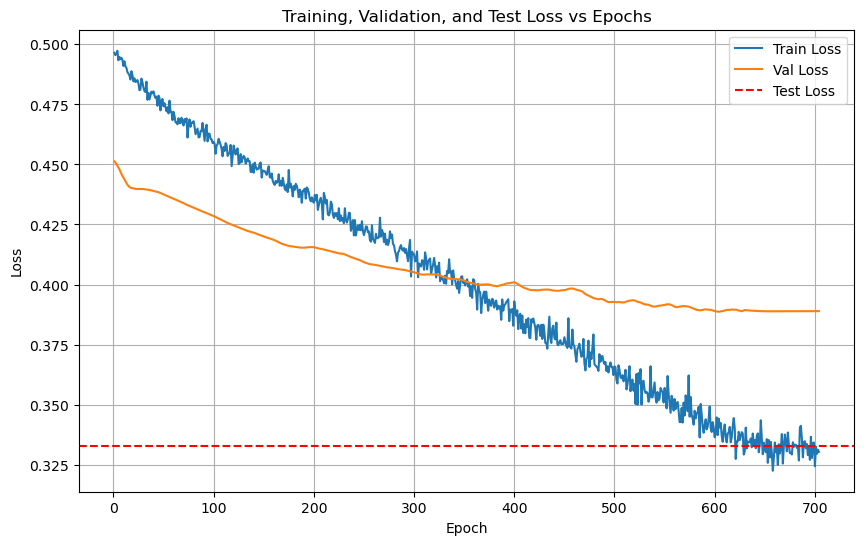

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/157 for test dataset.


  Processed batch 20/157 for test dataset.
  Processed batch 30/157 for test dataset.
  Processed batch 40/157 for test dataset.


  Processed batch 50/157 for test dataset.


  Processed batch 60/157 for test dataset.


  Processed batch 70/157 for test dataset.
  Processed batch 80/157 for test dataset.


  Processed batch 90/157 for test dataset.


  Processed batch 100/157 for test dataset.
  Processed batch 110/157 for test dataset.
  Processed batch 120/157 for test dataset.


  Processed batch 130/157 for test dataset.


  Processed batch 140/157 for test dataset.
  Processed batch 150/157 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.00      0.00      0.00         5
           2       0.38      0.60      0.46         5
           3       0.67      0.40      0.50         5
           4       0.60      0.60      0.60         5
           5       0.67      0.40      0.50         5
           6       0.83      1.00      0.91         5
           7       0.67      0.80      0.73         5
           8       0.83      1.00      0.91         5
           9       0.57      0.80      0.67         5
          10       0.50      0.40      0.44         5
          11       0.33      0.20      0.25         5
          12       0.60      0.60      0.60         5
          13       0.2

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7578  |  Val Loss: 2.7846
Validation loss improved from inf to 2.7846.
[Epoch 2/1000] Train Loss: 2.7382  |  Val Loss: 2.7690
Validation loss improved from 2.7846 to 2.7690.
[Epoch 3/1000] Train Loss: 2.7175  |  Val Loss: 2.7548
Validation loss improved from 2.7690 to 2.7548.
[Epoch 4/1000] Train Loss: 2.6980  |  Val Loss: 2.7413
Validation loss improved from 2.7548 to 2.7413.
[Epoch 5/1000] Train Loss: 2.6820  |  Val Loss: 2.7283
Validation loss improved from 2.7413 to 2.7283.
[Epoch 6/1000] Train Loss: 2.6643  |  Val Loss: 2.7161
Validation loss improved from 2.7283 to 2.7161.
[Epoch 7/1000] Train Loss: 2.6471  |  Val Loss: 2.7046
Validation loss improved from 2.7161 to 2.7046.
[Epoch 8/1000] Train Loss: 2.6335  |  Val Loss: 2.6934
Validation loss improved from 2.7046 to 2.6934.
[Epoch 9/1000] Train Loss: 2.6187  |  Val Loss: 2.6828
Validation loss improved from 2.6934 to 2.6828.
[Epoch 10/1000] Train Loss: 2.6036  |  Val Loss: 2.6730
Validation loss impr

[Epoch 11/1000] Train Loss: 2.5908  |  Val Loss: 2.6641
Validation loss improved from 2.6730 to 2.6641.
[Epoch 12/1000] Train Loss: 2.5786  |  Val Loss: 2.6560
Validation loss improved from 2.6641 to 2.6560.
[Epoch 13/1000] Train Loss: 2.5667  |  Val Loss: 2.6483
Validation loss improved from 2.6560 to 2.6483.
[Epoch 14/1000] Train Loss: 2.5549  |  Val Loss: 2.6408
Validation loss improved from 2.6483 to 2.6408.
[Epoch 15/1000] Train Loss: 2.5445  |  Val Loss: 2.6338
Validation loss improved from 2.6408 to 2.6338.
[Epoch 16/1000] Train Loss: 2.5334  |  Val Loss: 2.6270
Validation loss improved from 2.6338 to 2.6270.
[Epoch 17/1000] Train Loss: 2.5238  |  Val Loss: 2.6202
Validation loss improved from 2.6270 to 2.6202.
[Epoch 18/1000] Train Loss: 2.5140  |  Val Loss: 2.6136
Validation loss improved from 2.6202 to 2.6136.
[Epoch 19/1000] Train Loss: 2.5037  |  Val Loss: 2.6071
Validation loss improved from 2.6136 to 2.6071.
[Epoch 20/1000] Train Loss: 2.4943  |  Val Loss: 2.6007
Validati

[Epoch 27/1000] Train Loss: 2.4315  |  Val Loss: 2.5613
Validation loss improved from 2.5667 to 2.5613.
[Epoch 28/1000] Train Loss: 2.4225  |  Val Loss: 2.5560
Validation loss improved from 2.5613 to 2.5560.
[Epoch 29/1000] Train Loss: 2.4134  |  Val Loss: 2.5507
Validation loss improved from 2.5560 to 2.5507.
[Epoch 30/1000] Train Loss: 2.4047  |  Val Loss: 2.5455
Validation loss improved from 2.5507 to 2.5455.
[Epoch 31/1000] Train Loss: 2.3952  |  Val Loss: 2.5403
Validation loss improved from 2.5455 to 2.5403.
[Epoch 32/1000] Train Loss: 2.3861  |  Val Loss: 2.5352
Validation loss improved from 2.5403 to 2.5352.
[Epoch 33/1000] Train Loss: 2.3769  |  Val Loss: 2.5303
Validation loss improved from 2.5352 to 2.5303.
[Epoch 34/1000] Train Loss: 2.3672  |  Val Loss: 2.5254
Validation loss improved from 2.5303 to 2.5254.
[Epoch 35/1000] Train Loss: 2.3578  |  Val Loss: 2.5204
Validation loss improved from 2.5254 to 2.5204.
[Epoch 36/1000] Train Loss: 2.3481  |  Val Loss: 2.5153
Validati

[Epoch 42/1000] Train Loss: 2.2891  |  Val Loss: 2.4818
Validation loss improved from 2.4877 to 2.4818.
[Epoch 43/1000] Train Loss: 2.2789  |  Val Loss: 2.4760
Validation loss improved from 2.4818 to 2.4760.
[Epoch 44/1000] Train Loss: 2.2686  |  Val Loss: 2.4704
Validation loss improved from 2.4760 to 2.4704.
[Epoch 45/1000] Train Loss: 2.2581  |  Val Loss: 2.4651
Validation loss improved from 2.4704 to 2.4651.
[Epoch 46/1000] Train Loss: 2.2475  |  Val Loss: 2.4594
Validation loss improved from 2.4651 to 2.4594.
[Epoch 47/1000] Train Loss: 2.2373  |  Val Loss: 2.4536
Validation loss improved from 2.4594 to 2.4536.
[Epoch 48/1000] Train Loss: 2.2264  |  Val Loss: 2.4482
Validation loss improved from 2.4536 to 2.4482.
[Epoch 49/1000] Train Loss: 2.2156  |  Val Loss: 2.4426
Validation loss improved from 2.4482 to 2.4426.
[Epoch 50/1000] Train Loss: 2.2052  |  Val Loss: 2.4369
Validation loss improved from 2.4426 to 2.4369.
[Epoch 51/1000] Train Loss: 2.1940  |  Val Loss: 2.4310
Validati

[Epoch 58/1000] Train Loss: 2.1141  |  Val Loss: 2.3845
Validation loss improved from 2.3915 to 2.3845.
[Epoch 59/1000] Train Loss: 2.1022  |  Val Loss: 2.3773
Validation loss improved from 2.3845 to 2.3773.
[Epoch 60/1000] Train Loss: 2.0904  |  Val Loss: 2.3703
Validation loss improved from 2.3773 to 2.3703.
[Epoch 61/1000] Train Loss: 2.0783  |  Val Loss: 2.3633
Validation loss improved from 2.3703 to 2.3633.
[Epoch 62/1000] Train Loss: 2.0659  |  Val Loss: 2.3561
Validation loss improved from 2.3633 to 2.3561.
[Epoch 63/1000] Train Loss: 2.0536  |  Val Loss: 2.3492
Validation loss improved from 2.3561 to 2.3492.
[Epoch 64/1000] Train Loss: 2.0411  |  Val Loss: 2.3418
Validation loss improved from 2.3492 to 2.3418.
[Epoch 65/1000] Train Loss: 2.0286  |  Val Loss: 2.3343
Validation loss improved from 2.3418 to 2.3343.
[Epoch 66/1000] Train Loss: 2.0161  |  Val Loss: 2.3267
Validation loss improved from 2.3343 to 2.3267.
[Epoch 67/1000] Train Loss: 2.0036  |  Val Loss: 2.3194
Validati

[Epoch 74/1000] Train Loss: 1.9120  |  Val Loss: 2.2718
Validation loss improved from 2.2785 to 2.2718.
[Epoch 75/1000] Train Loss: 1.8983  |  Val Loss: 2.2647
Validation loss improved from 2.2718 to 2.2647.
[Epoch 76/1000] Train Loss: 1.8849  |  Val Loss: 2.2575
Validation loss improved from 2.2647 to 2.2575.
[Epoch 77/1000] Train Loss: 1.8713  |  Val Loss: 2.2505
Validation loss improved from 2.2575 to 2.2505.
[Epoch 78/1000] Train Loss: 1.8581  |  Val Loss: 2.2433
Validation loss improved from 2.2505 to 2.2433.
[Epoch 79/1000] Train Loss: 1.8441  |  Val Loss: 2.2361
Validation loss improved from 2.2433 to 2.2361.
[Epoch 80/1000] Train Loss: 1.8305  |  Val Loss: 2.2287
Validation loss improved from 2.2361 to 2.2287.
[Epoch 81/1000] Train Loss: 1.8166  |  Val Loss: 2.2215
Validation loss improved from 2.2287 to 2.2215.
[Epoch 82/1000] Train Loss: 1.8027  |  Val Loss: 2.2145
Validation loss improved from 2.2215 to 2.2145.
[Epoch 83/1000] Train Loss: 1.7890  |  Val Loss: 2.2071
Validati

[Epoch 84/1000] Train Loss: 1.7749  |  Val Loss: 2.2001
Validation loss improved from 2.2071 to 2.2001.
[Epoch 85/1000] Train Loss: 1.7609  |  Val Loss: 2.1928
Validation loss improved from 2.2001 to 2.1928.
[Epoch 86/1000] Train Loss: 1.7472  |  Val Loss: 2.1852
Validation loss improved from 2.1928 to 2.1852.
[Epoch 87/1000] Train Loss: 1.7331  |  Val Loss: 2.1770
Validation loss improved from 2.1852 to 2.1770.
[Epoch 88/1000] Train Loss: 1.7192  |  Val Loss: 2.1691
Validation loss improved from 2.1770 to 2.1691.
[Epoch 89/1000] Train Loss: 1.7052  |  Val Loss: 2.1615
Validation loss improved from 2.1691 to 2.1615.
[Epoch 90/1000] Train Loss: 1.6912  |  Val Loss: 2.1536
Validation loss improved from 2.1615 to 2.1536.
[Epoch 91/1000] Train Loss: 1.6774  |  Val Loss: 2.1456
Validation loss improved from 2.1536 to 2.1456.
[Epoch 92/1000] Train Loss: 1.6640  |  Val Loss: 2.1379
Validation loss improved from 2.1456 to 2.1379.
[Epoch 93/1000] Train Loss: 1.6494  |  Val Loss: 2.1311
Validati

[Epoch 104/1000] Train Loss: 1.5000  |  Val Loss: 2.0536
Validation loss improved from 2.0612 to 2.0536.
[Epoch 105/1000] Train Loss: 1.4865  |  Val Loss: 2.0457
Validation loss improved from 2.0536 to 2.0457.
[Epoch 106/1000] Train Loss: 1.4733  |  Val Loss: 2.0383
Validation loss improved from 2.0457 to 2.0383.
[Epoch 107/1000] Train Loss: 1.4599  |  Val Loss: 2.0309
Validation loss improved from 2.0383 to 2.0309.
[Epoch 108/1000] Train Loss: 1.4469  |  Val Loss: 2.0237
Validation loss improved from 2.0309 to 2.0237.
[Epoch 109/1000] Train Loss: 1.4338  |  Val Loss: 2.0164
Validation loss improved from 2.0237 to 2.0164.
[Epoch 110/1000] Train Loss: 1.4209  |  Val Loss: 2.0092
Validation loss improved from 2.0164 to 2.0092.
[Epoch 111/1000] Train Loss: 1.4077  |  Val Loss: 2.0021
Validation loss improved from 2.0092 to 2.0021.
[Epoch 112/1000] Train Loss: 1.3953  |  Val Loss: 1.9946
Validation loss improved from 2.0021 to 1.9946.
[Epoch 113/1000] Train Loss: 1.3825  |  Val Loss: 1.987

[Epoch 115/1000] Train Loss: 1.3571  |  Val Loss: 1.9739
Validation loss improved from 1.9811 to 1.9739.
[Epoch 116/1000] Train Loss: 1.3446  |  Val Loss: 1.9671
Validation loss improved from 1.9739 to 1.9671.
[Epoch 117/1000] Train Loss: 1.3317  |  Val Loss: 1.9605
Validation loss improved from 1.9671 to 1.9605.
[Epoch 118/1000] Train Loss: 1.3193  |  Val Loss: 1.9538
Validation loss improved from 1.9605 to 1.9538.
[Epoch 119/1000] Train Loss: 1.3067  |  Val Loss: 1.9472
Validation loss improved from 1.9538 to 1.9472.
[Epoch 120/1000] Train Loss: 1.2943  |  Val Loss: 1.9407
Validation loss improved from 1.9472 to 1.9407.
[Epoch 121/1000] Train Loss: 1.2816  |  Val Loss: 1.9348
Validation loss improved from 1.9407 to 1.9348.
[Epoch 122/1000] Train Loss: 1.2693  |  Val Loss: 1.9290
Validation loss improved from 1.9348 to 1.9290.
[Epoch 123/1000] Train Loss: 1.2569  |  Val Loss: 1.9226
Validation loss improved from 1.9290 to 1.9226.
[Epoch 124/1000] Train Loss: 1.2449  |  Val Loss: 1.915

[Epoch 134/1000] Train Loss: 1.1288  |  Val Loss: 1.8518
Validation loss improved from 1.8573 to 1.8518.
[Epoch 135/1000] Train Loss: 1.1179  |  Val Loss: 1.8459
Validation loss improved from 1.8518 to 1.8459.
[Epoch 136/1000] Train Loss: 1.1071  |  Val Loss: 1.8407
Validation loss improved from 1.8459 to 1.8407.
[Epoch 137/1000] Train Loss: 1.0962  |  Val Loss: 1.8347
Validation loss improved from 1.8407 to 1.8347.
[Epoch 138/1000] Train Loss: 1.0853  |  Val Loss: 1.8285
Validation loss improved from 1.8347 to 1.8285.
[Epoch 139/1000] Train Loss: 1.0747  |  Val Loss: 1.8229
Validation loss improved from 1.8285 to 1.8229.
[Epoch 140/1000] Train Loss: 1.0642  |  Val Loss: 1.8179
Validation loss improved from 1.8229 to 1.8179.
[Epoch 141/1000] Train Loss: 1.0537  |  Val Loss: 1.8130
Validation loss improved from 1.8179 to 1.8130.
[Epoch 142/1000] Train Loss: 1.0436  |  Val Loss: 1.8085
Validation loss improved from 1.8130 to 1.8085.
[Epoch 143/1000] Train Loss: 1.0331  |  Val Loss: 1.803

[Epoch 145/1000] Train Loss: 1.0129  |  Val Loss: 1.7941
Validation loss improved from 1.7983 to 1.7941.
[Epoch 146/1000] Train Loss: 1.0030  |  Val Loss: 1.7896
Validation loss improved from 1.7941 to 1.7896.
[Epoch 147/1000] Train Loss: 0.9929  |  Val Loss: 1.7844
Validation loss improved from 1.7896 to 1.7844.
[Epoch 148/1000] Train Loss: 0.9833  |  Val Loss: 1.7791
Validation loss improved from 1.7844 to 1.7791.
[Epoch 149/1000] Train Loss: 0.9731  |  Val Loss: 1.7746
Validation loss improved from 1.7791 to 1.7746.
[Epoch 150/1000] Train Loss: 0.9633  |  Val Loss: 1.7699
Validation loss improved from 1.7746 to 1.7699.
[Epoch 151/1000] Train Loss: 0.9534  |  Val Loss: 1.7646
Validation loss improved from 1.7699 to 1.7646.
[Epoch 152/1000] Train Loss: 0.9441  |  Val Loss: 1.7593
Validation loss improved from 1.7646 to 1.7593.
[Epoch 153/1000] Train Loss: 0.9340  |  Val Loss: 1.7547
Validation loss improved from 1.7593 to 1.7547.
[Epoch 154/1000] Train Loss: 0.9243  |  Val Loss: 1.750

[Epoch 164/1000] Train Loss: 0.8304  |  Val Loss: 1.7041
Validation loss improved from 1.7088 to 1.7041.
[Epoch 165/1000] Train Loss: 0.8212  |  Val Loss: 1.6996
Validation loss improved from 1.7041 to 1.6996.
[Epoch 166/1000] Train Loss: 0.8123  |  Val Loss: 1.6945
Validation loss improved from 1.6996 to 1.6945.
[Epoch 167/1000] Train Loss: 0.8039  |  Val Loss: 1.6893
Validation loss improved from 1.6945 to 1.6893.
[Epoch 168/1000] Train Loss: 0.7946  |  Val Loss: 1.6845
Validation loss improved from 1.6893 to 1.6845.
[Epoch 169/1000] Train Loss: 0.7861  |  Val Loss: 1.6801
Validation loss improved from 1.6845 to 1.6801.
[Epoch 170/1000] Train Loss: 0.7773  |  Val Loss: 1.6758
Validation loss improved from 1.6801 to 1.6758.
[Epoch 171/1000] Train Loss: 0.7687  |  Val Loss: 1.6720
Validation loss improved from 1.6758 to 1.6720.
[Epoch 172/1000] Train Loss: 0.7602  |  Val Loss: 1.6678
Validation loss improved from 1.6720 to 1.6678.
[Epoch 173/1000] Train Loss: 0.7517  |  Val Loss: 1.662

[Epoch 176/1000] Train Loss: 0.7268  |  Val Loss: 1.6490
Validation loss improved from 1.6533 to 1.6490.
[Epoch 177/1000] Train Loss: 0.7185  |  Val Loss: 1.6447
Validation loss improved from 1.6490 to 1.6447.
[Epoch 178/1000] Train Loss: 0.7108  |  Val Loss: 1.6409
Validation loss improved from 1.6447 to 1.6409.
[Epoch 179/1000] Train Loss: 0.7025  |  Val Loss: 1.6374
Validation loss improved from 1.6409 to 1.6374.
[Epoch 180/1000] Train Loss: 0.6943  |  Val Loss: 1.6340
Validation loss improved from 1.6374 to 1.6340.
[Epoch 181/1000] Train Loss: 0.6865  |  Val Loss: 1.6301
Validation loss improved from 1.6340 to 1.6301.
[Epoch 182/1000] Train Loss: 0.6787  |  Val Loss: 1.6264
Validation loss improved from 1.6301 to 1.6264.
[Epoch 183/1000] Train Loss: 0.6706  |  Val Loss: 1.6232
Validation loss improved from 1.6264 to 1.6232.
[Epoch 184/1000] Train Loss: 0.6628  |  Val Loss: 1.6200
Validation loss improved from 1.6232 to 1.6200.
[Epoch 185/1000] Train Loss: 0.6553  |  Val Loss: 1.617

[Epoch 191/1000] Train Loss: 0.6111  |  Val Loss: 1.6009
Validation loss improved from 1.6034 to 1.6009.
[Epoch 192/1000] Train Loss: 0.6038  |  Val Loss: 1.5989
Validation loss improved from 1.6009 to 1.5989.
[Epoch 193/1000] Train Loss: 0.5972  |  Val Loss: 1.5969
Validation loss improved from 1.5989 to 1.5969.
[Epoch 194/1000] Train Loss: 0.5901  |  Val Loss: 1.5944
Validation loss improved from 1.5969 to 1.5944.
[Epoch 195/1000] Train Loss: 0.5831  |  Val Loss: 1.5919
Validation loss improved from 1.5944 to 1.5919.
[Epoch 196/1000] Train Loss: 0.5769  |  Val Loss: 1.5899
Validation loss improved from 1.5919 to 1.5899.
[Epoch 197/1000] Train Loss: 0.5698  |  Val Loss: 1.5868
Validation loss improved from 1.5899 to 1.5868.
[Epoch 198/1000] Train Loss: 0.5636  |  Val Loss: 1.5837
Validation loss improved from 1.5868 to 1.5837.
[Epoch 199/1000] Train Loss: 0.5572  |  Val Loss: 1.5807
Validation loss improved from 1.5837 to 1.5807.
[Epoch 200/1000] Train Loss: 0.5509  |  Val Loss: 1.578

[Epoch 204/1000] Train Loss: 0.5265  |  Val Loss: 1.5709
Validation loss improved from 1.5725 to 1.5709.
[Epoch 205/1000] Train Loss: 0.5207  |  Val Loss: 1.5686
Validation loss improved from 1.5709 to 1.5686.
[Epoch 206/1000] Train Loss: 0.5150  |  Val Loss: 1.5661
Validation loss improved from 1.5686 to 1.5661.
[Epoch 207/1000] Train Loss: 0.5094  |  Val Loss: 1.5634
Validation loss improved from 1.5661 to 1.5634.
[Epoch 208/1000] Train Loss: 0.5038  |  Val Loss: 1.5607
Validation loss improved from 1.5634 to 1.5607.
[Epoch 209/1000] Train Loss: 0.4982  |  Val Loss: 1.5581
Validation loss improved from 1.5607 to 1.5581.
[Epoch 210/1000] Train Loss: 0.4926  |  Val Loss: 1.5561
Validation loss improved from 1.5581 to 1.5561.
[Epoch 211/1000] Train Loss: 0.4876  |  Val Loss: 1.5543
Validation loss improved from 1.5561 to 1.5543.
[Epoch 212/1000] Train Loss: 0.4822  |  Val Loss: 1.5531
Validation loss improved from 1.5543 to 1.5531.
[Epoch 213/1000] Train Loss: 0.4770  |  Val Loss: 1.552

[Epoch 221/1000] Train Loss: 0.4371  |  Val Loss: 1.5405
Validation loss improved from 1.5424 to 1.5405.
[Epoch 222/1000] Train Loss: 0.4327  |  Val Loss: 1.5394
Validation loss improved from 1.5405 to 1.5394.
[Epoch 223/1000] Train Loss: 0.4280  |  Val Loss: 1.5386
Validation loss improved from 1.5394 to 1.5386.
[Epoch 224/1000] Train Loss: 0.4233  |  Val Loss: 1.5386
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.4187  |  Val Loss: 1.5380
Validation loss improved from 1.5386 to 1.5380.
[Epoch 226/1000] Train Loss: 0.4144  |  Val Loss: 1.5382
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.4101  |  Val Loss: 1.5389
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 228/1000] Train Loss: 0.4061  |  Val Loss: 1.5395
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 229/1000] Train Loss: 0.4020  |  Val Loss: 1.5398
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 230/1000] Train Lo

[Epoch 234/1000] Train Loss: 0.3826  |  Val Loss: 1.5368
Validation loss improved from 1.5369 to 1.5368.
[Epoch 235/1000] Train Loss: 0.3789  |  Val Loss: 1.5373
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.3751  |  Val Loss: 1.5370
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 237/1000] Train Loss: 0.3717  |  Val Loss: 1.5369
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 238/1000] Train Loss: 0.3682  |  Val Loss: 1.5360
Validation loss improved from 1.5368 to 1.5360.
[Epoch 239/1000] Train Loss: 0.3648  |  Val Loss: 1.5349
Validation loss improved from 1.5360 to 1.5349.
[Epoch 240/1000] Train Loss: 0.3613  |  Val Loss: 1.5355
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 0.3579  |  Val Loss: 1.5349
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 0.3546  |  Val Loss: 1.5332
Validation loss improved from 1.5349 to 1.5332.
[Epoch 243/1000] Train Lo

[Epoch 253/1000] Train Loss: 0.3209  |  Val Loss: 1.5267
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.3183  |  Val Loss: 1.5289
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 0.3155  |  Val Loss: 1.5292
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 256/1000] Train Loss: 0.3128  |  Val Loss: 1.5302
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 257/1000] Train Loss: 0.3101  |  Val Loss: 1.5321
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 258/1000] Train Loss: 0.3075  |  Val Loss: 1.5329
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 259/1000] Train Loss: 0.3048  |  Val Loss: 1.5346
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 260/1000] Train Loss: 0.3023  |  Val Loss: 1.5371
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 261/1000] Train Loss: 0.3000  |  Val Loss: 1.5396
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 264/1000] Train Loss: 0.2925  |  Val Loss: 1.5449
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 265/1000] Train Loss: 0.2903  |  Val Loss: 1.5461
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 266/1000] Train Loss: 0.2880  |  Val Loss: 1.5470
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 267/1000] Train Loss: 0.2856  |  Val Loss: 1.5475
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 268/1000] Train Loss: 0.2835  |  Val Loss: 1.5479
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 269/1000] Train Loss: 0.2811  |  Val Loss: 1.5472
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 270/1000] Train Loss: 0.2791  |  Val Loss: 1.5464
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 271/1000] Train Loss: 0.2769  |  Val Loss: 1.5489
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 272/1000] Train Loss: 0.2748  |  Val Loss: 1.5510
!! Validation loss did NOT improve !! Patience:

[Epoch 285/1000] Train Loss: 0.2494  |  Val Loss: 1.5518
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 286/1000] Train Loss: 0.2476  |  Val Loss: 1.5525
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 287/1000] Train Loss: 0.2458  |  Val Loss: 1.5538
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 288/1000] Train Loss: 0.2441  |  Val Loss: 1.5552
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 289/1000] Train Loss: 0.2424  |  Val Loss: 1.5563
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 290/1000] Train Loss: 0.2405  |  Val Loss: 1.5580
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 291/1000] Train Loss: 0.2389  |  Val Loss: 1.5602
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 292/1000] Train Loss: 0.2374  |  Val Loss: 1.5634
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 293/1000] Train Loss: 0.2358  |  Val Loss: 1.5632
!! Validation loss did NOT improve !! Patience:

[Epoch 296/1000] Train Loss: 0.2306  |  Val Loss: 1.5613
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 297/1000] Train Loss: 0.2291  |  Val Loss: 1.5607
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 298/1000] Train Loss: 0.2275  |  Val Loss: 1.5593
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 299/1000] Train Loss: 0.2259  |  Val Loss: 1.5595
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 300/1000] Train Loss: 0.2243  |  Val Loss: 1.5615
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 301/1000] Train Loss: 0.2228  |  Val Loss: 1.5644
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 302/1000] Train Loss: 0.2212  |  Val Loss: 1.5675
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 303/1000] Train Loss: 0.2197  |  Val Loss: 1.5699
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 304/1000] Train Loss: 0.2182  |  Val Loss: 1.5718
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 0.2096  |  Val Loss: 1.5778
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 311/1000] Train Loss: 0.2082  |  Val Loss: 1.5784
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 312/1000] Train Loss: 0.2068  |  Val Loss: 1.5788
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 313/1000] Train Loss: 0.2056  |  Val Loss: 1.5802
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 314/1000] Train Loss: 0.2042  |  Val Loss: 1.5796
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 315/1000] Train Loss: 0.2030  |  Val Loss: 1.5799
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 316/1000] Train Loss: 0.2015  |  Val Loss: 1.5809
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 317/1000] Train Loss: 0.2002  |  Val Loss: 1.5809
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 318/1000] Train Loss: 0.1989  |  Val Loss: 1.5829
!! Validation loss did NOT improve !! Patience:

[Epoch 323/1000] Train Loss: 0.1923  |  Val Loss: 1.5900
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 324/1000] Train Loss: 0.1911  |  Val Loss: 1.5916
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 325/1000] Train Loss: 0.1901  |  Val Loss: 1.5951
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 326/1000] Train Loss: 0.1887  |  Val Loss: 1.5971
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 327/1000] Train Loss: 0.1876  |  Val Loss: 1.5996
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 328/1000] Train Loss: 0.1862  |  Val Loss: 1.6011
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 329/1000] Train Loss: 0.1850  |  Val Loss: 1.6021
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 330/1000] Train Loss: 0.1838  |  Val Loss: 1.6039
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 331/1000] Train Loss: 0.1825  |  Val Loss: 1.6028
!! Validation loss did NOT improve !! Patience:

[Epoch 336/1000] Train Loss: 0.1767  |  Val Loss: 1.6070
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 337/1000] Train Loss: 0.1755  |  Val Loss: 1.6084
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 338/1000] Train Loss: 0.1747  |  Val Loss: 1.6101
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 339/1000] Train Loss: 0.1732  |  Val Loss: 1.6104
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 340/1000] Train Loss: 0.1721  |  Val Loss: 1.6094
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 341/1000] Train Loss: 0.1710  |  Val Loss: 1.6097
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 342/1000] Train Loss: 0.1700  |  Val Loss: 1.6093
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 343/1000] Train Loss: 0.1688  |  Val Loss: 1.6089
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 344/1000] Train Loss: 0.1679  |  Val Loss: 1.6085
!! Validation loss did NOT improve !! Patience:

[Epoch 350/1000] Train Loss: 0.1617  |  Val Loss: 1.6243
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 350 !!
No improvement for 100 epochs.


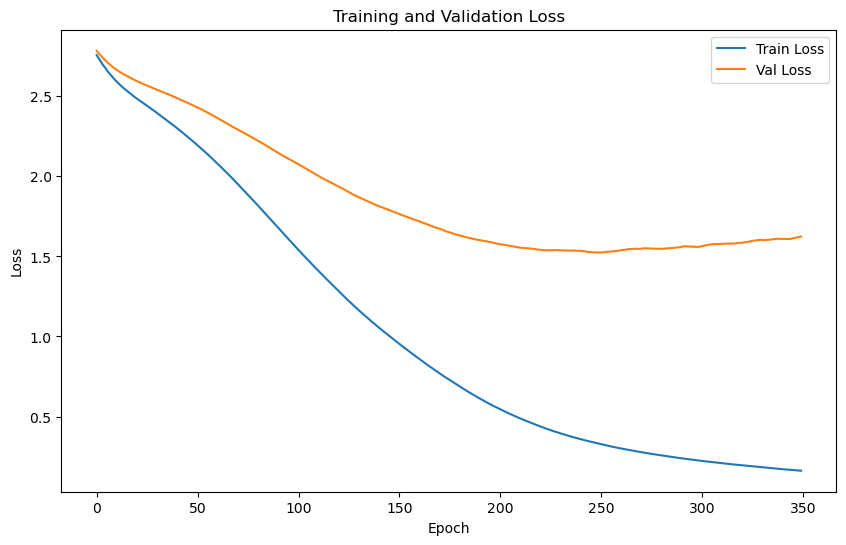

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.2744 | Test Accuracy: 44.22%


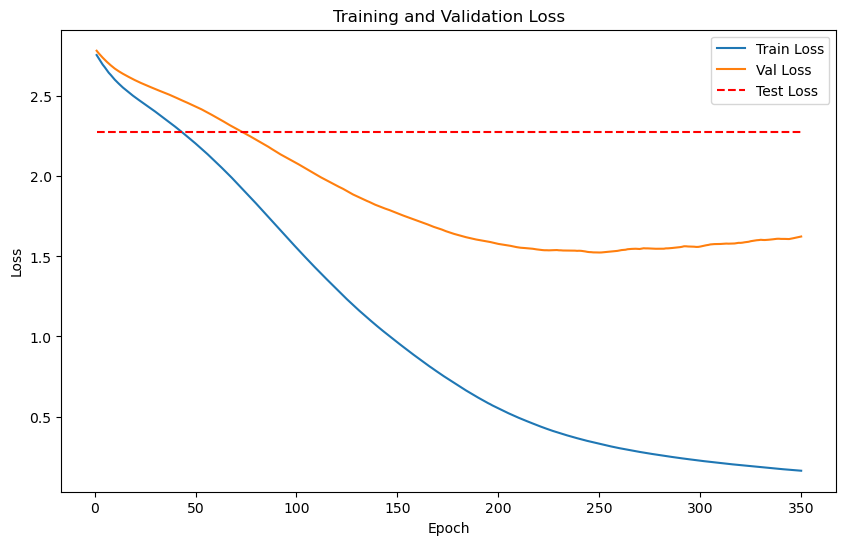

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


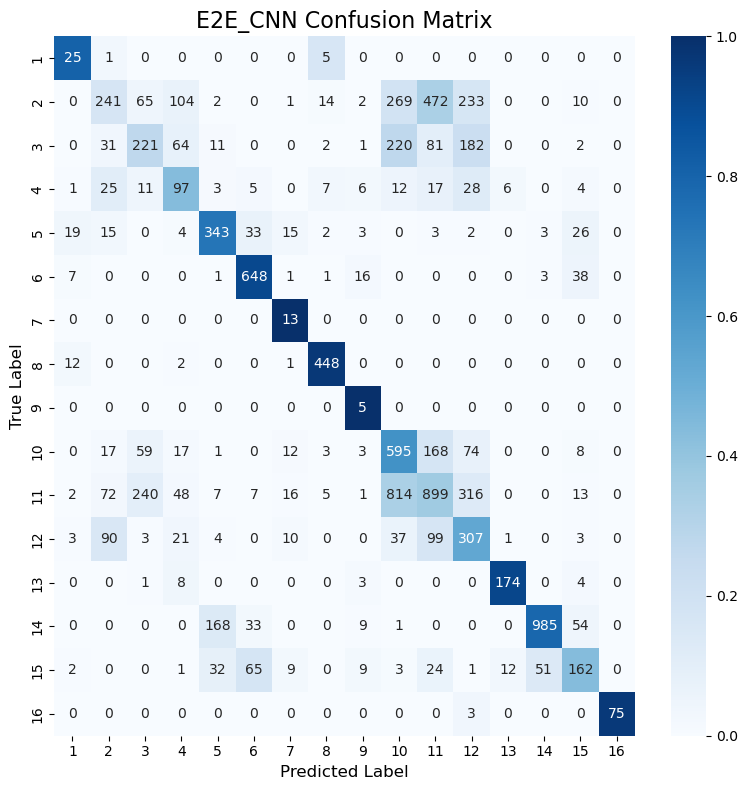

Classification Accuracy: 52.33%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


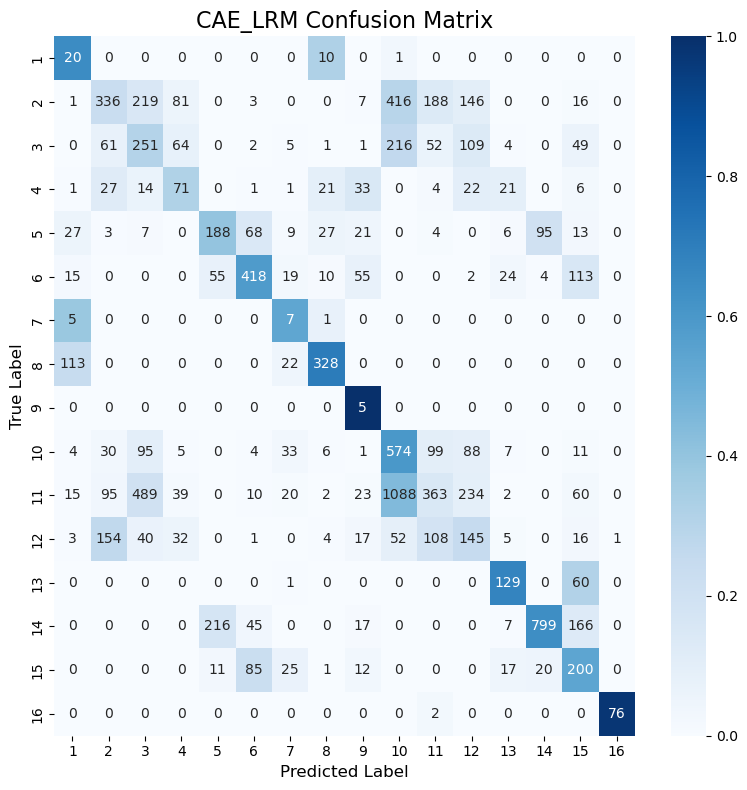

Classification Accuracy: 39.06%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


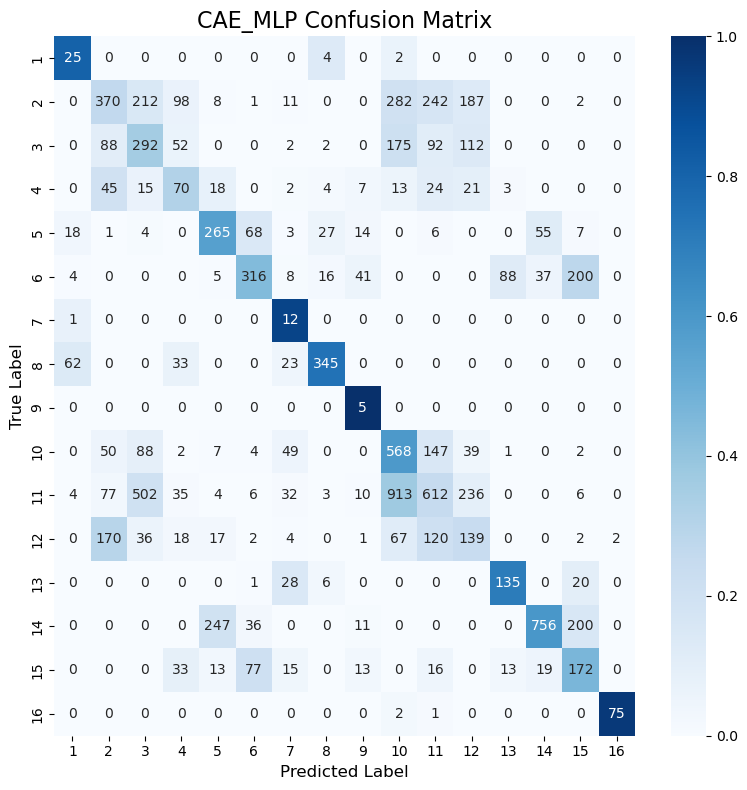

Classification Accuracy: 41.53%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


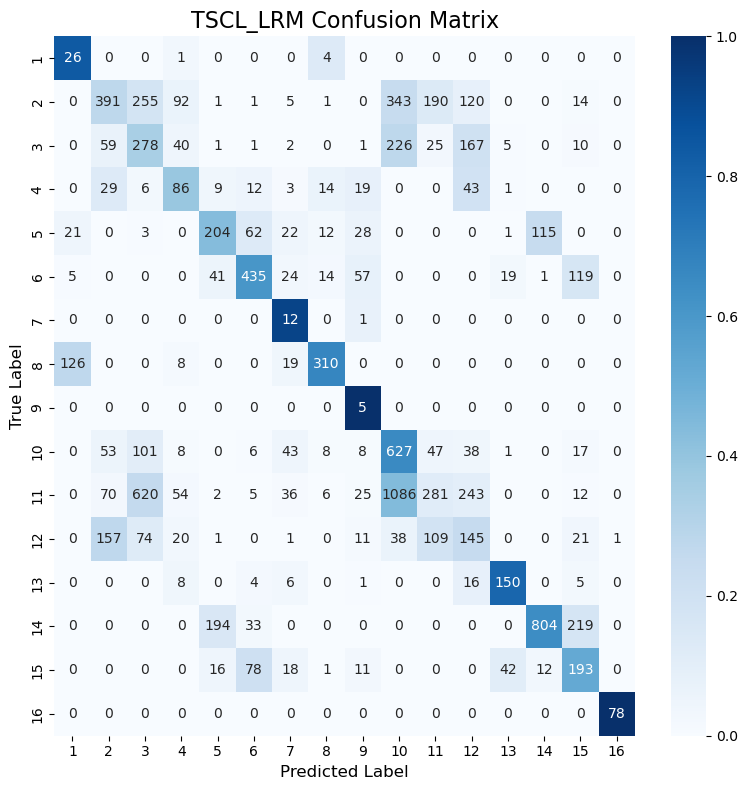

Classification Accuracy: 40.21%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


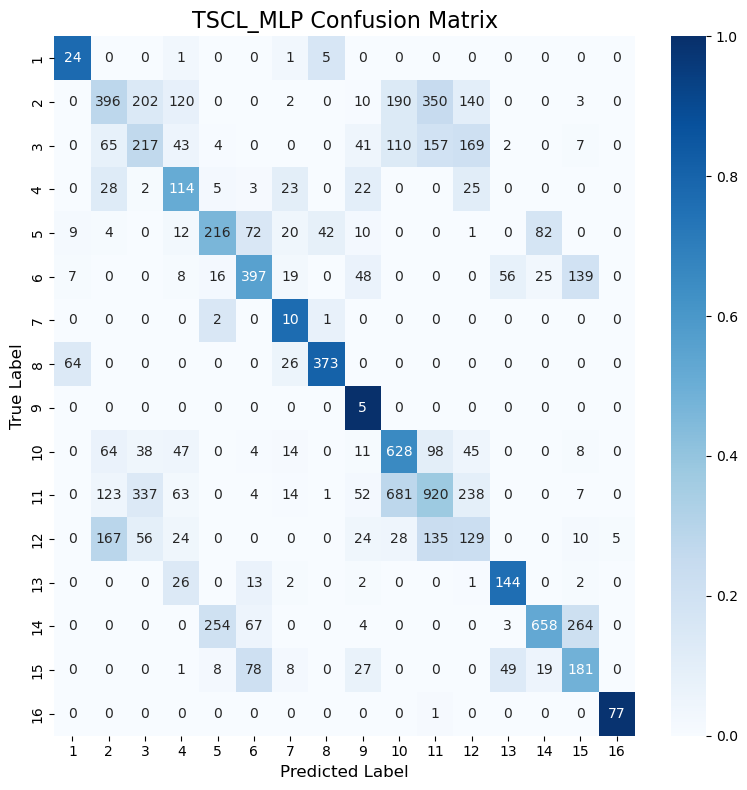

Classification Accuracy: 44.85%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


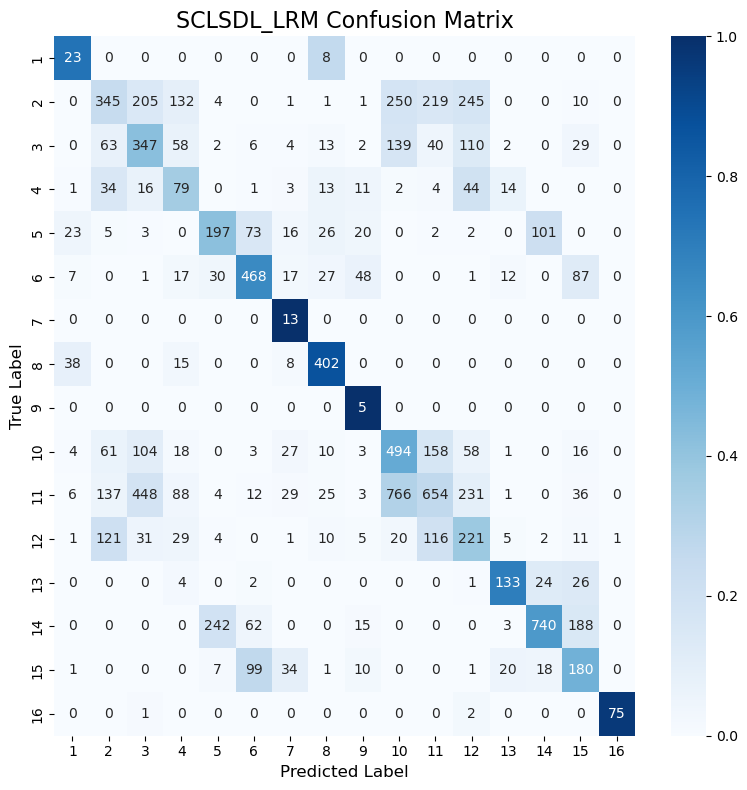

Classification Accuracy: 43.72%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


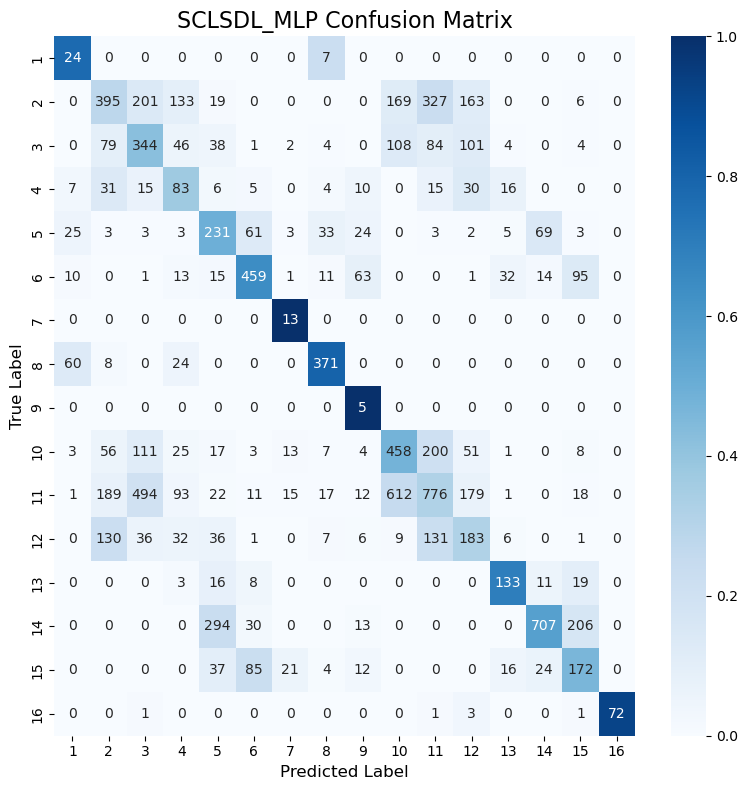

Classification Accuracy: 44.22%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          52.33
1    LRM (CAE)          39.06
2    MLP (CAE)          41.53
3     TSCL LRM          40.21
4     TSCL MLP          44.85
5  SCL_SDL LRM          43.72
6  SCL_SDL MLP          44.22

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          52.33
4     TSCL MLP          44.85
6  SCL_SDL MLP          44.22
5  SCL_SDL LRM          43.72
2    MLP (CAE)          41.53
3     TSCL LRM          40.21
1    LRM (CAE)          39.06
